This script structures the data available from different sources, namely video recordings, inscopix and accel for a single session of one animal. Later, the goal is to generalize the code for all files of all animals.

Importantly, it identifies errors, misalignments, dropped frames, ...

All the files used to build this structure were downloaded to the Desktop from the google drive 'EurDyscover>Organized>Analyzed data'

---

# 1. Import all the files 

## 1.1 Import neuron.mat
This is a matlab file containing the information of every neuron across time.


The [CNMF-E](https://github.com/zhoupc/CNMF_E) package for extracting calcium traces from microendoscope data outputs Matlab .mat files.  These files represent the data as a custom Matlab class called Sources2D, so they cannot be directly loaded into Python for further analysis.  This repository provides functions for converting the CNMF-E output into Numpy .npy files.

The Matlab function `Sources2D_to_simple_mat` converts the .mat file output by CNMFe to a more basic .mat file that can be opened in Python using `scipy.io.loadmat`.  In order to load the .mat files generated by CNMF-E into Matlab you must also have the file *Sources2D.m* which contains the Matlab class definition in the Matlab file path.

 The Python function `simple_mat_to_npy` converts the  .mat file generated by `Sources2D_to_simple_mat`  to a folder of .npy files with a separate file for each of the variables 'A', 'S', 'C', 'C_raw'.   The A matrix is reshaped such that neuron footprints can be visualised with `plt.imshow(A[0])` etc.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib tk

In [1]:
# Using matlab function Sources2D_to_simple_mat, I obtain the data.mat file
path_data = "C:\\Users\\user\\Desktop\\42312_2F_W9\\CNMF-E_mat2npy-master\\data.mat"

from os.path import dirname, join as pjoin
import scipy.io as sio

# this test varible contains the information of the data.mat file 
neuron_mat_info = sio.loadmat(path_data)
neuron_mat_info #python dictionary

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Sep 22 16:21:32 2022',
 '__version__': '1.0',
 '__globals__': [],
 'None': MatlabOpaque([(b'file_name', b'MCOS', b'string', array([[3707764736],
                      [         2],
                      [         1],
                      [         1],
                      [         1],
                      [         1]], dtype=uint32))                   ],
              dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
 'A': <94605x118 sparse matrix of type '<class 'numpy.float64'>'
 	with 40915 stored elements in Compressed Sparse Column format>,
 'C': array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         4.69066057e-019, 4.03749689e-019, 3.47528475e-019],
        [5.30945548e-002, 4.37087149e-002, 3.59820656e-002, ...,
         2.39654343e-018, 1.97289220e-018, 1.62413233e-018],
        [7.84489577e-001, 3.15598738e+000, 2.65682759e+000, ...,
         3.56473604e-002, 3.00092743

In [2]:
import numpy as np

# Convert A from sparse matrix to numpy array. Reshape A to be size [n_neurons, image_y_dim, image_x_dim]
A = neuron_mat_info['A'].toarray().reshape([*np.flip(neuron_mat_info['image_size'][0]),-1]).transpose()
# Convert S from sparse matrix to numpy array.
S = neuron_mat_info['S'].toarray()

I can now access all four variables: 'A', 'S', 'C', 'C_raw'
(A and S directly, and C/C_raw using neuron_mat_info['C']/neuron_mat_info['C_raw'])

In [3]:
print('A shape: {}\nS shape: {}\nC shape: {}\nC_raw shape: {}'.format(A.shape, S.shape, neuron_mat_info['C'].shape, neuron_mat_info['C_raw'].shape))
# S, C and C_raw should have the same shape AND shape[0] should be the same for every variable
missing_data = True
if S.shape == neuron_mat_info['C'].shape == neuron_mat_info['C_raw'].shape and A.shape[0]==S.shape[0]:
    missing_data = False
    print('\nThis data looks ok :)')
    calcium_length = neuron_mat_info['C_raw'].shape[1]
else:
    print('There is something wrong with the variable dimensions!')

###    
    
import pandas as pd

#organize calcium signals in a dataframe
df_calcium = pd.DataFrame(neuron_mat_info['C'])
df_calcium = df_calcium.T

neuron_labels = []
for neuron in range(1, neuron_mat_info['C'].shape[0]+1):
    neuron_label = 'neuron_'+str(neuron)
    neuron_labels.append(neuron_label)

df_calcium.columns = neuron_labels

neuron_data_ready = True
for col, i in zip(df_calcium.columns,range(len(df_calcium))):
    if np.sum(df_calcium[col]==neuron_mat_info['C'][i])!=df_calcium.shape[0] or df_calcium.isnull().values.any()==True:
        neuron_data_ready=False
    
if neuron_data_ready:
    print('\nThe df_calcium dataframe was created correctly :)')
    
else:
    print('\nThe df_calcium dataframe is not correct :(')
    
df_calcium

A shape: (118, 265, 357)
S shape: (118, 13352)
C shape: (118, 13352)
C_raw shape: (118, 13352)

This data looks ok :)

The df_calcium dataframe was created correctly :)


,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,neuron_10,...,neuron_109,neuron_110,neuron_111,neuron_112,neuron_113,neuron_114,neuron_115,neuron_116,neuron_117,neuron_118
0,0.000000e+00,5.309455e-02,0.784490,8.034618e-01,1.560819e+00,0.000000e+00,4.452372,0.000000,0.467638,2.802077e-01,...,0.000000,0.000000e+00,1.389331e+00,8.105833e-01,0.000000e+00,6.441143e-03,0.000000e+00,1.409707e+00,0.000000e+00,4.142934
1,0.000000e+00,4.370871e-02,3.155987,6.799244e-01,1.284141e+00,0.000000e+00,3.668832,0.000000,0.408682,2.358810e-01,...,0.000000,0.000000e+00,1.233444e+00,6.877896e-01,0.000000e+00,4.761287e-03,0.000000e+00,1.180783e+00,0.000000e+00,3.037615
2,0.000000e+00,3.598207e-02,2.656828,5.753817e-01,1.056509e+00,0.000000e+00,3.023182,0.000000,0.357158,1.985664e-01,...,0.000000,0.000000e+00,1.095048e+00,5.835977e-01,0.000000e+00,3.519539e-03,0.000000e+00,9.890344e-01,0.000000e+00,2.227190
3,0.000000e+00,2.962130e-02,2.236616,4.869130e-01,8.692277e-01,0.000000e+00,2.491155,0.000000,0.312130,1.671547e-01,...,0.000000,0.000000e+00,9.721803e-01,4.951896e-01,0.000000e+00,2.601640e-03,0.000000e+00,8.284240e-01,0.000000e+00,1.632984
4,0.000000e+00,2.438497e-02,1.882867,4.120470e-01,7.151447e-01,0.000000e+00,2.052755,0.000000,0.272779,1.407121e-01,...,0.000000,0.000000e+00,8.630988e-01,4.201743e-01,0.000000e+00,1.923130e-03,0.000000e+00,6.938953e-01,0.000000e+00,1.197310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13347,6.331077e-19,3.536301e-18,0.050300,5.707155e-64,3.059990e-23,2.288749e-36,0.000197,0.530118,0.063042,4.400458e-115,...,0.035156,4.127102e-50,3.094182e-66,4.014638e-92,1.944469e-211,1.249391e-76,1.417543e-43,3.059267e-150,4.138330e-186,0.000000
13348,5.449489e-19,2.911168e-18,0.042345,4.829643e-64,2.517563e-23,1.880247e-36,0.000162,0.435227,0.055094,3.704339e-115,...,0.027215,3.389209e-50,2.747005e-66,3.406469e-92,1.655860e-211,9.235490e-77,1.106957e-43,2.562470e-150,3.917260e-186,0.000000
13349,4.690661e-19,2.396543e-18,0.035647,4.087054e-64,2.071289e-23,1.544655e-36,0.000134,0.357321,0.048148,3.118341e-115,...,0.021067,2.783245e-50,2.438783e-66,2.890429e-92,1.410087e-211,6.826865e-77,8.644209e-44,2.146347e-150,3.708000e-186,0.000000
13350,4.037497e-19,1.972892e-18,0.030009,3.458644e-64,1.704124e-23,1.268960e-36,0.000110,0.293360,0.042078,2.625043e-115,...,0.016308,2.285623e-50,2.165145e-66,2.452564e-92,1.200794e-211,5.046412e-77,6.750250e-44,1.797800e-150,3.509919e-186,0.000000


In [4]:
# the same as the previous cell but for raw data
import pandas as pd

#organize raw calcium signals in a dataframe
df_calcium_raw = pd.DataFrame(neuron_mat_info['C_raw'])
df_calcium_raw = df_calcium_raw.T

neuron_labels = []
for neuron in range(1, neuron_mat_info['C_raw'].shape[0]+1):
    neuron_label = 'neuron_'+str(neuron)
    neuron_labels.append(neuron_label)

df_calcium_raw.columns = neuron_labels

raw_neuron_data_ready = True
for col, i in zip(df_calcium_raw.columns,range(len(df_calcium_raw))):
    if np.sum(df_calcium_raw[col]==neuron_mat_info['C_raw'][i])!=df_calcium_raw.shape[0] or df_calcium_raw.isnull().values.any()==True:
        raw_neuron_data_ready=False
    
if raw_neuron_data_ready:
    print('\nThe df_calcium_raw dataframe was created correctly :)')
    print('You can know proceed to step 1.2')
    
else:
    print('\nThe df_calcium dataframe is not correct :(')
    
df_calcium_raw


The df_calcium_raw dataframe was created correctly :)
You can know proceed to step 1.2


,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,neuron_10,...,neuron_109,neuron_110,neuron_111,neuron_112,neuron_113,neuron_114,neuron_115,neuron_116,neuron_117,neuron_118
0,-0.587355,0.297486,0.784451,0.314389,1.399033,-0.354658,3.658387,-0.584839,0.183878,0.070030,...,-1.208046,-1.335975,0.376972,0.583448,-0.348716,0.146337,-1.517173,0.083122,-4.112145,4.570128
1,-0.894721,0.508434,2.211994,0.552943,1.274317,-0.265377,3.023196,-0.916032,0.019333,0.124759,...,-0.691168,-0.795974,1.381664,0.824327,0.101612,0.257695,1.074827,2.041379,-4.028334,1.538837
2,-0.710960,0.247358,2.744885,0.528114,0.860022,-0.056477,2.813427,-0.949183,0.141131,0.445943,...,-0.762624,-0.635271,1.317775,0.631458,-0.026197,-1.186504,0.716305,0.386470,-3.462954,-0.032024
3,-0.643424,0.126902,2.748074,0.454766,0.711658,0.101682,2.661677,-0.509099,0.444075,0.544695,...,0.472751,0.711288,1.027622,0.043154,-0.063468,-0.752423,0.143528,1.509125,-4.989443,2.019250
4,-0.719451,0.077916,2.731979,1.154034,0.748926,0.042996,3.039186,-0.282976,0.711966,0.107791,...,-0.704413,0.407389,1.934714,0.010275,-0.150172,0.921947,0.401771,0.491272,-5.805814,5.792244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13347,0.045661,0.386393,0.314078,0.233647,-0.617180,0.033060,0.651632,0.791377,-0.385891,0.305500,...,-0.081924,0.130554,0.992446,0.162637,-0.155105,-0.041642,1.365855,-0.016489,0.973509,1.633205
13348,0.202421,0.618646,0.016083,-0.304971,-0.503963,0.094094,0.703954,0.645892,-0.256675,0.424466,...,0.285959,-0.008784,-0.002090,-0.168628,-0.377991,0.498570,0.317896,-0.489739,0.954916,-1.479139
13349,0.087952,0.313895,0.010731,-0.183932,-0.328360,0.137239,0.970196,0.578249,-0.384043,0.535773,...,-0.203308,0.005965,-0.698984,0.064546,-0.658527,-0.917703,2.627026,0.807629,1.420326,-0.884681
13350,-0.136774,0.386109,0.289123,0.063839,-0.313454,0.270948,0.492264,0.042535,-0.053832,0.061936,...,0.405389,-0.251610,0.874731,-0.707979,0.239436,-1.451513,-0.619926,-0.686105,-0.323938,0.938226


## 1.2 Import acceldata.csv 
This is the file that contains the timestamps of all the hardware.

'Command' of interest - 3

'RegisterAddress':
- 34 - Accelerometer (sampling_rate 200 Hz)
- 37 - Camera (sampling_rate 30 Hz)
- 35 - Inscopix (sampling_rate 20 Hz)

In this sections, I organize the data from the acceldata.cvs file, and test all the timestamps to make sure you can follow through with the analysis.

I seperately check the data from: Accelerometer, Camera and Microscope (Inscopix)

In [5]:
import pandas as pd

path_acceldata = "C:\\Users\\user\\Desktop\\42312_2F_W9\\42312_2F_W9_AccelData2021-07-07T12_26_09.9099136+01_00.csv"

##### Accel data AND timestamps...

 With this dataframe I will start by ansewring the following question:
 Are the timestamps of this dataframe in agreement with the dimensions of the data from the following dataframes?

 If NO, ..let the user know (print ERROR messages, and set flags in the locations where the error was found) - the flags part is not implemented yet

 Finally, once everything is checked, I can start the analysis itself namely seeing which initiations detected from the    accelerometer involve the lesioned paw and checking the calcium traces in those cases versus a movement that does not involve the right paw (e.g. moving the head while standing still, initiation with the left paw, for example)

 The data that is going to be used for further analysis is from the first to the last '35', corresponding to the time during which all three channels are ON. The first '35' corresponds to the first TTL from the Inscopix

In [6]:
import csv, numpy

def convert(val): 
    try:
        return float(val)
    except:
        return val

with open(path_acceldata, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    values = []
    max_cols = 0
    for index, row in enumerate(spamreader):
        if index==0: continue
        row = list(map(convert, row))
        if len(row)>max_cols: max_cols=len(row)
        values.append(row)

    matrix = []
    for row in values:
        row = row + [None for x in range(max_cols-len(row))]
        matrix.append(row)

    matrix = numpy.array(matrix)
    
matrix_columns = ['Command', 'RegisterAddress', 'Timestamp', 
                  'DataElement0', 'Accel_y','Accel_z', 
                  'Gyr_x','Gyr_y', 'Gyr_z', 
                  'Magn_x', 'Magn_y', 'Magn_z', 
                  'Counter', 
                  'col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28']

df_acceldata = pd.DataFrame(matrix, columns = matrix_columns)
df_acceldata = df_acceldata.apply(pd.to_numeric)
to_drop = ['col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28']
df_acceldata = df_acceldata.drop(columns = to_drop)
df_acceldata #this dataframe contains all the timestamps (camera, inscopix and accelerometer), as well as the accel data itself

,Command,RegisterAddress,Timestamp,DataElement0,Accel_y,Accel_z,Gyr_x,Gyr_y,Gyr_z,Magn_x,Magn_y,Magn_z,Counter
0,2.0,10.0,691511.8325,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,691511.8325,1056.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,32.0,691511.8335,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,691511.8345,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,33.0,691511.8355,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185505,3.0,34.0,692227.9880,-2345.0,-1515.0,-7353.0,-185.0,-3431.0,-241.0,49.0,259.0,-295.0,93.0
185506,3.0,37.0,692227.9927,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185507,3.0,34.0,692227.9924,-3111.0,-1624.0,-7675.0,112.0,-3347.0,-590.0,49.0,259.0,-295.0,94.0
185508,3.0,34.0,692227.9980,-3066.0,-2133.0,-7700.0,588.0,-2692.0,-758.0,49.0,260.0,-294.0,95.0


Are there any null/none values in the x, y, or z acceldata?: False
No null values were found in the accelerometer data.


,Command,RegisterAddress,Timestamp,DataElement0,Accel_y,Accel_z,Gyr_x,Gyr_y,Gyr_z,Magn_x,Magn_y,Magn_z,Counter,Total_accel
0,3.0,34.0,691551.0119,-3493.0,-652.0,-7119.0,106.0,175.0,939.0,80.0,305.0,-256.0,9.0,659.766052
1,3.0,34.0,691551.0163,-3556.0,-567.0,-7162.0,25.0,227.0,847.0,80.0,305.0,-256.0,10.0,697.043197
2,3.0,34.0,691551.0219,-3521.0,-553.0,-7191.0,-36.0,321.0,757.0,80.0,306.0,-255.0,11.0,735.265568
3,3.0,34.0,691551.0263,-3504.0,-537.0,-7323.0,-88.0,409.0,663.0,80.0,306.0,-255.0,12.0,845.937675
4,3.0,34.0,691551.0320,-3513.0,-530.0,-7414.0,-60.0,469.0,630.0,80.0,306.0,-253.0,13.0,925.135023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135487,3.0,34.0,692227.9780,-2946.0,-1309.0,-7512.0,-415.0,-2614.0,334.0,49.0,257.0,-295.0,91.0,1190.029341
135488,3.0,34.0,692227.9824,-2919.0,-1788.0,-6643.0,268.0,-3075.0,328.0,49.0,257.0,-295.0,92.0,1270.536995
135489,3.0,34.0,692227.9880,-2345.0,-1515.0,-7353.0,-185.0,-3431.0,-241.0,49.0,259.0,-295.0,93.0,1168.428476
135490,3.0,34.0,692227.9924,-3111.0,-1624.0,-7675.0,112.0,-3347.0,-590.0,49.0,259.0,-295.0,94.0,1089.960510


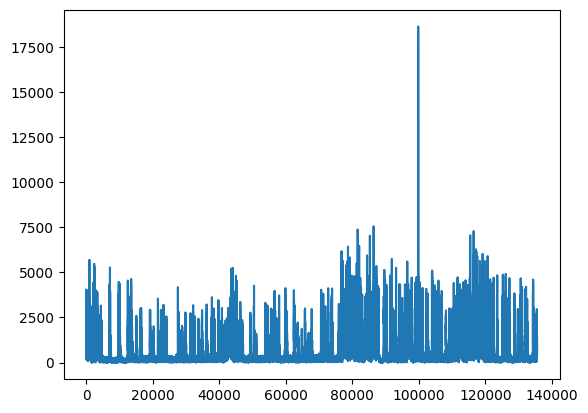

In [7]:
# create a dataframe with the accel data exclusively (command=3 and register address = 34)
df_acceldata_accel = df_acceldata.loc[df_acceldata['Command'] == 3].loc[df_acceldata['RegisterAddress'] == 34]

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math

fs = 200 #sampling frequency
f_cut = 1/(fs/2)

filter_order = 5
b, a = signal.butter(filter_order, f_cut, 'high')
w, h = signal.freqs(b, a)

#DataElement0 corresponds to Accel_x
x = df_acceldata_accel['DataElement0']
y = df_acceldata_accel['Accel_y']
z = df_acceldata_accel['Accel_z']

medfilt_order = 7
x = signal.medfilt(x, medfilt_order)
y = signal.medfilt(y, medfilt_order)
z = signal.medfilt(z, medfilt_order)

x_BA = signal.filtfilt(b, a, x)
y_BA = signal.filtfilt(b, a, y)
z_BA = signal.filtfilt(b, a, z)

array_sum_x = np.sum(x)
array_has_nan_x = np.isnan(array_sum_x)

array_sum_y = np.sum(y)
array_has_nan_y = np.isnan(array_sum_y)

array_sum_z = np.sum(z)
array_has_nan_z = np.isnan(array_sum_z)

print('Are there any null/none values in the x, y, or z acceldata?: {}'.format(array_has_nan_x+array_has_nan_y+array_has_nan_z))
if array_has_nan_x+array_has_nan_y+array_has_nan_z == False:
    print('No null values were found in the accelerometer data.')

x_GA = x - x_BA 
y_GA = y - y_BA
z_GA = z - z_BA

# metric: high-pass filter followed by the euclidian norm
# the original signal consisted in the three components of ...
# body+gravitational acceleration. After applying a filter, I computed the
# total body acceleration, from which movement initiations will be detected
# euclidian norm/vector magnitude
total_bodyaccel = np.sqrt(x_BA**2+y_BA**2+z_BA**2)
plt.plot(total_bodyaccel)

df_acceldata_accel['Total_accel'] = total_bodyaccel
df_acceldata_accel = df_acceldata_accel[['Command', 'RegisterAddress', 'Timestamp', 
                                         'DataElement0', 'Accel_y', 'Accel_z', 
                                         'Gyr_x', 'Gyr_y', 'Gyr_z', 
                                         'Magn_x', 'Magn_y', 'Magn_z', 
                                         'Counter', 
                                         'Total_accel']]


df_acceldata_accel.reset_index(inplace = True, drop = True)
df_acceldata_accel

#plt.plot(x)
#plt.plot(x_BA)

#plt.plot(y)
#plt.plot(y_BA)

#plt.plto(z)
#plt.plot(z_BA)

In [8]:
# the counter goes from 0 to 127, so by ploting the diff() it should be 1, 126 times followed by a -127, 1 time (repeated)
# any deviation from this pattern, means data loss, so lets find instances
# where counter.diff is different from 1 or -127!

# add 'ghost' rows,do a linear interpolation of the accel data in those rows so that no problem arises in the psth plots??
# add a flag to mark regions of the plot where data is missing?? (maybe not necessary since we are using the timestamps
# as the x axis!!!)

lost_data = df_acceldata_accel['Counter'].diff()

for i in range(len(lost_data)):
    if lost_data[i] == 1:
        lost_data[i] = 0
    elif lost_data[i] == -127:
        lost_data[i] = 0 

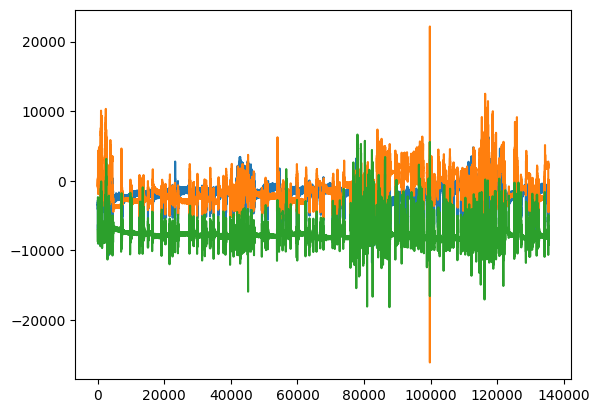

In [9]:
plt.plot(df_acceldata_accel['DataElement0']) # Accel_x
plt.plot(df_acceldata_accel['Accel_y'])
plt.plot(df_acceldata_accel['Accel_z'])

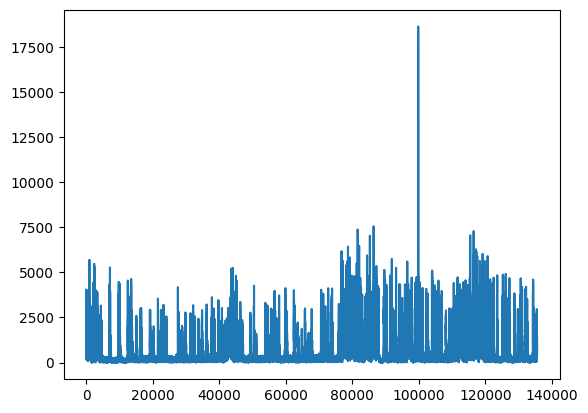

In [10]:
plt.plot(df_acceldata_accel['Total_accel'])

In [14]:
# final test to proceed for the camera and inscopix data (not really a test, more of a warning)
accel_TTL_correct = False
if sum(lost_data[1:]) > 0:
    accel_TTL_correct = True
    print('Some accel data was lost. This should not be problematic since the timestamps (x) will be used to plot the accel data (y). This means that, when plotting, the lost data will be linearly interpolated.')
    print('\nNow, let\'s check the timestamps from the camera!')
elif  sum(lost_data[1:]) == 0:
    accel_TTL_correct = True
    print('No lost data :). Now, let\'s check the timestamps from the camera!')

Some accel data was lost. This should not be problematic since the timestamps (x) will be used to plot the accel data (y). This means that, when plotting, the lost data will be linearly interpolated.

Now, let's check the timestamps from the camera!


#####  Camera timestamps...

In [15]:
# in the following steps I will need to check if the lenght of this df
# is coherent with the onces from DLC predictions, frame diff and velocities

# keep in mind that it is possible for the last TTL to have no correspondant frame (the TTL may have been send but the frame 
# was not recorded, for example) - furthermore, it is only problematic when the 'missing frame' is between the first and last
# inscopix TTL's, since that is the region that counts for the session (inscopix, camera and accel - ON)

df_acceldata_camera = df_acceldata.loc[df_acceldata['Command'] == 3].loc[df_acceldata['RegisterAddress'] == 37]

import math

camera_aq_rate = 30 #Hz
camera_period = round(1/camera_aq_rate, 3)

df_acceldata_camera = df_acceldata_camera[['Command','RegisterAddress','Timestamp','DataElement0']]
df_acceldata_camera = df_acceldata_camera.reset_index(drop=True)

camera_TTL_correct_temp = True
for camera_TTL in range(1,len(df_acceldata_camera)):
    if round(df_acceldata_camera['Timestamp'].diff()[camera_TTL], 2) != round(camera_period, 2):
        print('A frame was lost here :(')
        camera_TTL_correct_temp = False
if camera_TTL_correct_temp:
    print('The camera timestamps are correct. No frames were dropped :)')
    print('Now, let\'s check the timestamps from the Inscopix!')
    
df_acceldata_camera

The camera timestamps are correct. No frames were dropped :)
Now, let's check the timestamps from the Inscopix!


,Command,RegisterAddress,Timestamp,DataElement0
0,3.0,37.0,691550.9865,1.0
1,3.0,37.0,691551.0198,1.0
2,3.0,37.0,691551.0532,1.0
3,3.0,37.0,691551.0865,1.0
4,3.0,37.0,691551.1198,1.0
...,...,...,...,...
20307,3.0,37.0,692227.8594,1.0
20308,3.0,37.0,692227.8927,1.0
20309,3.0,37.0,692227.9261,1.0
20310,3.0,37.0,692227.9594,1.0


##### Inscopix timestamps...

This needs to match the neuron.mat data.

In [16]:
import math

df_acceldata_inscopix = df_acceldata.loc[df_acceldata['Command'] == 3].loc[df_acceldata['RegisterAddress'] == 35]

inscopix_aq_rate = 20 #Hz
inscopix_period = round(1/inscopix_aq_rate, 3)

df_acceldata_inscopix = df_acceldata_inscopix.reset_index(drop=True)
df_acceldata_inscopix = df_acceldata_inscopix[['Command','RegisterAddress','Timestamp','DataElement0']]

inscopix_aq_rate = 20 #Hz
inscopix_period = round(1/inscopix_aq_rate, 3)

df_acceldata_inscopix = df_acceldata_inscopix.reset_index(drop=True)

inscopix_TTL_correct = True
for inscopix_TTL in range(1,len(df_acceldata_inscopix)):
    if round(df_acceldata_inscopix['Timestamp'].diff()[inscopix_TTL], 3) != inscopix_period/2:
        print('Some TTL is missing :(')
        inscopix_TTL_correct = False
    
# I also need to check if the dimensions of the neuron data fit this 
# ...timestamps
if len(df_acceldata_inscopix[::2]) != calcium_length:
    inscopix_TTL_correct = False
    print('This data is not matching the neuron.mat data :(')
else:
    print('This data matches the data from the neuron.mat file :)')

df_acceldata_inscopix

This data matches the data from the neuron.mat file :)


,Command,RegisterAddress,Timestamp,DataElement0
0,3.0,35.0,691556.5616,17050.0
1,3.0,35.0,691556.5866,667.0
2,3.0,35.0,691556.6116,49817.0
3,3.0,35.0,691556.6366,33432.0
4,3.0,35.0,691556.6616,17049.0
...,...,...,...,...
26699,3.0,35.0,692224.2016,1101.0
26700,3.0,35.0,692224.2266,17482.0
26701,3.0,35.0,692224.2516,33866.0
26702,3.0,35.0,692224.2766,50254.0


##### Add timestamps to the 'neuron.mat' data...

In [17]:
df_inscopix_ts = df_acceldata['Timestamp'].loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==35][::2]
df_inscopix_ts.reset_index(inplace = True, drop = True)
df_calcium['Timestamp'] = df_inscopix_ts
df_calcium_raw['Timestamp'] = df_inscopix_ts

## 1.3 Import FrameDiff_Centroid.csv 
This file is important to check for lost frames.

In [19]:
path_framediff = "C:\\Users\\user\\Desktop\\42312_2F_W9\\42312_2F_W9_FrameDiff_Centroid2021-07-07T12_26_09.csv"
df_framediff = pd.read_csv(path_framediff, header=None)
df_framediff.rename(columns={0:'Frame diff'})

camera_TTL_correct = camera_TTL_correct_temp

import re
for index in range(len(df_framediff)):
    date = re.search(r' \d \d{4}-(0[1-9]|1[0-2])-(0[1-9]|[12][0-9]|3[01])', df_framediff.iloc[index][0])
    df_framediff.at[index, 'Frame diff'] = date.group()[1]

df_framediff = df_framediff.drop(0, axis = 1)
df_framediff['Frame diff'] = pd.to_numeric(df_framediff['Frame diff'])

# checking if the dimensions of this dataframe is coherent with TTLs from the camera

# keep in mind that it is possible for the last TTL to have no correspondant frame (the TTL may have been send but the frame 
# was not recorded, for example) - furthermore, it is only problematic when the 'missing frame' is between the first and last
# inscopix TTLs, since that is the region that counts for the session (inscopix, camera and accel - ON)
if len(df_acceldata.loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress'] == 37]) - (len(df_framediff)+1) > 1:
    camera_TTL_correct = False

# checks of there is a frame diff > 1, which would stand for 'lost frames' (somewhere on 'Command 3')
if int(np.sum(df_framediff.loc[df_framediff['Frame diff'] > 1])) == 0 and camera_TTL_correct:
    print('No frames were dropped :)')
else:
    print('The number of TTLs from the camera (acceldata), does not match the length of Frame_diff! It looks like some frames were dropped :(')

df_framediff

The number of TTLs from the camera (acceldata), does not match the length of Frame_diff! It looks like some frames were dropped :(


,Frame diff
0,1
1,1
2,1
3,1
4,1
...,...
20301,1
20302,1
20303,1
20304,1


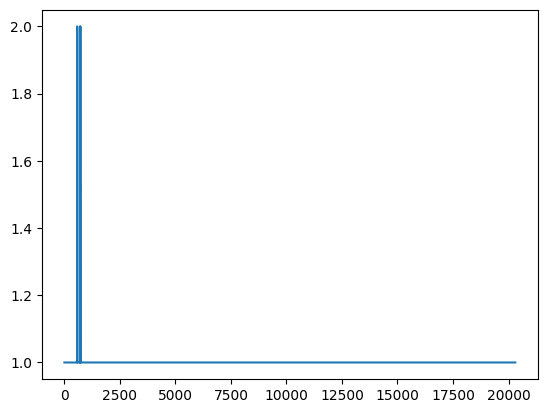

In [20]:
plt.plot(df_framediff['Frame diff'])

## 1.4 Import the video (processed) of the session

In [21]:
path_VideoProcessed = "C:\\Users\\user\\Desktop\\42312_2F_W9\\42312_2F_W9VideoProcessed2021-07-07T12_26_49.avi"
# start by checking the total number of frames in this video, which should match the length of the DLC predictions
import cv2
import numpy as np
vidcap = cv2.VideoCapture(path_VideoProcessed)
total_frames = vidcap.get(7) #returns the number of frames of the video
total_frames

20307.0

## 1.5 Import DLC predictions .csv
This is the file containing the x,y coordinates of the bodyparts of interest predicted by the DLC network. Each label is accompained by the likelihood of it being correct. 

In [73]:
path_predictions_DLC = "C:\\Users\\user\\Desktop\\42312_2F_W9\\42312_2F_W9VideoProcessed2021-07-07T12_26_49DLC_resnet50_Dystonia_TestApr21shuffle1_500000.csv"
df_DLC = pd.read_csv(path_predictions_DLC)
df_DLC = df_DLC.drop(columns='scorer')
df_DLC.iloc[0] + ' ' + '(' + df_DLC.iloc[1] + ')'
df_DLC.iloc[0] = df_DLC.iloc[0] + ' ' + '(' + df_DLC.iloc[1] + ')'
df_DLC.drop(index=1)
df_DLC.columns = df_DLC.iloc[0]
df_DLC = df_DLC.drop(index=0)
df_DLC = df_DLC.drop(index=1)
df_DLC.reset_index(inplace = True, drop = True)
for column in df_DLC.columns:
    df_DLC[column] = pd.to_numeric(df_DLC[column])

DLC_predictions_ready = False    
if len(df_DLC) == len(df_framediff)+1 == total_frames:
    print('The dataframe with DLC predictions is ready. The dimensions of this df match the total number of frames in the video :)')
    DLC_predictions_ready = True
else:
    print('The DLC predictions don\'t match the Frame diff')

# complete the dataframe by adding a column with the camera timestamps
camera_timestamps = df_acceldata['Timestamp'].loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==37]
camera_timestamps.reset_index(inplace = True, drop = True)
df_DLC['Timestamp'] = camera_timestamps

df_DLC #dataframe with the DLC predictions

C:\Users\user\AppData\Local\Temp\ipykernel_524\1833343049.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_DLC = pd.read_csv(path_predictions_DLC)


The dataframe with DLC predictions is ready. The dimensions of this df match the total number of frames in the video :)


,nose (x),nose (y),nose (likelihood),tailbase (x),tailbase (y),tailbase (likelihood),tailtip (x),tailtip (y),tailtip (likelihood),left_frontlimb_digitaltip (x),...,right_frontlimb_heel (x),right_frontlimb_heel (y),right_frontlimb_heel (likelihood),left_hindlimb_heel (x),left_hindlimb_heel (y),left_hindlimb_heel (likelihood),right_hindlimb_heel (x),right_hindlimb_heel (y),right_hindlimb_heel (likelihood),Timestamp
0,132.877655,237.355804,0.999004,148.686478,126.765045,0.999983,246.333710,63.704285,0.999995,120.559845,...,138.650833,200.160004,0.998536,122.967766,140.825272,0.993209,158.146988,149.332047,0.999726,691550.9865
1,130.385101,237.990204,0.998310,148.907440,126.725578,0.999982,245.704437,63.202831,0.999995,120.319023,...,138.610626,199.948685,0.998516,122.638641,141.011475,0.992486,158.418716,149.247726,0.999739,691551.0198
2,131.720428,238.262253,0.996458,148.717834,126.863869,0.999983,245.661819,63.271873,0.999995,121.297134,...,138.623825,200.263321,0.998503,122.691475,140.939499,0.992885,158.250504,149.100967,0.999755,691551.0532
3,132.004776,237.542450,0.994022,148.531540,126.756233,0.999985,246.340439,63.354183,0.999994,121.732597,...,138.621277,200.312912,0.998319,122.642448,140.917480,0.992530,158.142746,149.003876,0.999731,691551.0865
4,132.402893,237.025787,0.989956,148.639679,126.870354,0.999983,244.907288,62.468235,0.999995,121.599663,...,138.514603,200.133240,0.998222,122.645279,140.822876,0.992028,158.142105,149.082764,0.999717,691551.1198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20302,220.658493,73.561111,0.999331,128.061203,96.311653,0.999488,203.458923,45.182510,0.996420,202.123688,...,196.494781,69.432693,0.999079,156.012833,110.321609,0.999684,146.936050,71.138763,0.999902,692227.6928
20303,219.716888,72.241753,0.999420,128.139740,96.349449,0.999519,203.276459,45.012440,0.992346,202.332840,...,196.731003,68.342232,0.999581,156.067093,110.433449,0.999666,147.641510,71.228249,0.999903,692227.7261
20304,220.720779,70.118774,0.999567,128.203735,96.600723,0.999589,202.540222,44.155357,0.951694,204.921326,...,197.733856,66.535416,0.999835,156.625290,109.955315,0.999732,148.329483,71.463005,0.999941,692227.7594
20305,221.808334,69.589432,0.999884,128.036865,96.541321,0.999537,202.133499,43.696590,0.888104,206.133392,...,197.807144,65.561806,0.999860,156.415115,109.842903,0.999728,147.946320,71.474731,0.999949,692227.7928


In [74]:
#don't run this cell more than once (if you did, re-run the previous cell before running the present one)
import numpy as np
df_vel = df_DLC.copy(deep=False)

for column in df_vel.columns:
    if ('likelihood' and 'Timestamp') not in column :
        df_vel[column] = np.abs(df_vel[column].diff())

my_list=[]
for col in df_vel.columns:
    if 'likelihood' not in col:
        my_list.append('Vel - ' + col)

for col in df_vel.columns:
    for new_name in my_list:
        if col in new_name:
            df_vel.rename({col:new_name}, axis=1, inplace=True)
            
for col in df_vel.columns:
    if '(likelihood)' in col:
        loc = df_vel.columns.get_loc(col)
        V_xy = np.sqrt(df_vel[df_vel.columns[loc-2]]**2+df_vel[df_vel.columns[loc-1]]**2)
        name_column = 'V_xy_'+df_vel.columns[loc].split(" ")[0]
        df_vel.insert(loc, name_column, V_xy)

# I dropped the first row (NaN values) since, every row represents a diff between the coordinates of consecutive frames
df_vel = df_vel.drop(index=0)
df_vel.reset_index(inplace = True, drop = True)
        
# programm a green sign test to see if everything is ok with the data from 
# the current step
Velocity_data_ready = False
if len(df_framediff)+1 == len(df_vel)+1 == len(df_DLC):
    print('The dimensions of the frame diff, DLC predictions and bodypart velocity dataframes are coherent :)')
    Velocity_data_ready = True
else:
    print('The dimensions of the frame diff, DLC predictions and bodypart velocity dataframes are NOT coherent :(')
    
df_vel #dataframe with the velocities (x, y and absolute - px/frame) obtained from the DLC predictions

The dimensions of the frame diff, DLC predictions and bodypart velocity dataframes are coherent :)


,Vel - nose (x),Vel - nose (y),V_xy_nose,nose (likelihood),Vel - tailbase (x),Vel - tailbase (y),V_xy_tailbase,tailbase (likelihood),Vel - tailtip (x),Vel - tailtip (y),...,right_frontlimb_heel (likelihood),Vel - left_hindlimb_heel (x),Vel - left_hindlimb_heel (y),V_xy_left_hindlimb_heel,left_hindlimb_heel (likelihood),Vel - right_hindlimb_heel (x),Vel - right_hindlimb_heel (y),V_xy_right_hindlimb_heel,right_hindlimb_heel (likelihood),Vel - Timestamp
0,2.492554,0.634399,2.572020,0.000695,0.220963,0.039467,0.224460,1.072884e-06,0.629272,0.501453,...,0.000020,0.329124,0.186203,0.378146,0.000723,0.271729,0.084320,0.284511,0.000013,691551.0198
1,1.335327,0.272049,1.362758,0.001852,0.189606,0.138290,0.234680,9.536743e-07,0.042618,0.069042,...,0.000013,0.052834,0.071976,0.089285,0.000400,0.168213,0.146759,0.223235,0.000016,691551.0532
2,0.284348,0.719803,0.773931,0.002435,0.186295,0.107635,0.215154,2.145767e-06,0.678619,0.082310,...,0.000184,0.049026,0.022018,0.053744,0.000356,0.107758,0.097092,0.145046,0.000024,691551.0865
3,0.398117,0.516663,0.652256,0.004066,0.108139,0.114120,0.157218,2.503395e-06,1.433151,0.885948,...,0.000097,0.002831,0.094604,0.094647,0.000501,0.000641,0.078888,0.078891,0.000014,691551.1198
4,8.673706,1.863113,8.871548,0.004894,0.230804,0.566360,0.611584,4.410744e-06,0.130753,0.694172,...,0.000351,0.016716,0.278732,0.279233,0.001542,0.183975,0.244705,0.306150,0.000072,691551.1532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20301,1.728699,1.808624,2.501903,0.000600,0.033157,0.473091,0.474252,1.385212e-04,0.353592,0.571922,...,0.005079,0.053955,0.015266,0.056073,0.000060,0.071487,0.146271,0.162805,0.000022,692227.6928
20302,0.941605,1.319359,1.620903,0.000089,0.078537,0.037796,0.087158,3.099442e-05,0.182465,0.170071,...,0.000502,0.054260,0.111839,0.124307,0.000018,0.705460,0.089485,0.711112,0.000001,692227.7261
20303,1.003891,2.122978,2.348368,0.000147,0.063995,0.251274,0.259295,6.979704e-05,0.736237,0.857082,...,0.000254,0.558197,0.478134,0.734980,0.000066,0.687973,0.234756,0.726923,0.000038,692227.7594
20304,1.087555,0.529343,1.209537,0.000317,0.166870,0.059402,0.177128,5.179644e-05,0.406723,0.458767,...,0.000024,0.210175,0.112411,0.238348,0.000004,0.383163,0.011726,0.383343,0.000008,692227.7928


## 1.6 Import TimestampInscopix.csv
This file is probably not going to be used.
I think it represents the inscopix timestamps that should be used!

In [22]:
path_timestamp_inscopix = "C:\\Users\\user\\Desktop\\42312_2F_W9\\42312_2F_W9TimestampInscopix2021-07-07T12_26_09.csv"
df_timestamp_inscopix = pd.read_csv(path_timestamp_inscopix, header=None)
df_timestamp_inscopix

,0
0,True 2021-07-07T12:26:54.7417472+01:00
1,False 2021-07-07T12:26:54.7614720+01:00
2,True 2021-07-07T12:26:54.7864192+01:00
3,False 2021-07-07T12:26:54.8115328+01:00
4,True 2021-07-07T12:26:54.8369024+01:00
...,...
26699,False 2021-07-07T12:38:02.4074624+01:00
26700,True 2021-07-07T12:38:02.4321920+01:00
26701,False 2021-07-07T12:38:02.4570752+01:00
26702,True 2021-07-07T12:38:02.4822144+01:00


---

## Final test before proceeding

In [ ]:
# have a bool variable the gives an overall approval of the data for analysis
# for example, if everything is ok, all dimensions, no missed data, etc
# it should be TRUE
can_advance = False

tests = [neuron_data_ready, raw_neuron_data_ready, accel_TTL_correct, camera_TTL_correct, inscopix_TTL_correct, DLC_predictions_ready, Velocity_data_ready]

if sum(tests) == len(tests):
    can_advance = True
    print('Data is ready for analysis :)')
else:
    print('Either there is missing data or you haven\'t yet run all the necessary cells preceding the analysis!')

first_TTL_inscopix = df_acceldata.loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==35].index[0]
last_TTL_inscopix = df_acceldata.loc[df_acceldata['Command']==3].loc[df_acceldata['RegisterAddress']==35].index[-1]

if can_advance:
    # this df contains the TTL information of the session (from the first to the last inscopix TTL)
    df_session = df_acceldata[first_TTL_inscopix:last_TTL_inscopix+1]
    df_session.reset_index(inplace = True, drop = True)
df_session

I think I don't need the df_session dataframe. The first_TTL_inscopix and the last_TTL_inscopix will allow me to build the plots containing only information from the session :)

---

# 2. Align initiations to neuronal data

### This should be divided in two main problems:
##### A) Initiation detection (more technical problem)
Which of the lesioned paw initiations (DLC velocity) are 'associated' with initiations from the accelerometer?
##### B) Alignment itself (more scientific problem)
To what should I align the initiations; Groups of neurons?, and should they always fire?, ... ; What are the scientific questions I want answered? (psth)

### ...from now on, you should only consider the data from the first to the last Inscopix TTL

In [28]:
# build a function that calculates moving averages
# the result will have a len = len(original data) - (window - 1)
import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# A)

## 2.1 Detection itself

## 2.1.1 Detecting initiations using the accelerometer data

In [29]:
# this window should be carefully tuned
filtering_window = 20
accel_filtered = moving_average(df_acceldata_accel['Total_accel'], filtering_window)

In [32]:
'''plt.plot(df_acceldata_accel['Total_accel'])
plt.plot(accel_filtered)'''

# filtered 'total_body_accel' aligned to the not-filtered 'total_body_accel' 
plt.plot(df_acceldata_accel['Total_accel'])
plt.plot(range(19, len(df_acceldata_accel)), accel_filtered)

### Initiations - total body acceleration (original)

###### Local minimum between the two modes of a bimodal distribution...

In [33]:
#consider a movement initiation every time the acceleration raises above 
#...the beginning of a local minimum in the log distribution of total body accelerations
#...the local minimum is to be found in the valley forming the two peaks of
#...the log_scale distribution

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# raw acceleration data (total body acceleration)
ax = sns.kdeplot(df_acceldata_accel['Total_accel'], log_scale=True)

kde_curve = ax.lines[0]

x = kde_curve.get_xdata()
y = kde_curve.get_ydata()

plt.plot(x, y)
peaks = np.where((y[1:-1] > y[0:-2]) * (y[1:-1] > y[2:]))[0] + 1
dips = np.where((y[1:-1] < y[0:-2]) * (y[1:-1] < y[2:]))[0] + 1

plt.plot(x, y, color='cyan')
plt.plot(x[peaks], y[peaks], 'o')
plt.plot(x[dips], y[dips], 'o')
plt.show()

for i in range(len(peaks)):
    # this is tricky, since some distributions may be multimodal
    # ...or have multiple local minimums which would make this computation not trivial
    cutOff_accel = x[dips[1]]
    break
print(cutOff_accel)

11982.773177456591


In [46]:
# movement bouts detected from the accelerometer data
moving_accel = []
for timestamp in range(len(df_acceldata_accel['Total_accel'])):
    if df_acceldata_accel['Total_accel'][timestamp] >= cutOff_accel:
        moving_accel.append(1)
    else:
        moving_accel.append(0)

###### Crossing point between two gaussians fitted to the kernel density estimation... (not correct yet)

In [37]:
# obtain the treshold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(df_acceldata_accel['Total_accel']), bins=100, color='lightblue')

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (5, .1, max(y)/2, 7, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='orange')

cutOff_cg = intersection.xy[0][0]
cutOff_cg #not the real cutoff since I used the log o the data

6.323326771417857

In [38]:
# obtain periods of movement (cg - cross gaussian)
moving_accel_cg = []
for timestamp in range(len(df_acceldata_accel['Total_accel'])):
    if np.log(df_acceldata_accel['Total_accel'][timestamp]) >= cutOff_cg:
        moving_accel_cg.append(1)
    else:
        moving_accel_cg.append(0)

### Initiations - total body acceleration (filtered)

##### Local minimum between the two modes of a bimodal distribution...

In [39]:
#consider a movement initiation every time the acceleration raises above 
#...the beginning of a local minimum in the log distribution of total body accelerations
#...the local minimum is to be found in the valley forming the two peaks of
#...the log_scale distribution

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# raw acceleration data (total body acceleration)
ax = sns.kdeplot(accel_filtered,  log_scale=True)

kde_curve = ax.lines[0]

x = kde_curve.get_xdata()
y = kde_curve.get_ydata()

plt.plot(x, y)
peaks = np.where((y[1:-1] > y[0:-2]) * (y[1:-1] > y[2:]))[0] + 1
dips = np.where((y[1:-1] < y[0:-2]) * (y[1:-1] < y[2:]))[0] + 1

plt.plot(x, y, color='cyan')
plt.plot(x[peaks], y[peaks], 'o')
plt.plot(x[dips], y[dips], 'o')
plt.show()

for i in range(len(peaks)):
    # this is tricky, since some distributions may be multimodal
    cutOff_accel_filtered = x[dips[0]]
    break
print(cutOff_accel_filtered)

456.69953999539183


In [40]:
moving_accel_filtered = []
for timestamp in range(len(accel_filtered)):
    if accel_filtered[timestamp] >= cutOff_accel_filtered:
        moving_accel_filtered.append(1)
    else:
        moving_accel_filtered.append(0)

##### Crossing point between two gaussians fitted to the kernel density estimation...

In [43]:
# obtain the treshold 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(accel_filtered), bins=100, color='lightblue')

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (5, .1, max(y)/2, 7, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='orange')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_filtered_cg = intersection.xy[0][0]
cutOff_filtered_cg 

6.036234168692883

In [44]:
# obtain periods of movement (cg - cross gaussian)
moving_accel_filtered_cg = []
for timestamp in range(len(accel_filtered)):
    if np.log(accel_filtered[timestamp]) >= cutOff_filtered_cg:
        moving_accel_filtered_cg.append(1)
    else:
        moving_accel_filtered_cg.append(0)

##### Comparing the two (original vs filtered total body acceleration) ...

In [47]:
# Local minimum between the two modes of a bimodal distribution...
plt.plot(moving_accel)
plt.plot(moving_accel_filtered)

In [48]:
# crossing point between the two gaussians (cg - cross gaussian)
plt.plot(moving_accel_cg)
plt.plot(moving_accel_filtered_cg)

In [49]:
import scipy.stats as st

plt.plot(st.zscore(df_acceldata_accel['Total_accel']))
plt.plot(st.zscore(accel_filtered))
plt.plot(st.zscore(moving_accel_filtered_cg))

##### Trying to work out the criteria for defining initiations from the acceleration data based on the 0/1s defined from the crossing point of two gaussians...
**First Approach:** 300 ms of log(acceleration) under the selected treshold, followed by 500 ms of log(acceleration) above the treshold.

In [50]:
len(moving_accel_cg)-len(moving_accel_filtered_cg) #with a 20 window moving average filter (low pass)

19

In [51]:
# create an arrary with the sequence of interest
# fs # accel sampling rate
sec_stopped = 0.3 #300 ms
num_points_stopped = fs*sec_stopped

sec_moving = 0.5 #500 ms
num_points_moving = fs*sec_moving

sequence_0_1 = (num_points_stopped, num_points_moving)
sequence=np.concatenate([np.zeros(int(sequence_0_1[0])),np.ones(int(sequence_0_1[1]))])

# iterate through the moving_accel_filtered_cg to find the places where the sequence is found
movement_initiations_accel = []
index_first_element_last_seq = len(moving_accel_filtered_cg)-len(sequence)
for timestamp in range(index_first_element_last_seq + 1): # because range excludes the last value
    if sum(moving_accel_filtered_cg[timestamp:timestamp+len(sequence)] == sequence) == len(sequence):
        movement_initiations_accel.append(timestamp+(sequence_0_1[0]-1)) #+(sequence_0_1[0]-1) considers the last zero as the initiation; +sequence_0_1[0] considers the first 1 as the init
print('The number of initiations detected using the accelerometer is: {}'.format(len(movement_initiations_accel)))

# correct the shift associated to the filtering process
initiations_accel_corrected = []
for init in movement_initiations_accel:
    initiations_accel_corrected.append(init+(filtering_window-1))
if len(initiations_accel_corrected) == len(movement_initiations_accel):
    print('\nThe initiations were corrected according to the window of the filter used :)')

# plot only the periods of movement that fulfill the criteria/sequence

# the end - you now have the initiations detected from the accelerometer :)

The number of initiations detected using the accelerometer is: 86

The initiations were corrected according to the window of the filter used :)


###### Skip till section 2.1.1.1
This is for detecting a complete movement bout... not finished!

In [ ]:
# descobrir indices onde o diff do indice+1 e igual a '-1', ou seja, desocbri a sequencia e depois dentro dessa sequencia
# so vai a zero quando o original for a zero. assim nao estou a plotar apenas a sequencia mas o movimento original

moving_accel_filtered_cg_diff = []
for i in range(len(moving_accel_filtered_cg)):
    moving_accel_filtered_cg_diff.append(moving_accel_filtered_cg[i]-moving_accel_filtered_cg[i-1])

end_movement_sequences = []
for i in range(len(moving_accel_filtered_cg_diff)):
    if moving_accel_filtered_cg_diff[i] == -1:
        end_movement_sequences.append(i-1)

In [ ]:
end_movement_sequences = []
for i in range(len(moving_accel_filtered_cg_diff)):
    if moving_accel_filtered_cg_diff[i] == -1:
        end_movement_sequences.append(i-1)

In [ ]:
# plot only the periods of movement that fulfill the criteria/sequence - it is only coded to plot the sequence and not the 
# whole movin period
movement_plot = np.zeros(len(moving_accel_filtered_cg))
index_first_element_last_seq = len(moving_accel_filtered_cg)-len(sequence)
for timestamp in range(index_first_element_last_seq + 1): # because range excludes the last value
    if sum(moving_accel_filtered_cg[timestamp:timestamp+len(sequence)] == sequence) == len(sequence):
        movement_plot[timestamp:timestamp+len(sequence)] = sequence

In [ ]:
plt.plot(movement_plot)

### 2.1.1.1 Plot - superimposing movement initiations

##### Start by linearly interpolating the missing data...

In [52]:
# the diff() values of the timestamps are ideally multiples of the period of the signal, however it should be noted that 
# the real values are not perfect multiples

# let's build a function that finds the nearest multiple of the accel's period, so that we can find the number of missing 
# 'timestamps' as (accel_ts/period - 1) - so, for example, a diff of 0.015 will stand for 2 missing ts
def closestMultiple(n, x):
    if x >= n:
        return round(x/n)*n;
    else:
        return math.ceil(x/n)*n;

In [53]:
period_accel = 1/fs
round_accel_ts = []
for i in range(1, len(df_acceldata_accel)):
    round_accel_ts.append(closestMultiple(period_accel, df_acceldata_accel['Timestamp'].diff()[i]))

In [54]:
round_accel_ts

[0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,


In [55]:
missing_accel_ts = [0]
for diff in round_accel_ts:
    missing_accel_ts.append(diff/period_accel-1)
    
total_accel_interpolation = []
for missing, total_accel in zip(missing_accel_ts, df_acceldata_accel['Total_accel']):
    if missing == 0:
        total_accel_interpolation.append(total_accel)
    else:
        for i in range(int(missing)):
            total_accel_interpolation.append(-1000)
        total_accel_interpolation.append(total_accel)
            
if len(total_accel_interpolation)-len(missing_accel_ts) == sum(missing_accel_ts):
    print('We know where data is missing and the new array of accelerations was created correctly :). Now, I shall assign a linearly interpolated value of aceleration to every -1000!')
else:
    print('There is something wrong. Do not proceed until this criteria is met!')

We know where data is missing and the new array of accelerations was created correctly :). Now, I shall assign a linearly interpolated value of aceleration to every -1000!


In [56]:
# finds the indices where the missing that is and assigns it the average point using the previous and the next accel values
# if the number of missing timestamps is higher than one, compute the average point and than two other average point 
# ... (previous_non_negative to average and average to next_non_negative)

# only works for non-consecutive missing data
orig_idx_missing_data = []
for i, accel_inst in zip(range(len(total_accel_interpolation)), total_accel_interpolation):
    if accel_inst < 0 and total_accel_interpolation[i-1] >= 0 and total_accel_interpolation[i+1] >= 0:
        orig_idx_missing_data.append(i)
        total_accel_interpolation[i] = (total_accel_interpolation[i+1]+total_accel_interpolation[i-1])/2
        #print(i, accel_inst, total_accel_interpolation[i])
        
still_missing = []
for i, accel_inst in zip(range(len(total_accel_interpolation)), total_accel_interpolation):
    if accel_inst < 0:
        still_missing.append(i)
        #print(i)
        orig_idx_missing_data.append(i)
        
still_missing = np.array(still_missing)
still_missing = still_missing.reshape((int(len(still_missing)/2), 2))

for tuple_missing in still_missing:
    average_point = (total_accel_interpolation[tuple_missing[0]-1]+total_accel_interpolation[tuple_missing[1]+1])/2
    #print(average_point)
    first_tuple = (total_accel_interpolation[tuple_missing[0]-1]+average_point)/2
    #print(first_tuple)
    second_tuple = (average_point+total_accel_interpolation[tuple_missing[1]+1])/2
    #print(second_tuple)
    total_accel_interpolation[tuple_missing[0]] = first_tuple
    total_accel_interpolation[tuple_missing[1]] = second_tuple
    #print(total_accel_interpolation[tuple_missing[0]], total_accel_interpolation[tuple_missing[1]])
    
if -1000 not in total_accel_interpolation:
    print('All missing data was linearly interpolated.')
    print("\nNow that we've corrected the acceleration signal, let's plot the initiations detected -+ 8 seconds")
    
# IMPORTANT: this code assumes a maximum of 2 consecutive timestamps missing, if an error in this step emerges for other 
# videos, the first thing to check would be if there is 3 or more consecutive missing ts's in the accel data

All missing data was linearly interpolated.

Now that we've corrected the acceleration signal, let's plot the initiations detected -+ 8 seconds


##### Plot

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

for init_corrected in initiations_accel_corrected:
    if init_corrected < fs*8:
        plt.plot(range(-init_corrected, end_plot), total_accel_interpolation[0:init_corrected+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(total_accel_interpolation) - init_corrected < fs*8:
        plt.plot(range(int(beg_plot), int(len(total_accel_interpolation)-init_corrected)), total_accel_interpolation[int(init_corrected+beg_plot) : int(len(total_accel_interpolation)+end_plot)])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), total_accel_interpolation[int(init_corrected+beg_plot):int(init_corrected+end_plot)])
        count_3+=1
        
plt.title('Movement initiation obtained from the total body acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(initiations_accel_corrected))

### 2.1.1.2 Plot - average of the initiations above 

In [59]:
import math

df_initiations_accel_sequence_interest = pd.DataFrame()

time_sec = 2
# initiation minus 8 sec
beg_plot = -fs*time_sec
# initiation plus 8 sec
end_plot = fs*time_sec+1

for init_corrected in initiations_accel_corrected:
    if init_corrected < fs*time_sec:
        arr = np.array(total_accel_interpolation[0:int(init_corrected+end_plot)])
        zeros_ = (fs*time_sec*2+1) - len(arr)
        df_initiations_accel_sequence_interest[init_corrected] = np.concatenate((np.zeros(zeros_), arr))
    elif len(total_accel_interpolation) - init_corrected < fs*time_sec:
        arr = np.array(total_accel_interpolation[int(init_corrected+beg_plot):int(len(total_accel_interpolation)+1)])
        zeros_ = (fs*time_sec*2+1) - len(arr)
        df_initiations_accel_sequence_interest[init_corrected] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(total_accel_interpolation[int(init_corrected+beg_plot):int(init_corrected+end_plot)])
        df_initiations_accel_sequence_interest[init_corrected] = arr

mean_accel = df_initiations_accel_sequence_interest.mean(axis=1)

std_accel = df_initiations_accel_sequence_interest.std(axis=1)

std_error_accel = std_accel/math.sqrt(len(initiations_accel_corrected))

df_initiations_accel_sequence_interest

,748.0,2026.0,2894.0,4393.0,9703.0,12496.0,15031.0,16329.0,19132.0,20216.0,...,114573.0,118100.0,121773.0,122171.0,123464.0,128632.0,129698.0,130414.0,131854.0,132459.0
0,1367.459687,186.031125,2714.900644,330.672276,123.069630,140.677759,125.249021,169.179621,95.680524,292.964444,...,536.405165,4085.716594,1731.558086,59.239010,270.989161,129.048379,118.886202,333.400407,160.160885,588.350070
1,1371.147079,247.341232,2834.035081,193.199576,161.138284,140.499832,90.194093,142.279901,89.010025,292.411588,...,509.026153,4249.266901,1730.193145,91.842955,279.390056,143.752276,169.731028,348.503090,161.748165,917.982756
2,1070.111814,244.616556,2891.409434,179.269832,162.727919,140.741001,74.664222,94.250157,91.684016,291.863049,...,466.040714,4209.711318,1635.251786,122.407853,301.851105,217.534191,171.025566,341.753155,106.245610,1585.038385
3,353.166620,137.416239,3017.303224,187.465143,170.287284,138.500472,55.672733,88.902398,93.247485,280.462778,...,377.899793,4201.507686,1631.778120,185.993420,162.005503,167.816777,169.624242,330.399615,267.574431,1693.470754
4,793.248837,135.180615,3314.224867,190.174505,170.333214,119.119024,62.728404,89.070943,127.448569,230.136303,...,392.048939,4193.066034,1551.498925,240.484323,158.686375,250.694264,145.855079,295.549882,301.567909,2019.363738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1211.156286,4727.232280,839.647173,196.191953,2476.287809,147.413459,78.310247,63.624056,104.917015,82.425785,...,937.972511,1404.867100,168.538305,822.962636,66.685621,141.109333,161.351476,356.412094,613.576744,253.661153
797,1335.478183,3892.895600,804.243734,196.347625,1863.249950,236.880384,75.913533,59.753036,166.437074,98.899493,...,877.709213,1286.828000,182.076845,888.461735,87.621296,144.090596,161.187566,357.931729,572.463137,248.995137
798,1967.390493,1511.532054,959.106209,225.083837,1040.611681,350.784983,73.395258,70.190401,164.860296,135.084056,...,508.645722,1671.884670,213.552267,1043.122896,136.229744,142.210220,159.173968,300.779174,553.101351,262.673670
799,2425.368378,1993.792268,1116.679398,223.512409,630.411943,391.786431,121.713696,95.494435,163.562927,143.237115,...,485.850710,2002.500438,284.475111,1023.310131,170.717889,75.942703,137.521148,245.856930,549.615489,315.109001


In [61]:
# Important to look at these line!!!
# example of initiation

df_initiations_accel_sequence_interest[748.0][fs*time_sec] == total_accel_interpolation[748] #CORRECT

True

##### Plot

In [63]:
time_sec=2
# initiation minus 8 sec
beg_plot = -fs*time_sec
# initiation plus 8 sec
end_plot = fs*time_sec+1

plt.plot(range(beg_plot, end_plot), df_initiations_accel_sequence_interest.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2)

plt.title('Movement initiation obtained from the total body acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', "alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

### 2.1.1.3 Right hindlimb heel velocity aligned to the initiations detected using the total body acceleration data

In [69]:
# in order to see the velocity aligned to the initiations detected using the accelerometer data, I need to interpolate the 
# timestamps, for the indexes where there was missing data, and use the timestamps to plot the psth of velocities when 
# there is an initiation detection with the acceleration data
timestamps_accel_interpolation = list(df_acceldata_accel['Timestamp'])
for i in range(0,25):
    timestamps_accel_interpolation.append(timestamps_accel_interpolation[247596]+period_accel*(i+1))
df_timestamps_accel_interpolation = pd.DataFrame(timestamps_accel_interpolation)
df_timestamps_accel_interpolation = df_timestamps_accel_interpolation.rename(columns={0:'Timestamps'})
df_timestamps_accel_interpolation['Total_accel'] = total_accel_interpolation

#initiations_accel_corrected
df_timestamps_accel_interpolation

IndexError: list index out of range

In [70]:
# get the timestamps of the initiations - accelerometer
ts_initiations_accel = []
for i in range(len(df_acceldata_accel['Timestamp'])):
    if i in initiations_accel_corrected:
        ts_initiations_accel.append(df_acceldata_accel['Timestamp'][i])

In [71]:
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return arr[idx]    

In [75]:
closest_ts_to_accel_init = []
for ts in ts_initiations_accel:
    closest_ts = find_closest(df_vel['Vel - Timestamp'], ts)
    closest_ts_to_accel_init.append(closest_ts)
    
indices_closest_ts_to_accel_init = []
for ts in closest_ts_to_accel_init:
    indices_closest_ts_to_accel_init.append(df_vel['Vel - Timestamp'].loc[df_vel['Vel - Timestamp']==ts])
    
for i, j in zip(indices_closest_ts_to_accel_init, range(len(indices_closest_ts_to_accel_init))):
    indices_closest_ts_to_accel_init[j] = i.index[0] 
    
# this array represents the indices of the velocity (right_hindlimb_heel) whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_closest_ts_to_accel_init

[112,
 303,
 433,
 658,
 1454,
 1872,
 2253,
 2447,
 2867,
 3030,
 3230,
 3364,
 3469,
 3607,
 4130,
 4236,
 4314,
 4471,
 4696,
 4802,
 4875,
 5049,
 5213,
 5420,
 5641,
 5748,
 5956,
 6111,
 6231,
 6704,
 6891,
 6993,
 7386,
 7550,
 7652,
 8159,
 8321,
 8466,
 8563,
 8681,
 9035,
 9527,
 9704,
 9847,
 10020,
 10149,
 10671,
 10763,
 10893,
 11050,
 12285,
 12538,
 12844,
 13400,
 13522,
 13683,
 13758,
 14098,
 14220,
 14349,
 14878,
 15019,
 15142,
 15309,
 15388,
 15686,
 15745,
 15844,
 15911,
 16003,
 16195,
 16348,
 16415,
 16510,
 16802,
 17043,
 17175,
 17703,
 18254,
 18313,
 18507,
 19282,
 19442,
 19549,
 19765,
 19856]

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

# -8 segundos
beg_plot = -240
# +8 segundos
end_plot = 241

for index in indices_closest_ts_to_accel_init:
    if index < 240:
        plt.plot(range(-index, end_plot), df_vel['V_xy_right_hindlimb_heel'][0:index+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(df_vel) - index < 240:
        plt.plot(range(beg_plot, len(df_vel)-index), df_vel['V_xy_right_hindlimb_heel'][index+beg_plot : len(df_vel)+end_plot])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), df_vel['V_xy_right_hindlimb_heel'][index+beg_plot:index+end_plot])
        count_3+=1
        
plt.title('Velocity of the right hindlimb heel aligned to accelerometer initiations')
plt.xlabel('Time (fr)')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(indices_closest_ts_to_accel_init))

In [ ]:
import math

df_velocities_aligned_to_accel = pd.DataFrame()

camera_aq_rate = 30 #Hz

time_sec = 2
beg_plot = -camera_aq_rate*time_sec
end_plot = camera_aq_rate*time_sec+1

for index in indices_closest_ts_to_accel_init:
    if index < camera_aq_rate*time_sec:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][0:int(index+end_plot)])
        zeros_ = (camera_aq_rate*time_sec+1) - len(arr)
        df_velocities_aligned_to_accel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_vel['V_xy_right_hindlimb_heel']) - index < camera_aq_rate*time_sec:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][int(index+beg_plot):int(len(df_vel['V_xy_right_hindlimb_heel'])+1)])
        zeros_ = (camera_aq_rate*time_sec+1) - len(arr)
        df_velocities_aligned_to_accel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][int(index+beg_plot):int(index+end_plot)])
        df_velocities_aligned_to_accel[index] = arr

mean_velocity = df_velocities_aligned_to_accel.mean(axis=1)

std_velocity = df_velocities_aligned_to_accel.std(axis=1)

std_error_velocity = std_velocity/math.sqrt(len(indices_closest_ts_to_accel_init))

df_velocities_aligned_to_accel

In [ ]:
# Important to look at these line!!!
# example of initiation

df_velocities_aligned_to_accel[1024][60] == df_vel['V_xy_right_hindlimb_heel'][1024] #CORRECT

In [ ]:
plt.plot(range(beg_plot, end_plot), df_velocities_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2)

plt.title('Velocity psth aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

##### Plot the initiations detected using the acceleration data, as well as the velocities aligned to the moments of initiation 

In [ ]:
plt.subplot(2,1,1)
mean_accel = df_initiations_accel_sequence_interest.mean(axis=1)

std_accel = df_initiations_accel_sequence_interest.std(axis=1)

std_error_accel = std_accel/math.sqrt(len(initiations_accel_corrected))

# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

plt.plot(range(beg_plot, end_plot), df_initiations_accel_sequence_interest.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2)

plt.title('Movement initiation obtained from the total body acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

#########################################################################################################################
plt.subplot(2,1,2)
mean_velocity = df_velocities_aligned_to_accel.mean(axis=1)

std_velocity = df_velocities_aligned_to_accel.std(axis=1)

std_error_velocity = std_velocity/math.sqrt(len(indices_closest_ts_to_accel_init))

# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_velocities_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2)

plt.title('Velocity aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

## 2.1.2 Detecting initiations using the velocities (DLC predictions) - right hind paw

Define a criteria with the likelihood of the DLC predictions (for example, only consider initiations in which all the elements of the sequence of interest (300 ms stoped and 500 ms moving) have a likelihood of at least 0.99) - round the likelihoods to 2 decimal cases -> on the current version, not criteria was yet implemented regarding likelihood of DLC predictions

In [ ]:
# build a new dataframe containing the V_xy filtered with a window of 10 
# frames for detection of movement bouts
df_vel_filtered = pd.DataFrame()

window_vel_filtered = 10
for column in df_vel.columns:
    if 'V_xy' in column:
        velocity_filtered = moving_average(df_vel[column], window_vel_filtered)
        df_vel_filtered[column] = velocity_filtered
    elif 'likelihood' in column:
        df_vel_filtered[column] = df_vel[column]
        
if len(df_vel_filtered) == len(df_vel)-(window_vel_filtered-1):
    print('The dataframe with the filtered velocities has the correct length.')
else:
    print('The length of the dataframe with the filtered velocities is incorrect!')

df_vel_filtered['Timestamp'] = df_vel['Vel - Timestamp'][:-9]
    
df_vel_filtered

##### Local minimum between the two modes of a bimodal distribution (ideally) ...

In [ ]:
#consider a movement initiation every time the velocity raises above 
#...the beginning of a local minimum in the log distribution of velocities
#...the local minimum is to be found in the valley forming the two peaks of
#...the log_scale distribution

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# velocity regularly calculated (from the original predicitons of x,y)
ax1_heel = sns.kdeplot(df_vel['V_xy_right_hindlimb_heel']+0.000001, log_scale = True)
# velocity filtered using a simple moving average of 10 frames 
ax2_heel = sns.kdeplot(df_vel_filtered['V_xy_right_hindlimb_heel'], log_scale=True)

kde_curve1_heel = ax1_heel.lines[0]
kde_curve2_heel = ax2_heel.lines[1]

x1_heel = kde_curve1_heel.get_xdata()
y1_heel = kde_curve1_heel.get_ydata()

x2_heel = kde_curve2_heel.get_xdata()
y2_heel = kde_curve2_heel.get_ydata()

plt.plot(x1_heel, y1_heel)
peaks1_heel = np.where((y1_heel[1:-1] > y1_heel[0:-2]) * (y1_heel[1:-1] > y1_heel[2:]))[0] + 1
dips1_heel = np.where((y1_heel[1:-1] < y1_heel[0:-2]) * (y1_heel[1:-1] < y1_heel[2:]))[0] + 1

plt.plot(x1_heel, y1_heel, color='cyan')
plt.plot(x1_heel[peaks1_heel], y1_heel[peaks1_heel], 'o')
plt.plot(x1_heel[dips1_heel], y1_heel[dips1_heel], 'o')
plt.show()

peaks2_heel = np.where((y2_heel[1:-1] > y2_heel[0:-2]) * (y2_heel[1:-1] > y2_heel[2:]))[0] + 1
dips2_heel = np.where((y2_heel[1:-1] < y2_heel[0:-2]) * (y2_heel[1:-1] < y2_heel[2:]))[0] + 1

plt.plot(x2_heel, y2_heel, color='orange')
plt.plot(x2_heel[peaks2_heel], y2_heel[peaks2_heel], 'o')
plt.plot(x2_heel[dips2_heel], y2_heel[dips2_heel], 'o')
plt.show()

for i in range(len(peaks2_heel)):
    # this is tricky, since some distributions may be multimodal
    cutOff2_heel = x2_heel[dips2_heel[-1]]
    break
print(cutOff2_heel)

In [ ]:
import scipy.stats as st
# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
moving_with_paw = []
for inst_vel in range(len(df_vel_filtered)):
    if df_vel_filtered['V_xy_right_hindlimb_heel'][inst_vel] >= cutOff2_heel:
        moving_with_paw.append(1)
        #moving_with_paw.append(10) #for better visualization, temporarily change to .append(10)
    else:
        moving_with_paw.append(0)

plt.plot(df_vel['V_xy_right_hindlimb_heel'])
plt.plot(df_vel_filtered['V_xy_right_hindlimb_heel'])
plt.plot(moving_with_paw)

##### Crossing point between two gaussians fitted to the kernel density estimation... - working on it

In [ ]:
# obtain the treshold - working on it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(velocity_filtered), bins=100, color='lightblue')

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2) 

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

def multimodal_3(x, mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)+gauss(x, mu3, sigma3, A3)
    
# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (-1, .1, max(y)/2, 2, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='orange')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_heel_filtered_cg = LineString(intersection).xy[0][0]
cutOff_heel_filtered_cg 

In [ ]:
import scipy.stats as st
# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
moving_with_paw_cg = []
for inst_vel in range(len(df_vel_filtered)):
    if np.log(df_vel_filtered['V_xy_right_hindlimb_heel'][inst_vel]) >= cutOff_heel_filtered_cg:
        moving_with_paw_cg.append(1)
    else:
        moving_with_paw_cg.append(0)

plt.plot(st.zscore(df_vel['V_xy_right_hindlimb_heel']))
plt.plot(st.zscore(df_vel_filtered['V_xy_right_hindlimb_heel']))
plt.plot(st.zscore(moving_with_paw_cg))

#### The sequence of interest was first created as 300 ms of velocity under the selected treshold, followed by 500 ms of velocity above the treshold. Another approach could be 300 ms of velocity under the selected treshold, followed by 15 frames (500 ms) from which at least 12 have to be above the velocity treshold (to reduce the number of false negatives - less specific)

#### Using moving_with_paw (10 window filter)

##### a) 300ms 0, followed by 500ms 1

In [ ]:
sequence_of_interest = []
for i in range(9):
    sequence_of_interest.append(0)
for i in range(15):
    sequence_of_interest.append(1)
sequence_of_interest # len(sequence_of_interest) == 24 

In [ ]:
# all sequences following the criteria
initiation_right_paw = []
index_first_element_last_seq = len(moving_with_paw)-24
for frame in range(index_first_element_last_seq + 1): # because range excludes the last value
    if moving_with_paw[frame:frame+24] == sequence_of_interest:
        initiation_right_paw.append(frame+8) #+8 considers the last zero as the initiation; +9 considers the first 1 as the init
initiation_right_paw

'''# sequences following the criteria that have max 5 elements 
# of likelihood < 0.5
initiation_right_paw = []
index_first_element_last_seq = len(moving_with_paw)-24
for frame in range(index_first_element_last_seq + 1): # because range excludes the last value
    if moving_with_paw[frame:frame+24] == sequence_of_interest:
        count=0
        for likelihood in df_vel_filtered['V_xy_right_hindlimb_heel'][frame:frame+24]:
            if round(likelihood, 2) < 0.5:
                count+=1
        if count > 5:
            break
        initiation_right_paw.append(frame+8) #+8 considers the last zero as the initiation; +9 considers the first 1 as the init
initiation_right_paw'''

In [ ]:
plt.plot(moving_with_paw, color = 'g')
for init in initiation_right_paw:
    plt.axvline(x=init, linestyle='--', color='r')

#### Now, notice that there is a correction to be made: the filter introduced a positive phase in the signal, and so I will sum the proper amount to every result from initiations_right_paw and visually inspect the signal again

In [ ]:
initiation_right_paw_corrected = []
for init in initiation_right_paw:
    initiation_right_paw_corrected.append(init+9)
initiation_right_paw_corrected

In [ ]:
# velocities calculated directly from the x,y DLC predictions
plt.plot(df_vel['V_xy_right_hindlimb_heel'])
# velocity filtered with a moving average (with a 10 fr window)
plt.plot(df_vel_filtered['V_xy_right_hindlimb_heel'])
# treshold for movement initiation (of the heel - DLC predictions)
plt.hlines(cutOff2_heel, 0, len(df_vel), color='green')
# here, initiations are correct 
for init in initiation_right_paw_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

### 2.1.2.1 Plot - superimposing movement initiations

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

beg_plot = -60
end_plot = 61

for init_corrected in initiation_right_paw_corrected:
    if init_corrected < 60:
        plt.plot(range(-init_corrected, end_plot), df_vel['V_xy_right_hindlimb_heel'][0:init_corrected+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(df_vel) - init_corrected < 60:
        plt.plot(range(beg_plot, len(df_vel)-init_corrected), df_vel['V_xy_right_hindlimb_heel'][init_corrected+beg_plot : len(df_vel)+end_plot])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), df_vel['V_xy_right_hindlimb_heel'][init_corrected+beg_plot:init_corrected+end_plot])
        count_3+=1
        
plt.title('Initiation of movement bouts involving the right paw')
plt.xlabel('Time (fr)')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

'''#2. Remove ticks
plt.xticks([])
plt.yticks([])'''

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(initiation_right_paw_corrected))

### 2.1.2.2 Plot - average of the initiations above 

In [ ]:
import math

df_initiations_sequence_interest = pd.DataFrame()

beg_plot = -60
end_plot = 61

for init_corrected in initiation_right_paw_corrected:
    if init_corrected < 60:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][0:init_corrected+end_plot])
        zeros_ = 121 - len(arr)
        df_initiations_sequence_interest[init_corrected] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_vel) - init_corrected < 60:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][init_corrected+beg_plot:len(df_vel)+1])
        zeros_ = 121 - len(arr)
        df_initiations_sequence_interest[init_corrected] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][init_corrected+beg_plot:init_corrected+end_plot])
        df_initiations_sequence_interest[init_corrected] = arr

mean_ = df_initiations_sequence_interest.mean(axis=1)

std_ = df_initiations_sequence_interest.std(axis=1)

std_error = std_/math.sqrt(len(initiation_right_paw_corrected))

df_initiations_sequence_interest

In [ ]:
# Important to look at these line!!!
# example of initiation

df_initiations_sequence_interest[567][60] == df_vel['V_xy_right_hindlimb_heel'][567] 
# CORRECT - after 120 frames (2sec; indexes: 0-119); initiation is frame 120, which should correspond to the frame of index
# init_corrected from list initiations_right_paw_corrected

In [ ]:
plt.plot(range(beg_plot, end_plot), df_initiations_sequence_interest.mean(axis=1))
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
plt.fill_between(range(beg_plot, end_plot), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2)

plt.title('Movement initiations involving the right paw')
plt.xlabel('Time (fr)')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

In [ ]:
range(beg_plot, end_plot)

In [ ]:
plt.plot(np.linspace(-2,2,121), df_initiations_sequence_interest.mean(axis=1))
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
plt.fill_between(np.linspace(-2,2,121), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2)



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')

### 2.1.2.3 Total body acceleration aligned to the initiations detected using the velocities calculated from the DLC predicted coordinates

In [ ]:
ts_initiations_vel = []
for i in range(len(df_vel['Vel - Timestamp'][:-9])):
    if i in initiation_right_paw_corrected:
        ts_initiations_vel.append(df_vel['Vel - Timestamp'][i])
        
# another method could be...
# ts_initiations_vel = df_vel['Vel - Timestamp'][initiation_right_paw_corrected]

In [ ]:
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return arr[idx] 

In [ ]:
closest_ts_to_vel_init = []
for ts in ts_initiations_vel:
    closest_ts = find_closest(df_timestamps_accel_interpolation['Timestamps'], ts)
    closest_ts_to_vel_init.append(closest_ts)
    
indices_closest_ts_to_vel_init = []
for ts in closest_ts_to_vel_init:
    indices_closest_ts_to_vel_init.append(df_timestamps_accel_interpolation['Timestamps'].loc[df_timestamps_accel_interpolation['Timestamps']==ts])
    
for i, j in zip(indices_closest_ts_to_vel_init, range(len(indices_closest_ts_to_vel_init))):
    indices_closest_ts_to_vel_init[j] = i.index[0] 
    
indices_closest_ts_to_vel_init

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

time_sec=2
# -8 segundos
beg_plot = -fs*time_sec
# +8 segundos
end_plot = fs*time_sec+1

for index in indices_closest_ts_to_vel_init:
    if index < fs*time_sec:
        plt.plot(range(-index, end_plot), df_timestamps_accel_interpolation['Total_accel'][0:index+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(df_timestamps_accel_interpolation) - index < fs*time_sec:
        plt.plot(range(beg_plot, len(df_timestamps_accel_interpolation)-index), df_timestamps_accel_interpolation['Total_accel'][index+beg_plot:len(df_timestamps_accel_interpolation)+end_plot])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), df_timestamps_accel_interpolation['Total_accel'][index+beg_plot:index+end_plot])
        count_3+=1
        
plt.title('Total body acceleration aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Total body acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(indices_closest_ts_to_vel_init))

In [ ]:
import math

df_accel_aligned_to_vel = pd.DataFrame()

for index in indices_closest_ts_to_vel_init:
    if index < fs*time_sec:
        arr = np.array(df_timestamps_accel_interpolation['Total_accel'][0:int(index+end_plot)])
        zeros_ = (fs*time_sec*2+1) - len(arr)
        df_accel_aligned_to_vel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_timestamps_accel_interpolation['Total_accel']) - index < fs*time_sec:
        arr = np.array(df_timestamps_accel_interpolation['Total_accel'][int(index+beg_plot):int(len(df_timestamps_accel_interpolation)+1)])
        zeros_ = (fs*time_sec*2+1) - len(arr)
        df_accel_aligned_to_vel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_timestamps_accel_interpolation['Total_accel'][int(index+beg_plot):int(index+end_plot)])
        df_accel_aligned_to_vel[index] = arr

mean_accel_ = df_accel_aligned_to_vel.mean(axis=1)

std_accel_ = df_accel_aligned_to_vel.std(axis=1)

std_error_accel_ = std_accel_/math.sqrt(len(indices_closest_ts_to_vel_init))

df_accel_aligned_to_vel

In [ ]:
# Important to look at these line!!!
# example of initiation

df_accel_aligned_to_vel[1456][fs*time_sec] == df_timestamps_accel_interpolation['Total_accel'][1456] #CORRECT

In [ ]:
print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_accel_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2)

plt.title('Total body acceleration psth aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Total body acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

##### Plot the initiations detected using the velocities (DLC), as well as the total body acceleration aligned to the moments of initiation 

In [ ]:
import math

df_vel_8sec = pd.DataFrame()

# initiation minus 8 sec
beg_plot_8 = -240
# initiation plus 8 sec
end_plot_8 = 241

for init in initiation_right_paw_corrected:
    if init < 240:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][0:int(init+end_plot_8)])
        zeros_ = (240*2+1) - len(arr)
        df_vel_8sec[init] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_vel['V_xy_right_hindlimb_heel']) - init < 240:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][int(init+beg_plot_8):int(len(df_vel['V_xy_right_hindlimb_heel'])+1)])
        zeros_ = (240*2+1) - len(arr)
        df_vel_8sec[init] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_vel['V_xy_right_hindlimb_heel'][int(init+beg_plot_8):int(init+end_plot_8)])
        df_vel_8sec[init] = arr

mean_velocity_8sec = df_vel_8sec.mean(axis=1)

std_velocity_8sec = df_vel_8sec.std(axis=1)

std_error_velocity_8sec = std_velocity_8sec/math.sqrt(len(initiation_right_paw_corrected))

df_vel_8sec

In [ ]:
# Important to look at these line!!!
# example of initiation

df_vel_8sec[218][240] == df_vel['V_xy_right_hindlimb_heel'][218] #CORRECT

In [ ]:
# initiation minus 8 sec
beg_plot_8 = -240
# initiation plus 8 sec
end_plot_8 = 241

print(beg_plot_8, end_plot_8)

plt.plot(range(beg_plot_8, end_plot_8), df_vel_8sec.mean(axis=1))
plt.fill_between(range(beg_plot_8, end_plot_8), 
                 mean_velocity_8sec - std_error_velocity_8sec,
                 mean_velocity_8sec + std_error_velocity_8sec, alpha = 0.2)

plt.title('Movement initiations with the right paw')
plt.xlabel('Time (fr)')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

In [ ]:
plt.subplot(2,1,1)
# initiation minus 8 sec
beg_plot_8 = -240
# initiation plus 8 sec
end_plot_8 = 241

print(beg_plot_8, end_plot_8)

plt.plot(range(beg_plot_8, end_plot_8), df_vel_8sec.mean(axis=1))
plt.fill_between(range(beg_plot_8, end_plot_8), 
                 mean_velocity_8sec - std_error_velocity_8sec,
                 mean_velocity_8sec + std_error_velocity_8sec, alpha = 0.2)

plt.title('Movement initiations with the right paw')
plt.xlabel('Time (fr)')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
##########################################################################################################################

plt.subplot(2,1,2)
# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_accel_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2)

plt.title('Total body acceleration aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Total body acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

## 2.2 Seeing both sets of initiations for this session (accelerometer vs DLC velocity)
...and detecting only initiations of the acccelerometer which invole the lesioned paw (maybe produce analogous information for the other paw and the nose) - not implemented yet

**Important:** consider the timestamps and the aquisition rate of both the accel sensor and the camera and build the x axis accordingly

In [ ]:
for init in initiation_right_paw_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
for init in initiations_accel_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
ts_initiations_accel = []
for i in range(len(df_acceldata_accel['Timestamp'])):
    if i in initiations_accel_corrected:
        ts_initiations_accel.append(df_acceldata_accel['Timestamp'][i])

ts_initiations_vel = []
for i in range(len(df_vel['Vel - Timestamp'][:-9])):
    if i in initiation_right_paw_corrected:
        ts_initiations_vel.append(df_vel['Vel - Timestamp'][i])

Some plots...

In [ ]:
print(len(ts_initiations_accel), len(ts_initiations_vel))

In [ ]:
plt.scatter(ts_initiations_accel, np.ones(len(initiations_accel_corrected)), color='orange')
plt.plot(df_acceldata_accel['Timestamp'], df_acceldata_accel['Total_accel'])

In [ ]:
plt.scatter(ts_initiations_accel, np.ones(len(initiations_accel_corrected)))
plt.scatter(ts_initiations_vel, np.ones(len(initiation_right_paw_corrected)))
plt.ylim(-10,10)

In [ ]:
plt.scatter(ts_initiations_accel, np.ones(len(initiations_accel_corrected)))
plt.scatter(ts_initiations_vel, np.zeros(len(initiation_right_paw_corrected)))
plt.ylim(-10,10)

In [ ]:
plt.plot(df_vel['Vel - Timestamp'], df_vel['V_xy_right_hindlimb_heel'])
plt.scatter(ts_initiations_vel, np.zeros(len(initiation_right_paw_corrected)), color='orange')

### Both sets of initiations in the same plot

In [ ]:
# total body accceleration (not filtered)
plt.plot(df_acceldata_accel['Timestamp'], st.zscore(df_acceldata_accel['Total_accel']))
# velocity (not filtered)
plt.plot(df_vel['Vel - Timestamp'], st.zscore(df_vel['V_xy_right_hindlimb_heel'])-3)

# initiations of the accelerometer with phase correction
plt.scatter(ts_initiations_accel, np.zeros(len(initiations_accel_corrected)), color = 'green')
# initiations of the DLC (velocity)
plt.scatter(ts_initiations_vel, -3*np.ones(len(initiation_right_paw_corrected)), color = 'k')

---

##### Replicate the calculation of movement initiations from DLC predictions for the 'nose' and 'left hind limb'

### Nose

In [ ]:
window_nose = 3
velocity_filtered_nose = moving_average(df_vel['V_xy_nose'], 3)

##### Crossing point between two gaussians fitted to the kernel density estimation... - working on it

In [ ]:
# obtain the treshold - working on it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(velocity_filtered_nose), bins=100, color='lightblue')

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2) 

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

def multimodal_3(x, mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)+gauss(x, mu3, sigma3, A3)
    
# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (-1, .1, max(y)/2, 2, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='orange')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_nose_filtered_cg = intersection.xy[0][0]
cutOff_nose_filtered_cg 

In [ ]:
import scipy.stats as st
# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
moving_nose_cg = []
for inst_vel in range(len(velocity_filtered_nose)):
    if np.log(velocity_filtered_nose[inst_vel]) >= cutOff_nose_filtered_cg:
        moving_nose_cg.append(1)
    else:
        moving_nose_cg.append(0)

plt.plot(st.zscore(df_vel['V_xy_nose']))
plt.plot(st.zscore(velocity_filtered_nose))
plt.plot(st.zscore(moving_nose_cg))

#### Using moving_nose_cg (3 window filter)

##### 300ms 0, followed by 500ms 1

In [ ]:
sequence_of_interest = []
for i in range(9):
    sequence_of_interest.append(0)
for i in range(15):
    sequence_of_interest.append(1)
sequence_of_interest # len(sequence_of_interest) == 24 

In [ ]:
# all sequences following the criteria
initiations_nose = []
index_first_element_last_seq = len(moving_nose_cg)-24
for frame in range(index_first_element_last_seq + 1): # because range excludes the last value
    if moving_nose_cg[frame:frame+24] == sequence_of_interest:
        initiations_nose.append(frame+8) #+8 considers the last zero as the initiation; +9 considers the first 1 as the init
initiations_nose

In [ ]:
plt.plot(moving_nose_cg, color = 'g')
for init in initiations_nose:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
initiations_nose_corrected = []
for init in initiations_nose:
    initiations_nose_corrected.append(init+window_nose-1)
initiations_nose_corrected

In [ ]:
# velocities calculated directly from the x,y DLC predictions
plt.plot(df_vel['V_xy_nose'])
# velocity filtered with a moving average (with a 3 fr window)
plt.plot(velocity_filtered_nose)
# treshold for movement initiation (of the nose - DLC predictions)
plt.hlines(cutOff_nose_filtered_cg, 0, len(df_vel), color='green')
# here, initiations are correct 
for init in initiations_nose_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
# plot containing the average of the nose movement initiations detected
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_nose = np.tile(np.vstack(initiations_nose_corrected), (1, len(range(wind1, wind2))))
matrix_operation_nose = np.tile(range(wind1, wind2), (len(initiations_nose_corrected),1))
matrix_sequences_nose = matrix_initiations_nose + matrix_operation_nose

nose_peth = np.array(df_vel['V_xy_nose'])[matrix_sequences_nose]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(nose_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_nose = sum(nose_peth)/len(initiations_nose)
std_nose = nose_peth.std(axis=0) 
std_error_nose = std_nose/math.sqrt(len(initiations_nose))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Total body acceleration aligned to the initiations detected using the velocities calculated from the DLC predicted coordinates (nose)

In [ ]:
ts_initiations_vel_nose = []
for i in range(len(df_vel['Vel - Timestamp'][:-9])):
    if i in initiations_nose_corrected:
        ts_initiations_vel_nose.append(df_vel['Vel - Timestamp'][i])

In [ ]:
closest_ts_2nose_vel_init = []
for ts in ts_initiations_vel_nose:
    closest_ts = find_closest(df_timestamps_accel_interpolation['Timestamps'], ts)
    closest_ts_2nose_vel_init.append(closest_ts)
    
indices_closest_ts_2nose_vel_init = []
for ts in closest_ts_2nose_vel_init:
    indices_closest_ts_2nose_vel_init.append(df_timestamps_accel_interpolation['Timestamps'].loc[df_timestamps_accel_interpolation['Timestamps']==ts])
    
for i, j in zip(indices_closest_ts_2nose_vel_init, range(len(indices_closest_ts_2nose_vel_init))):
    indices_closest_ts_2nose_vel_init[j] = i.index[0] 

indices_closest_ts_2nose_vel_init

In [ ]:
# plot containing the average of the TBA's aligned to the initiations 
# detected using the velocity of the nose

time_sec = 2
wind1 = -fs*time_sec
wind2 = fs*time_sec+1

matrix_accel_aligned_2nose = np.tile(np.vstack(indices_closest_ts_2nose_vel_init), (1, len(range(wind1, wind2))))
matrix_operation_nose = np.tile(range(wind1, wind2), (len(indices_closest_ts_2nose_vel_init),1))
matrix_sequences_nose = matrix_accel_aligned_2nose + matrix_operation_nose

TBA_aligned_2nose_peth = np.array(total_accel_interpolation)[matrix_sequences_nose]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(TBA_aligned_2nose_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init))
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Nose velocity aligned to the initiations detected using the total body acceleration data

In [ ]:
# plot containing the average of the velocity of the nose aligned to the initiations 
# detected using the total body acceleration

time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_nose_aligned_2accel = np.tile(np.vstack(indices_closest_ts_to_accel_init), (1, len(range(wind1, wind2))))
matrix_operation_nose_aligned_2accel = np.tile(range(wind1, wind2), (len(indices_closest_ts_to_accel_init),1))
matrix_sequences_nose_aligned_2accel = matrix_nose_aligned_2accel + matrix_operation_nose_aligned_2accel

nose_vel_aligned_2accel_peth = np.array(df_vel['V_xy_nose'])[matrix_sequences_nose_aligned_2accel]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(nose_vel_aligned_2accel_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_nose_aligned_2accel = sum(nose_vel_aligned_2accel_peth)/(len(indices_closest_ts_to_accel_init))
std_nose_aligned_2accel = nose_vel_aligned_2accel_peth.std(axis=0) 
std_error_nose_aligned_2accel = std_nose_aligned_2accel/math.sqrt(len(indices_closest_ts_to_accel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
plt.axvline(0, linestyle = '--', color = 'black')

### Left hind paw (lhp)

##### Crossing point between two gaussians fitted to the kernel density estimation... - working on it

In [ ]:
# obtain the treshold - working on it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from shapely.geometry import LineString

y,x,_=plt.hist(np.log(df_vel_filtered['V_xy_left_hindlimb_heel']), bins=100, color='lightblue')

x=(x[1:]+x[:-1])/2 

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2) 

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)

def multimodal_3(x, mu1, sigma1, A1, mu2, sigma2, A2, mu3, sigma3, A3):
    return gauss(x, mu1, sigma1, A1)+gauss(x, mu2, sigma2, A2)+gauss(x, mu3, sigma3, A3)
    
# maybe define the expected values from the data: in this case, I can find the max count value and use it or A1 and A2
expected = (-1, .1, max(y)/2, 2, .1, max(y)/2)
params, cov = curve_fit(bimodal, x, y, expected, 
                        #[[lower], [upper]] bounds for mu1, sigma1, A1, mu2, sigma2, A2
                        bounds=[[-np.inf, 0, 0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]]) 
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
f = gauss(x_fit, *params[:3])
g = gauss(x_fit, *params[3:])
#print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', ls='--')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', ls=':')

first_line = LineString(np.column_stack((x_fit, f)))
second_line = LineString(np.column_stack((x_fit, g)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o', color='orange')

#not the real cutoff since I used the log of the data (as such, it should be applied to the log accel series)
cutOff_lhp_filtered_cg = intersection.xy[0][0]
cutOff_lhp_filtered_cg 

In [ ]:
import scipy.stats as st
# creates an array of 1s and 0s according to the cutOff from the previous cell
# to get an overall ideia of what is being captured: movement bouts, individual paw movements,...
moving_lhp_cg = []
for inst_vel in range(len(df_vel_filtered['V_xy_left_hindlimb_heel'])):
    if np.log(df_vel_filtered['V_xy_left_hindlimb_heel'][inst_vel]) >= cutOff_lhp_filtered_cg:
        moving_lhp_cg.append(1)
    else:
        moving_lhp_cg.append(0)

plt.plot(st.zscore(df_vel['V_xy_left_hindlimb_heel']))
plt.plot(st.zscore(df_vel_filtered['V_xy_left_hindlimb_heel']))
plt.plot(st.zscore(moving_lhp_cg))

#### Using moving_lhp_cg (10 window filter)

##### 300ms 0, followed by 500ms 1

In [ ]:
sequence_of_interest = []
for i in range(9):
    sequence_of_interest.append(0)
for i in range(15):
    sequence_of_interest.append(1)
sequence_of_interest # len(sequence_of_interest) == 24 

In [ ]:
# all sequences following the criteria
initiations_lhp = []
index_first_element_last_seq = len(moving_lhp_cg)-24
for frame in range(index_first_element_last_seq + 1): # because range excludes the last value
    if moving_lhp_cg[frame:frame+24] == sequence_of_interest:
        initiations_lhp.append(frame+8) #+8 considers the last zero as the initiation; +9 considers the first 1 as the init
initiations_lhp

In [ ]:
plt.plot(moving_lhp_cg, color = 'g')
for init in initiations_lhp:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
initiations_lhp_corrected = []
for init in initiations_lhp:
    initiations_lhp_corrected.append(init+window_vel_filtered-1)
initiations_lhp_corrected

In [ ]:
# velocities calculated directly from the x,y DLC predictions
plt.plot(df_vel['V_xy_left_hindlimb_heel'])
# velocity filtered with a moving average (with a 3 fr window)
plt.plot(df_vel_filtered['V_xy_left_hindlimb_heel'])
# treshold for movement initiation (of the nose - DLC predictions)
plt.hlines(cutOff_lhp_filtered_cg, 0, len(df_vel), color='green')
# here, initiations are correct 
for init in initiations_lhp_corrected:
    plt.axvline(x=init, linestyle='--', color='r')

In [ ]:
# plot containing the average of the nose movement initiations detected
matrix_initiations_lhp = np.tile(np.vstack(initiations_lhp_corrected), (1, len(range(wind1, wind2))))
matrix_operation_lhp = np.tile(range(wind1, wind2), (len(initiations_lhp_corrected),1))
matrix_sequences_lhp = matrix_initiations_lhp + matrix_operation_lhp

lhp_peth = np.array(df_vel['V_xy_left_hindlimb_heel'])[matrix_sequences_lhp]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(lhp_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_lhp = sum(lhp_peth)/len(initiations_lhp)
std_lhp = lhp_peth.std(axis=0) 
std_error_lhp = std_lhp/math.sqrt(len(initiations_lhp))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Total body acceleration aligned to the initiations detected using the velocities calculated from the DLC predicted coordinates (left hind paw)

In [ ]:
ts_initiations_vel_lhp = []
for i in range(len(df_vel['Vel - Timestamp'][:-9])):
    if i in initiations_lhp_corrected:
        ts_initiations_vel_lhp.append(df_vel['Vel - Timestamp'][i])

In [ ]:
closest_ts_2lhp_vel_init = []
for ts in ts_initiations_vel_lhp:
    closest_ts = find_closest(df_timestamps_accel_interpolation['Timestamps'], ts)
    closest_ts_2lhp_vel_init.append(closest_ts)
    
indices_closest_ts_2lhp_vel_init = []
for ts in closest_ts_2lhp_vel_init:
    indices_closest_ts_2lhp_vel_init.append(df_timestamps_accel_interpolation['Timestamps'].loc[df_timestamps_accel_interpolation['Timestamps']==ts])
    
for i, j in zip(indices_closest_ts_2lhp_vel_init, range(len(indices_closest_ts_2lhp_vel_init))):
    indices_closest_ts_2lhp_vel_init[j] = i.index[0] 

indices_closest_ts_2lhp_vel_init

In [ ]:
# plot containing the average of the TBA's aligned to the initiations 
# detected using the velocity of the left hind paw

time_sec = 2
wind1 = -fs*time_sec
wind2 = fs*time_sec+1

matrix_accel_aligned_2lhp = np.tile(np.vstack(indices_closest_ts_2lhp_vel_init), (1, len(range(wind1, wind2))))
matrix_operation_lhp = np.tile(range(wind1, wind2), (len(indices_closest_ts_2lhp_vel_init),1))
matrix_sequences_lhp = matrix_accel_aligned_2lhp + matrix_operation_lhp

TBA_aligned_2lhp_peth = np.array(total_accel_interpolation)[matrix_sequences_lhp]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(TBA_aligned_2lhp_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp)
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2)
plt.axvline(0, linestyle = '--', color = 'black')

##### Left hindlimb heel velocity aligned to the initiations detected using the total body acceleration data

In [ ]:
# plot containing the average of the velocity of the left hind paw
# aligned to the initiations detected using the total body acceleration

time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_lhp_aligned_2accel = np.tile(np.vstack(indices_closest_ts_to_accel_init), (1, len(range(wind1, wind2))))
matrix_operation_lhp_aligned_2accel = np.tile(range(wind1, wind2), (len(indices_closest_ts_to_accel_init),1))
matrix_sequences_lhp_aligned_2accel = matrix_lhp_aligned_2accel + matrix_operation_lhp_aligned_2accel

lhp_vel_aligned_2accel_peth = np.array(df_vel['V_xy_left_hindlimb_heel'])[matrix_sequences_lhp_aligned_2accel]

In [ ]:
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), sum(lhp_vel_aligned_2accel_peth))
plt.axvline(0, linestyle = '--', color = 'black')

In [ ]:
mean_lhp_aligned_2accel = sum(lhp_vel_aligned_2accel_peth)/(len(indices_closest_ts_to_accel_init))
std_lhp_aligned_2accel = lhp_vel_aligned_2accel_peth.std(axis=0) 
std_error_lhp_aligned_2accel = std_lhp_aligned_2accel/math.sqrt(len(indices_closest_ts_to_accel_init))

plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
plt.axvline(0, linestyle = '--', color = 'black')

---

# 2.3 Px change 

In [ ]:
vidcap.set(1,0)
ret, frame = vidcap.read()
previousFrame = frame
previousFrame #get the first previousFrame (frame 0) which will be fed into the following loop

In [ ]:
# don't forget to run the cell that sets the first 'previousFrame'
# carefully define what the starting point of this array should be
video_px_change_sum_nonzeros = []

for fr in range(1, int(total_frames)): #from 0 to 18863
    vidcap.set(1,fr)
    ret, frame = vidcap.read()
    a = np.absolute(np.subtract(frame.astype(int)[:,:,0], previousFrame.astype(int)[:,:,0]))
        
    nonzero_values = 0
    for nonzero_pixel in np.nonzero(a.flatten()):
        nonzero_values+=a.flatten()[nonzero_pixel]
    sum_nonzero = np.sum(nonzero_values)
   
    #once the calculation is performed, save the value in the array
    video_px_change_sum_nonzeros.append(sum_nonzero)
    
    #after performing the operation, 'frame' will get a new value and the currentFrame of this iteration will be the previous
    #...frame in the following iteration
    previousFrame = frame
    print(fr)
    if fr == 1 or fr == 2:
        print(sum_nonzero)

In [ ]:
px_change_filtered = []
sum_above_cutOff = 0
cutOff_temp = 20

# carefully define what the first element of this array should be
for fr in range(1, int(total_frames)):
    vidcap.set(1,fr)
    ret, frame = vidcap.read()
    a = np.absolute(np.subtract(frame.astype(int)[:,:,0], previousFrame.astype(int)[:,:,0]))
        
    occurences_above_cutoff = a.flatten()>cutOff_temp #TRY HIGHER CUTOFF!!
    value_per_frame = occurences_above_cutoff.sum()

    px_change_filtered.append(value_per_frame)
    
    #after performing the operation, 'frame' will get a new value and the currentFrame of this iteration will be the previous
    #...frame in the following iteration
    previousFrame = frame
    print(fr)

##### Plot the initiations detected using the acceleration data, as well as the velocities and px change aligned to the moments of initiation

In [ ]:
import math

df_px_change_aligned_to_accel = pd.DataFrame()

# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

for index in indices_closest_ts_to_accel_init:
    if index < 240:
        arr = np.array(px_change_filtered[0:int(index+end_plot)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_accel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(px_change_filtered) - index < 240:
        arr = np.array(px_change_filtered[int(index+beg_plot):int(len(px_change_filtered)+1)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_accel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(px_change_filtered[int(index+beg_plot):int(index+end_plot)])
        df_px_change_aligned_to_accel[index] = arr

mean_px_change = df_px_change_aligned_to_accel.mean(axis=1)

std_px_change = df_px_change_aligned_to_accel.std(axis=1)

std_error_px_change = std_px_change/math.sqrt(len(indices_closest_ts_to_accel_init))

df_px_change_aligned_to_accel

In [ ]:
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change - std_error_px_change,
                 mean_px_change + std_error_px_change, alpha = 0.2)

plt.title('Px change aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

In [ ]:
plt.subplot(3,1,1)
mean_accel = df_initiations_accel_sequence_interest.mean(axis=1)

std_accel = df_initiations_accel_sequence_interest.std(axis=1)

std_error_accel = std_accel/math.sqrt(len(initiations_accel_corrected))

# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

plt.plot(range(beg_plot, end_plot), df_initiations_accel_sequence_interest.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2)

plt.title('Movement initiation obtained from the total body acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

#########################################################################################################################
plt.subplot(3,1,2)
mean_velocity = df_velocities_aligned_to_accel.mean(axis=1)

std_velocity = df_velocities_aligned_to_accel.std(axis=1)

std_error_velocity = std_velocity/math.sqrt(len(indices_closest_ts_to_accel_init))

# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_velocities_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2)

plt.title('Velocity aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
#############################################################################################################################
plt.subplot(3,1,3)
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change - std_error_px_change,
                 mean_px_change + std_error_px_change, alpha = 0.2)

plt.title('Px change aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

##### Plot the initiations detected using the velocities (DLC), as well as the total body acceleration and px change aligned to the moments of initiation 

In [ ]:
import math

df_px_change_aligned_to_vel = pd.DataFrame()

# initiation minus 8 sec
beg_plot_8 = -240
# initiation plus 8 sec
end_plot_8 = 241

for init in initiation_right_paw_corrected:
    if init < 240:
        arr = np.array(px_change_filtered[0:int(init+end_plot_8)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_vel[init] = np.concatenate((np.zeros(zeros_), arr))
    elif len(px_change_filtered) - init < 240:
        arr = np.array(px_change_filtered[int(init+beg_plot_8):int(len(px_change_filtered)+1)])
        zeros_ = (240*2+1) - len(arr)
        df_px_change_aligned_to_vel[init] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(px_change_filtered[int(init+beg_plot_8):int(init+end_plot_8)])
        df_px_change_aligned_to_vel[init] = arr

mean_px_change_aligned_vel = df_px_change_aligned_to_vel.mean(axis=1)

std_px_change_aligned_vel = df_px_change_aligned_to_vel.std(axis=1)

std_error_px_change_aligned_vel = std_px_change_aligned_vel/math.sqrt(len(initiation_right_paw_corrected))

df_px_change_aligned_to_vel

In [ ]:
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change_aligned_vel - std_error_px_change_aligned_vel,
                 mean_px_change_aligned_vel + std_error_px_change_aligned_vel, alpha = 0.2)

plt.title('Px change aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

In [ ]:
# plot of the initiations detected from the velocity data (DLC)
plt.subplot(3,1,1)
# initiation minus 8 sec
beg_plot_8 = -240
# initiation plus 8 sec
end_plot_8 = 241

print(beg_plot_8, end_plot_8)

plt.plot(range(beg_plot_8, end_plot_8), df_vel_8sec.mean(axis=1))
plt.fill_between(range(beg_plot_8, end_plot_8), 
                 mean_velocity_8sec - std_error_velocity_8sec,
                 mean_velocity_8sec + std_error_velocity_8sec, alpha = 0.2)

plt.title('Movement initiations with the right paw')
plt.xlabel('Time (fr)')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
##########################################################################################################################
# plot of the acceleration data aligned to the initiations of the velocity
plt.subplot(3,1,2)
# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_accel_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2)

plt.title('Total body acceleration aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Total body acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
##########################################################################################################################
# plot of the px change aligned to the initiations detected with the velocities (DLC)
plt.subplot(3,1,3)
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_vel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change_aligned_vel - std_error_px_change_aligned_vel,
                 mean_px_change_aligned_vel + std_error_px_change_aligned_vel, alpha = 0.2)

plt.title('Px change aligned to velocity initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

---

## 2.4 Probability density function - Movement initiations 

## 2.4.1 Total body acceleration

In [ ]:
%%time

time_sec = 2
wind1 = -fs*time_sec
wind2 = fs*time_sec+1

matrix_initiations = np.tile(np.vstack(initiations_accel_corrected), (1, len(range(wind1, wind2))))
matrix_operation = np.tile(range(wind1, wind2), (len(initiations_accel_corrected),1))
matrix_sequences = matrix_initiations + matrix_operation

In [ ]:
%%time

flatten_temp_density = np.zeros(matrix_sequences.size) #array of zeros the size of the matrix_sequences which will: 
# 1) be subjected to iteration;
# 2) test the presence of every element in the vector of initiations
# 3) if present, then assign 1
for x, i in zip(np.nditer(matrix_sequences), range(matrix_sequences.size)):
    if x in initiations_accel_corrected:
        flatten_temp_density[i] = 1

In [ ]:
matrix_pre_probability_density = flatten_temp_density.reshape(matrix_sequences.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0])

## 2.4.2 Right hind paw (DLC velocity) 

In [ ]:
%%time

time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_rhp = np.tile(np.vstack(initiation_right_paw_corrected), (1, len(range(wind1, wind2))))
matrix_operation_rhp = np.tile(range(wind1, wind2), (len(initiation_right_paw_corrected),1))
matrix_sequences_rhp = matrix_initiations_rhp + matrix_operation_rhp

In [ ]:
flatten_temp_density_rhp = np.zeros(matrix_sequences_rhp.size)

for x, i in zip(np.nditer(matrix_sequences_rhp), range(matrix_sequences_rhp.size)):
    if x in initiation_right_paw_corrected:
        flatten_temp_density_rhp[i] = 1

In [ ]:
matrix_pre_probability_density_rhp = flatten_temp_density_rhp.reshape(matrix_sequences_rhp.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0])

In [ ]:
plt.imshow(matrix_pre_probability_density_rhp)

## 2.4.3 Nose (DLC velocity) 

In [ ]:
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_nose = np.tile(np.vstack(initiations_nose_corrected), (1, len(range(wind1, wind2))))
matrix_operation_nose = np.tile(range(wind1, wind2), (len(initiations_nose_corrected),1))
matrix_sequences_nose = matrix_initiations_nose + matrix_operation_nose

In [ ]:
flatten_temp_density_nose = np.zeros(matrix_sequences_nose.size)

for x, i in zip(np.nditer(matrix_sequences_nose), range(matrix_sequences_nose.size)):
    if x in initiations_nose_corrected:
        flatten_temp_density_nose[i] = 1

In [ ]:
matrix_pre_probability_density_nose = flatten_temp_density_nose.reshape(matrix_sequences_nose.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0])

In [ ]:
plt.imshow(matrix_pre_probability_density_nose)

## 2.4.4 Left hind paw (DLC velocity) 

In [ ]:
time_sec = 2
wind1 = -camera_aq_rate*time_sec
wind2 = camera_aq_rate*time_sec+1

matrix_initiations_lhp = np.tile(np.vstack(initiations_lhp_corrected), (1, len(range(wind1, wind2))))
matrix_operation_lhp = np.tile(range(wind1, wind2), (len(initiations_lhp_corrected),1))
matrix_sequences_lhp = matrix_initiations_lhp + matrix_operation_lhp

In [ ]:
flatten_temp_density_lhp = np.zeros(matrix_sequences_lhp.size)

for x, i in zip(np.nditer(matrix_sequences_lhp), range(matrix_sequences_lhp.size)):
    if x in initiations_lhp_corrected:
        flatten_temp_density_lhp[i] = 1

In [ ]:
matrix_pre_probability_density_lhp = flatten_temp_density_lhp.reshape(matrix_sequences_lhp.shape)

In [ ]:
plt.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0])

In [ ]:
plt.imshow(matrix_pre_probability_density_lhp)

---

# One neuron... 

##  2.5 Align the calcium traces to the initiations

- ...calculated using the acceleration data
- ...calculated using the velocities (DLC)

**Remember:** I can now access all four variables: 'A', 'S', 'C', 'C_raw' (A and S directly, and C/C_raw using neuron_mat_info['C']/neuron_mat_info['C_raw']); Furthermore, 'C' is structured in df_calcium.

## 2.5.1 Aligned to initiations detected using the total body acceleration

In [ ]:
def find_closest(arr, val):
    idx = np.abs(arr - val).argmin()
    return arr[idx] 

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps ocrresponting to initiations detected using the 
# total body acceleration
closest_inscop_ts_to_accel_init = []
for ts in ts_initiations_accel:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_accel_init.append(closest_ts)
    
indices_inscop_closest_ts_to_accel_init = []
for ts in closest_inscop_ts_to_accel_init:
    indices_inscop_closest_ts_to_accel_init.append(df_calcium_raw['Timestamp'].loc[df_calcium_raw['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_accel_init, range(len(indices_inscop_closest_ts_to_accel_init))):
    indices_inscop_closest_ts_to_accel_init[j] = i.index[0] 
    
# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_accel_init

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

time_sec = 2
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_accel_init:
    if index < inscopix_aq_rate*time_sec:
        plt.plot(range(-index, end_plot), df_calcium_raw['neuron_1'][0:index+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        plt.plot(range(beg_plot, len(df_calcium)-index), df_calcium_raw['neuron_1'][index+beg_plot:len(df_calcium)+end_plot])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), df_calcium_raw['neuron_1'][index+beg_plot:index+end_plot])
        count_3+=1
        
plt.title('Neuron 1')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(indices_inscop_closest_ts_to_accel_init))

In [ ]:
import math

df_neuron1_aligned_to_accel = pd.DataFrame()

time_sec = 2
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_accel_init:
    if index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][0:int(index+end_plot)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_accel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(len(df_calcium)+1)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_accel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(index+end_plot)])
        df_neuron1_aligned_to_accel[index] = arr

mean_neuron1 = df_neuron1_aligned_to_accel.mean(axis=1)

std_neuron1 = df_neuron1_aligned_to_accel.std(axis=1)

std_error_neuron1 = std_neuron1/math.sqrt(len(indices_inscop_closest_ts_to_accel_init))

df_neuron1_aligned_to_accel

In [ ]:
# Important to look at these line!!!
# example of initiation

df_neuron1_aligned_to_accel[534][inscopix_aq_rate*time_sec] == df_calcium_raw['neuron_1'][534] #CORRECT

In [ ]:
time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(range(beg_plot, end_plot), df_neuron1_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_neuron1 - std_error_neuron1,
                 mean_neuron1 + std_error_neuron1, alpha = 0.2)

plt.title('Neuron 1 aligned to the initiations of the accelerometer')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0

plt.axvline(X_POSITION, linestyle = '--', color = 'black')

In [ ]:
plt.subplot(4,1,1)
mean_accel = df_initiations_accel_sequence_interest.mean(axis=1)

std_accel = df_initiations_accel_sequence_interest.std(axis=1)

std_error_accel = std_accel/math.sqrt(len(initiations_accel_corrected))

# initiation minus 8 sec
beg_plot = -fs*8
# initiation plus 8 sec
end_plot = fs*8+1

plt.plot(range(beg_plot, end_plot), df_initiations_accel_sequence_interest.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2)

plt.title('Movement initiation obtained from the total body acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -num_points_stopped
end_seq = num_points_moving
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

#########################################################################################################################
plt.subplot(4,1,2)
mean_velocity = df_velocities_aligned_to_accel.mean(axis=1)

std_velocity = df_velocities_aligned_to_accel.std(axis=1)

std_error_velocity = std_velocity/math.sqrt(len(indices_closest_ts_to_accel_init))

# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_velocities_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2)

plt.title('Velocity aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Velocity (px/fr)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
#############################################################################################################################
plt.subplot(4,1,3)
# initiation minus 8 sec
beg_plot = -240
# initiation plus 8 sec
end_plot = 241

print(beg_plot, end_plot)

plt.plot(range(beg_plot, end_plot), df_px_change_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_px_change - std_error_px_change,
                 mean_px_change + std_error_px_change, alpha = 0.2)

plt.title('Px change aligned to accelerometer initiations')
plt.xlabel('Time')
plt.ylabel('Px change')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
beg_seq = -9
end_seq = 15
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)
############################################################################################################################
plt.subplot(4,1,4)
time_sec = 8 #keep in mind that to run this code you need to set the previous cells to 8 seconds
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(range(beg_plot, end_plot), df_neuron1_aligned_to_accel.mean(axis=1))
plt.fill_between(range(beg_plot, end_plot), 
                 mean_neuron1 - std_error_neuron1,
                 mean_neuron1 + std_error_neuron1, alpha = 0.2)

plt.title('Neuron 1 aligned to the initiations of the accelerometer')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
'''beg_seq = -9
end_seq = 15'''
plt.axvline(X_POSITION, linestyle = '--', color = 'black')
#plt.axvline(beg_seq, linestyle = '--', color = 'black', alpha = 0.2) 
#plt.axvline(end_seq, linestyle = '--', color = 'black', alpha = 0.2) 

ymin, ymax = plt.ylim()

#plt.fill_betweenx(np.arange(ymin, ymax), beg_seq, end_seq, alpha = 0.2)

## 2.5.2 Aligned to initiations detected using the velocity of the right hind paw

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps corresponting to initiations detected using the 
# total body acceleration
closest_inscop_ts_to_vel_init = []
for ts in ts_initiations_vel:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_vel_init.append(closest_ts)
    
indices_inscop_closest_ts_to_vel_init = []
for ts in closest_inscop_ts_to_vel_init:
    indices_inscop_closest_ts_to_vel_init.append(df_calcium_raw['Timestamp'].loc[df_calcium['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_vel_init, range(len(indices_inscop_closest_ts_to_vel_init))):
    indices_inscop_closest_ts_to_vel_init[j] = i.index[0] 

# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_vel_init

In [ ]:
count_1 = 0
count_2 = 0
count_3 = 0

time_sec = 2
# initiation minus 8 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 8 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_vel_init:
    if index < inscopix_aq_rate*time_sec:
        plt.plot(range(-index, end_plot), df_calcium_raw['neuron_1'][0:index+end_plot])
        count_1+=1
    # check if it should be < or <= !!!
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        plt.plot(range(beg_plot, len(df_calcium)-index), df_calcium_raw['neuron_1'][index+beg_plot:len(df_calcium)+end_plot])
        count_2+=1
    else:
        plt.plot(range(beg_plot, end_plot), df_calcium_raw['neuron_1'][index+beg_plot:index+end_plot])
        count_3+=1
        
plt.title('Neuron 1')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')  #vertical line

# make sure no initiation is missing
print((count_1+count_2+count_3)==len(indices_inscop_closest_ts_to_vel_init))

In [ ]:
import math

df_neuron1_aligned_to_vel = pd.DataFrame()

time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

for index in indices_inscop_closest_ts_to_vel_init:
    if index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][0:int(index+end_plot)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_vel[index] = np.concatenate((np.zeros(zeros_), arr))
    elif len(df_calcium) - index < inscopix_aq_rate*time_sec:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(len(df_calcium)+1)])
        zeros_ = (-beg_plot+end_plot) - len(arr)
        df_neuron1_aligned_to_vel[index] = np.concatenate((arr, np.zeros(zeros_)))
    else:
        arr = np.array(df_calcium_raw['neuron_1'][int(index+beg_plot):int(index+end_plot)])
        df_neuron1_aligned_to_vel[index] = arr

mean_neuron1_vel = df_neuron1_aligned_to_vel.mean(axis=1)
std_neuron1_vel = df_neuron1_aligned_to_vel.std(axis=1)
std_error_neuron1_vel = std_neuron1_vel/math.sqrt(len(indices_inscop_closest_ts_to_vel_init))

df_neuron1_aligned_to_vel

In [ ]:
# Important to look at these line!!!
# example of initiation

df_neuron1_aligned_to_vel[1136][inscopix_aq_rate*time_sec] == df_calcium_raw['neuron_1'][1136] #CORRECT

In [ ]:
time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(range(beg_plot, end_plot), df_neuron1_aligned_to_vel.mean(axis=1), color = 'red')
plt.fill_between(range(beg_plot, end_plot), 
                 mean_neuron1_vel - std_error_neuron1_vel,
                 mean_neuron1_vel + std_error_neuron1_vel, alpha = 0.2, color='red')

plt.title('Neuron 1 aligned to the initiations of the velocity')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

X_POSITION = 0

plt.axvline(X_POSITION, linestyle = '--', color = 'black')

---

### Plot both on the same plot

For example, -2 sec. init +2 sec., in which 0 sec. represents an initiation, and where the two previous plots are represented (aligned to the initiations from the acceleration - **BLUE**; aligned to the initiations from the velocity - **RED**)

In [ ]:
np.linspace(-2,2,81)

In [ ]:
### ALIGNED TO INITIATIONS DETECTED USING THE VELOCITY OF THE LESIONED PAW
time_sec = 2
# initiation minus 2 seconds
beg_plot = -inscopix_aq_rate*time_sec
# initiation plus 2 seconds
end_plot = inscopix_aq_rate*time_sec + 1

plt.plot(np.linspace(-2,2,81), df_neuron1_aligned_to_accel.mean(axis=1), label='Aligned to the initiations detected using the total body acceleration')
plt.fill_between(np.linspace(-2,2,81), 
                 mean_neuron1 - std_error_neuron1,
                 mean_neuron1 + std_error_neuron1, alpha = 0.2)

### ALIGNED TO INITIATIONS DETECTED USING THE VELOCITY OF THE LESIONED PAW
plt.plot(np.linspace(-2,2,81), df_neuron1_aligned_to_vel.mean(axis=1), color = 'red', label='Aligned to the initiations detected using the velocity of the lesioned paw')
plt.fill_between(np.linspace(-2,2,81), 
                 mean_neuron1_vel - std_error_neuron1_vel,
                 mean_neuron1_vel + std_error_neuron1_vel, alpha = 0.2, color='red')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('Neuron 1')
plt.xlabel('time (s)')
plt.legend(fontsize=8)

#plt.gca().get_yaxis().set_visible(False)
#plt.gca().yaxis(False)

X_POSITION = 0
plt.axvline(X_POSITION, linestyle = '--', color = 'black')

---

## 2.5.3  Aligned to initiations detected using the velocity of the nose

In [ ]:
ts_initiations_nose = []
for i in range(len(df_vel_filtered['Timestamp'])):
    if i in initiations_nose_corrected:
        ts_initiations_nose.append(df_vel_filtered['Timestamp'][i])

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps corresponting to initiations detected using the 
# velocity of the nose (DLC)
closest_inscop_ts_to_nose_init = []
for ts in ts_initiations_nose:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_nose_init.append(closest_ts)
    
indices_inscop_closest_ts_to_nose_init = []
for ts in closest_inscop_ts_to_nose_init:
    indices_inscop_closest_ts_to_nose_init.append(df_calcium_raw['Timestamp'].loc[df_calcium['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_nose_init, range(len(indices_inscop_closest_ts_to_nose_init))):
    indices_inscop_closest_ts_to_nose_init[j] = i.index[0] 

# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_nose_init

## 2.5.4 Aligned to initiations detected using the velocity of the left hind paw

In [ ]:
ts_initiations_lhp = []
for i in range(len(df_vel_filtered['Timestamp'])):
    if i in initiations_lhp_corrected:
        ts_initiations_lhp.append(df_vel_filtered['Timestamp'][i])

In [ ]:
# find the inscopix timestamps which are the closest to the timestamps corresponting to initiations detected using the 
# velocity of the left hind paw
closest_inscop_ts_to_lhp_init = []
for ts in ts_initiations_lhp:
    closest_ts = find_closest(df_calcium_raw['Timestamp'], ts)
    closest_inscop_ts_to_lhp_init.append(closest_ts)
    
indices_inscop_closest_ts_to_lhp_init = []
for ts in closest_inscop_ts_to_lhp_init:
    indices_inscop_closest_ts_to_lhp_init.append(df_calcium_raw['Timestamp'].loc[df_calcium['Timestamp']==ts])
    
for i, j in zip(indices_inscop_closest_ts_to_lhp_init, range(len(indices_inscop_closest_ts_to_lhp_init))):
    indices_inscop_closest_ts_to_lhp_init[j] = i.index[0] 

# this array represents the indices of the Inscopix dataframe whose timestamps are the closest to the 
# timestamps of the initiations calculated using data from the accelerometer
indices_inscop_closest_ts_to_lhp_init

# All neurons...
Generalize the implementation above.

In [ ]:
import scipy.stats as st
# create a dataframe containing the z score of the raw calcium traces 
df_C_raw_zscore = pd.DataFrame()
for col in df_calcium_raw.columns[:-1]:
    df_C_raw_zscore[col] = st.zscore(df_calcium_raw[col])
df_C_raw_zscore

### Total body acceleration (tba)

In [ ]:
# For this step I need to create a new 'matrix_sequences_tba', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_tba_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_accel_init), (1, len(range(wind1, wind2))))
matrix_operation_tba_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_accel_init),1))
matrix_sequences_tba_inscopix = matrix_initiations_tba_inscopix + matrix_operation_tba_inscopix

In [ ]:
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not 
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last initiations
for i in range(5):
    if matrix_sequences_tba_inscopix[0][0]<0:
        matrix_sequences_tba_inscopix = np.delete(matrix_sequences_tba_inscopix, 0, 0)
    elif matrix_sequences_tba_inscopix[-1][-1]>=neuron_mat_info['C_raw'].shape[1]:
        matrix_sequences_tba_inscopix = np.delete(matrix_sequences_tba_inscopix, -1, 0)
len(matrix_sequences_tba_inscopix)

In [ ]:
time_sec = 2
wind1=-inscopix_aq_rate*time_sec
accel_peth_neurons = np.empty([int(neuron_mat_info['C_raw'].shape[0]), np.abs(wind1)*2+1])
for i, neuron in zip(np.arange(int(neuron_mat_info['C_raw'].shape[0])), df_C_raw_zscore.columns):
    accel_peth_neurons[i, :] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_tba_inscopix], axis=0)
accel_peth_neurons

In [ ]:
accel_peth_neurons.shape

In [ ]:
activity_after_event = []
for neuron in accel_peth_neurons:
    activity_after_event.append(np.mean(neuron[40:61]))

In [ ]:
order = [i[0] for i in sorted(enumerate(activity_after_event), key=lambda x:x[1], reverse=True)]

In [ ]:
accel_peth_neurons_ordered = []
for index in order:
    accel_peth_neurons_ordered.append(accel_peth_neurons[index])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])
plt.imshow(accel_peth_neurons_ordered, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
mean_peth_accel = np.mean(accel_peth_neurons_ordered, axis=0)
std_error_peth_accel = np.std(accel_peth_neurons_ordered, axis=0)/math.sqrt(len(accel_peth_neurons_ordered))

### Right hind paw (rhp)

In [ ]:
# For this step I need to create a new 'matrix_sequences_rhp', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_rhp_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_vel_init), (1, len(range(wind1, wind2))))
matrix_operation_rhp_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_vel_init),1))
matrix_sequences_rhp_inscopix = matrix_initiations_rhp_inscopix + matrix_operation_rhp_inscopix

In [ ]:
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not 
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last initiations
for i in range(5):
    if matrix_sequences_rhp_inscopix[0][0]<0:
        matrix_sequences_rhp_inscopix = np.delete(matrix_sequences_rhp_inscopix, 0, 0)
    elif matrix_sequences_rhp_inscopix[-1][-1]>=neuron_mat_info['C_raw'].shape[1]:
        matrix_sequences_rhp_inscopix = np.delete(matrix_sequences_rhp_inscopix, -1, 0)
len(matrix_sequences_rhp_inscopix)

In [ ]:
rhp_peth_neurons = np.empty([int(neuron_mat_info['C_raw'].shape[0]), np.abs(wind1)*2+1])
for i, neuron in zip(np.arange(int(neuron_mat_info['C_raw'].shape[0])), df_C_raw_zscore.columns):
    rhp_peth_neurons[i, :] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_rhp_inscopix], axis=0)
rhp_peth_neurons

In [ ]:
rhp_peth_neurons_ordered = []
for index in order:
    rhp_peth_neurons_ordered.append(rhp_peth_neurons[index])

In [ ]:
mean_peth_rhp = np.mean(rhp_peth_neurons_ordered, axis=0)
std_error_peth_rhp = np.std(rhp_peth_neurons_ordered, axis=0)/math.sqrt(len(rhp_peth_neurons_ordered))

### Nose

In [ ]:
# For this step I need to create a new 'matrix_sequences_nose', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_nose_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_nose_init), (1, len(range(wind1, wind2))))
matrix_operation_nose_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_nose_init),1))
matrix_sequences_nose_inscopix = matrix_initiations_nose_inscopix + matrix_operation_nose_inscopix

In [ ]:
# keep in mind that if there are negative elements in a sequence OR
# elements surpassing the lenth of the data, those sequences should not 
# be counted ...
# this is a temporary solution for this problem, since I only check the first and last initiations
for i in range(5):
    if matrix_sequences_nose_inscopix[0][0]<0:
        matrix_sequences_nose_inscopix = np.delete(matrix_sequences_nose_inscopix, 0, 0)
    elif matrix_sequences_nose_inscopix[-1][-1]>=neuron_mat_info['C_raw'].shape[1]:
        matrix_sequences_nose_inscopix = np.delete(matrix_sequences_nose_inscopix, -1, 0)
len(matrix_sequences_nose_inscopix)

In [ ]:
nose_peth_neurons = np.empty([int(neuron_mat_info['C_raw'].shape[0]), np.abs(wind1)*2+1])
for i, neuron in zip(np.arange(int(neuron_mat_info['C_raw'].shape[0])), df_C_raw_zscore.columns):
    nose_peth_neurons[i, :] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_nose_inscopix], axis=0)
nose_peth_neurons

In [ ]:
nose_peth_neurons_ordered = []
for index in order:
    nose_peth_neurons_ordered.append(nose_peth_neurons[index])

In [ ]:
mean_peth_nose = np.mean(nose_peth_neurons_ordered, axis=0)
std_error_peth_nose = np.std(nose_peth_neurons_ordered, axis=0)/math.sqrt(len(nose_peth_neurons_ordered))

In [ ]:
plt.imshow(nose_peth_neurons_ordered, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

### Left hind paw (lhp)

In [ ]:
# For this step I need to create a new 'matrix_sequences_nose', suited to 
# the Inscopix aq rate
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

matrix_initiations_lhp_inscopix = np.tile(np.vstack(indices_inscop_closest_ts_to_lhp_init), (1, len(range(wind1, wind2))))
matrix_operation_lhp_inscopix = np.tile(range(wind1, wind2), (len(indices_inscop_closest_ts_to_lhp_init),1))
matrix_sequences_lhp_inscopix = matrix_initiations_lhp_inscopix + matrix_operation_lhp_inscopix

In [ ]:
lhp_peth_neurons = []
for column in df_C_raw_zscore.columns:
    lhp_peth_neurons.append(sum(np.array(df_C_raw_zscore[column])[matrix_sequences_lhp_inscopix[2:-1]])/(len(initiations_lhp_corrected)-3))

In [ ]:
lhp_peth_neurons_ordered = []
for index in order:
    lhp_peth_neurons_ordered.append(lhp_peth_neurons[index])

In [ ]:
plt.imshow(lhp_peth_neurons_ordered, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
mean_peth_lhp = np.mean(lhp_peth_neurons_ordered, axis=0)
std_error_peth_lhp = np.std(lhp_peth_neurons_ordered, axis=0)/math.sqrt(len(lhp_peth_neurons_ordered))

---

##### Plot containing 'all' the information relative to total body acceleration, lesioned paw, nose and left hind paw (except px change) - use a similar structure to the previous plot (this is relative to only one session)

In [ ]:
# create the figure and define the display of the subplots
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, 
                       gridspec_kw={'width_ratios': [1, 1, 1, 1],'height_ratios': [4, 1, 1, 1, 1]}, constrained_layout=False)
# need to adjust height ratios

ratio = 0.7
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.5, top=0.9, wspace=0.8, hspace=0.2)

### ROW_1 ### PETH ###

# customize a colormap (goes from blue-negative to black-0 to yellow-positive)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])
'''# subplot 1 - PETH of the initiations detected using the accelerometer
ax1.imshow(df_neurons_means_transposed.sort_values(by = 'activity_after_initiation', ascending=False), 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax1.set_title('Movement initiations\n(total body acceleration)')
ax1.set_ylabel('Neuron #')
ax1.grid(False)
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])'''

# subplot 1 - PETH of the initiations detected using the accelerometer
ax1.imshow(accel_peth_neurons_ordered, 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax1.set_title('Movement initiations\n(total body acceleration)')
ax1.set_ylabel('Neuron #')
ax1.grid(False)
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 2 - PETH of the initiations detected using the velocity computed from the DLC predictions of the right hindpaw coordinates
pcm_2 = ax2.imshow(rhp_peth_neurons_ordered, 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax2.set_title('Movement initiations\n(velocity of the lesioned paw)')
ax2.grid(False)
ax2.set_xticks([0, 40, 80], labels = [-2,0,2])

'''#fig.colorbar(pcm, ax=ax2, shrink=0.6)
# colorbar not working!!!
cax = plt.axes([0.9, 0.1, 0.045, 0.80])
plt.colorbar(img, ax2=ax2)'''

# subplot 3 - PETH of the initiations detected using the velocity computed from the DLC predictions of the nose
pcm_3 = ax3.imshow(nose_peth_neurons_ordered, 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax3.set_title('Movement initiations\n(velocity of the nose)')
ax3.grid(False)
ax3.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 4 - PETH of the initiations detected using the velocity computed from the DLC predictions of the left hindpaw coordinates
pcm_4 = ax4.imshow(lhp_peth_neurons_ordered, 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax4.set_title('Movement initiations\n(velocity of the left hind paw)')
ax4.grid(False)
ax4.set_xticks([0, 40, 80], labels = [-2,0,2])

### ROW_2 ### Probability density function of movement initiations
# subplot 5 - total body acceleration
ax5.set_ylabel('P (initiation)')
wind2 = fs*time_sec+1
ax5.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0], color = 'red')
ax5.axvline(X_POSITION, linestyle = '--', color = 'black')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.grid(False)
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 6 - lesioned paw (DLC velocity)
wind2 = camera_aq_rate*time_sec+1
ax6.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0], color = 'red')
ax6.axvline(X_POSITION, linestyle = '--', color = 'black')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.grid(False)
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 7 - nose (DLC velocity)
ax7.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0], color = 'red')
ax7.axvline(X_POSITION, linestyle = '--', color = 'black')
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.grid(False)
x_left, x_right = ax7.get_xlim()
y_low, y_high = ax7.get_ylim()
ax7.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 8 - left hind paw (DLC velocity)
ax8.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0], color = 'red')
ax8.axvline(X_POSITION, linestyle = '--', color = 'black')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.grid(False)
x_left, x_right = ax8.get_xlim()
y_low, y_high = ax8.get_ylim()
ax8.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


### ROW_3 ### Average of the PETH
# subplot 9 - Average of the PETH aligned to the initiations detected using the total body acceleration
ax9.set_ylabel('C_raw (z-score)')
ax9.set_ylim([-0.06,0.06])
ax9.plot(np.linspace(-2,2,81), mean_peth_accel, label='Average of the PETH')
ax9.fill_between(np.linspace(-2,2,81), 
                 mean_peth_accel - std_error_peth_accel,
                 mean_peth_accel + std_error_peth_accel, alpha = 0.2)
ax9.axvline(X_POSITION, linestyle = '--', color = 'black')
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.grid(False)
x_left, x_right = ax9.get_xlim()
y_low, y_high = ax9.get_ylim()
ax9.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax9.legend(fontsize=6)

# sublpot 10 - Average of the PETH aligned to the initiations detected using the velocity from the right hindpaw heel
ax10.set_ylim([-0.06,0.06])
ax10.plot(np.linspace(-2,2,81), mean_peth_rhp, label='Average of the PETH')
ax10.fill_between(np.linspace(-2,2,81), 
                 mean_peth_rhp - std_error_peth_rhp,
                 mean_peth_rhp + std_error_peth_rhp, alpha = 0.2)
ax10.axvline(X_POSITION, linestyle = '--', color = 'black')
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.grid(False)
x_left, x_right = ax10.get_xlim()
y_low, y_high = ax10.get_ylim()
ax10.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax10.legend(fontsize=6)

# subplot 11 - Average of the PETH aligned to the initiations detected using the velocity from the nose
ax11.set_ylim([-0.06,0.06])
ax11.plot(np.linspace(-2,2,81), mean_peth_nose, label='Average of the PETH')
ax11.fill_between(np.linspace(-2,2,81), mean_peth_nose-std_error_peth_nose, 
                  mean_peth_nose+std_error_peth_nose, alpha = 0.2)
X_POSITION = 0
ax11.axvline(X_POSITION, linestyle = '--', color = 'black')
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.grid(False)
x_left, x_right = ax11.get_xlim()
y_low, y_high = ax11.get_ylim()
ax11.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax11.legend(fontsize=6)

# subplot 12 - Average of the PETH aligned to the initiations detected using the velocity from the left hindpaw heel
ax12.set_ylim([-0.06,0.06])
ax12.plot(np.linspace(-2,2,81), mean_peth_lhp, label='Average of the PETH')
ax12.fill_between(np.linspace(-2,2,81), mean_peth_lhp-std_error_peth_lhp, mean_peth_lhp+std_error_peth_lhp, alpha = 0.2)
X_POSITION = 0
ax12.axvline(X_POSITION, linestyle = '--', color = 'black')
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.grid(False)
x_left, x_right = ax12.get_xlim()
y_low, y_high = ax12.get_ylim()
ax12.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax12.legend(fontsize=6)

### ROW_4 ### Total body acceleration
# subplot 13 - Movement initiations
ax13.set_ylabel('Total body\nacceleration (?)')
time_sec=2
beg_plot = -fs*time_sec
end_plot = fs*time_sec+1
ax13.set_ylim([0,2000])
ax13.plot(np.linspace(-2,2,801), df_initiations_accel_sequence_interest.mean(axis=1), color='green')
ax13.fill_between(np.linspace(-2,2,801), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2, color='green')

ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.axvline(X_POSITION, linestyle = '--', color = 'black')
ax13.grid(False)
x_left, x_right = ax13.get_xlim()
y_low, y_high = ax13.get_ylim()
ax13.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 14 - TBA aligned to movement initiations of the right hind paw
ax14.set_ylim([0,2000])
ax14.plot(np.linspace(-2,2,801), df_accel_aligned_to_vel.mean(axis=1), color='green')
ax14.fill_between(np.linspace(-2,2,801), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2, color='green')

ax14.spines['top'].set_visible(False)
ax14.spines['right'].set_visible(False)
ax14.axvline(X_POSITION, linestyle = '--', color = 'black')
ax14.grid(False)
x_left, x_right = ax14.get_xlim()
y_low, y_high = ax14.get_ylim()
ax14.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 15 - TBA aligned to movement initiations of the nose
wind2 = fs*time_sec+1
ax15.set_ylim([0,2000])
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init)-1)
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init)-1)
ax15.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose, color = 'green')
ax15.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2, color = 'green')
ax15.spines['top'].set_visible(False) 
ax15.spines['right'].set_visible(False)
ax15.axvline(X_POSITION, linestyle = '--', color = 'black')
ax15.grid(False)
x_left, x_right = ax15.get_xlim()
y_low, y_high = ax15.get_ylim()
ax15.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 16 - TBA aligned to movement initiations of the left hind paw
ax16.set_ylim([0,2000])
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))
ax16.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp, color = 'green')
ax16.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2, color = 'green')
ax16.spines['top'].set_visible(False)
ax16.spines['right'].set_visible(False)
ax16.axvline(X_POSITION, linestyle = '--', color = 'black')
ax16.grid(False)
x_left, x_right = ax16.get_xlim()
y_low, y_high = ax16.get_ylim()
ax16.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

### ROW_5 ### Velocity
# subplot 17 - all velocities aligned to the movement initiations calculated form the total body acceleration
wind2=camera_aq_rate*time_sec+1
ax17.set_ylim([0,20])
ax17.plot(np.linspace(-2,2,(wind2-1)*2+1), df_velocities_aligned_to_accel.mean(axis=1), label = 'right hind paw', color = 'purple')
ax17.fill_between(np.linspace(-2,2,(wind2-1)*2+1), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2, color = 'purple')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow', label = 'nose')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink', label = 'left hind paw')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
ax17.spines['top'].set_visible(False)
ax17.spines['right'].set_visible(False)
ax17.axvline(X_POSITION, linestyle = '--', color = 'black')
ax17.set_ylabel('Velocity\n(px/frame)')
ax17.set_xlabel('time (s)')
ax17.grid(False)
x_left, x_right = ax17.get_xlim()
y_low, y_high = ax17.get_ylim()
ax17.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
leg = ax17.legend(fontsize=6)

# subplot 18 - movement initiations with the right hind paw
ax18.set_ylim([0,20])
ax18.plot(np.linspace(-2,2,121), df_initiations_sequence_interest.mean(axis=1), color='purple')
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
ax18.fill_between(np.linspace(-2,2,121), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2, color='purple')
ax18.axvline(X_POSITION, linestyle = '--', color = 'black')
ax18.spines['top'].set_visible(False)
ax18.spines['right'].set_visible(False)
ax18.set_xlabel('time (s)')
ax18.grid(False)
x_left, x_right = ax18.get_xlim()
y_low, y_high = ax18.get_ylim()
ax18.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 19 - movement initiations with the nose
wind2=camera_aq_rate*time_sec+1
ax19.set_ylim([0,20])
ax19.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose, color='yellow')
ax19.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2, color='yellow')
ax19.spines['top'].set_visible(False)
ax19.spines['right'].set_visible(False)
ax19.axvline(X_POSITION, linestyle = '--', color = 'black')
ax19.set_ylabel('Velocity\n(px/frame)')
ax19.set_xlabel('time (s)')
ax19.grid(False)
x_left, x_right = ax19.get_xlim()
y_low, y_high = ax19.get_ylim()
ax19.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 20 - movement initiations with the left hind paw
ax20.set_ylim([0,20])
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp, color='deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2, color='deeppink')
ax20.spines['top'].set_visible(False)
ax20.spines['right'].set_visible(False)
ax20.axvline(X_POSITION, linestyle = '--', color = 'black')
ax20.set_ylabel('Velocity\n(px/frame)')
ax20.set_xlabel('time (s)')
ax20.grid(False)
x_left, x_right = ax20.get_xlim()
y_low, y_high = ax20.get_ylim()
ax20.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

---

## 2.6 Classify Neurons

### Method 1

For this step, use the same rational as the one from the MATLAB file **posmod.m**

In [ ]:
# obtain 1000 random timepoints from the calcium signals
fake_init = np.random.randint(30, neuron_mat_info['C_raw'].shape[1]-30, 1000)

In [ ]:
# creating fake events
time_sec = 2
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# initialize a matrix to save the sham peth
fake_peth_neurons = np.empty([int(neuron_mat_info['C_raw'].shape[0]), np.abs(wind1)*2+1])

matrix_initiations_fake_inscopix = np.tile(np.vstack(fake_init), (1, len(range(wind1, wind2))))
matrix_operation_fake_inscopix = np.tile(range(wind1, wind2), (len(fake_init),1))
matrix_sequences_fake_inscopix = matrix_initiations_fake_inscopix + matrix_operation_fake_inscopix

# fills the sham peth matrix in the following manner: each row corresponds to the average of the 1000 initiations (-+ 1 second)
for i, neuron_label in zip(np.arange(int(neuron_mat_info['C_raw'].shape[0])), df_C_raw_zscore.columns):
    fake_peth_neurons[i, :] = np.mean(np.array(df_C_raw_zscore[neuron_label])[matrix_sequences_fake_inscopix], axis=0)

# visualize the sham peth
plt.imshow(fake_peth_neurons, cmap = custom_cmap, vmin = -0.8, vmax = 0.8)

## 2.6.1 Total body acceleration

In [ ]:
# see the peth aligned to the initiations detected using the total body acceleration
plt.imshow(accel_peth_neurons, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
modneuron_accel = [0 for a in range(232)]
maxf_accel = [0 for a in range(232)]

for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    cutOff_classification = 2.56*np.std(fake_peth_neurons[neuron])
    posmod = accel_peth_neurons[neuron] > (np.mean(accel_peth_neurons[neuron][:31])+cutOff_classification)
    negmod = accel_peth_neurons[neuron] < (np.mean(accel_peth_neurons[neuron][:31])-cutOff_classification)
    if np.sum(posmod[31:61])>=3:
        for i in range(31, 61-2):
            if posmod[i]==1 and posmod[i+1]==1 and posmod[i+2]==1:
                modneuron_accel[neuron] = 1
                maxf_accel[neuron] = np.max(accel_peth_neurons[31:61])
            else:
                # posmodneuron is already zero (0) by default
                maxf_accel[neuron] = float('nan')
    else:
        # posmodneuron is already zero (0) by default
        maxf_accel[neuron] = float('nan')
    if np.sum(negmod[31:61])>=3:
        for i in range(31,61-2):
            if negmod[i]==1 and negmod[i+1]==1 and negmod[i+2] ==1:
                modneuron_accel[neuron] = -1
    else:
        modneuron_accel[neuron] = 0

# x represents the index of the neuron; y represents the modulation: 1 - positively modulated, 0 - non modualted; -1 - negativaly modulated
plt.plot(modneuron_accel)

In [ ]:
# positively modulated
plt.imshow(accel_peth_neurons[(np.where(np.array(modneuron_accel) == 1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# non-modulated
plt.imshow(accel_peth_neurons[(np.where(np.array(modneuron_accel) == 0))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# negativaly modulated
plt.imshow(accel_peth_neurons[(np.where(np.array(modneuron_accel) == -1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

##### Percentage of positively modulated neurons

In [ ]:
plt.title('Positively modulated neurons')
plt.imshow(accel_peth_neurons[(np.where(np.array(modneuron_accel) == 1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
percentage_posmod = round((np.where(np.array(modneuron_accel) == 1))[0].shape[0]*100/neuron_mat_info['C_raw'].shape[0],2)
print('{} % of the neurons are positively modulated'.format(percentage_posmod))

In [ ]:
mean_peth_accel_posmod = np.mean(accel_peth_neurons[(np.where(np.array(modneuron_accel) == 1))[0]], axis=0)
std_error_peth_accel_posmod = np.std(accel_peth_neurons[(np.where(np.array(modneuron_accel) == 1))[0]], axis=0)/math.sqrt(len((np.where(np.array(modneuron_accel) == 1))[0]))

In [ ]:
plt.plot(mean_peth_accel_posmod)

## 2.6.2 Right hind limb (rhp)

In [ ]:
modneuron_rhp = [0 for a in range(232)]
maxf_rhp = [0 for a in range(232)]

for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    cutOff_classification = 2.56*np.std(fake_peth_neurons[neuron])
    posmod = rhp_peth_neurons[neuron] > (np.mean(rhp_peth_neurons[neuron][:31])+cutOff_classification)
    negmod = rhp_peth_neurons[neuron] < (np.mean(rhp_peth_neurons[neuron][:31])-cutOff_classification)
    if np.sum(posmod[31:61])>=3:
        for i in range(31, 61-2):
            if posmod[i]==1 and posmod[i+1]==1 and posmod[i+2]==1:
                modneuron_rhp[neuron] = 1
                maxf_rhp[neuron] = np.max(rhp_peth_neurons[31:61])
            else:
                # posmodneuron is already zero (0) by default
                maxf_rhp[neuron] = float('nan')
    else:
        # posmodneuron is already zero (0) by default
        maxf_rhp[neuron] = float('nan')
    if np.sum(negmod[31:61])>=3:
        for i in range(31,61-2):
            if negmod[i]==1 and negmod[i+1]==1 and negmod[i+2] ==1:
                modneuron_rhp[neuron] = -1
    else:
        modneuron_rhp[neuron] = 0
plt.plot(modneuron_rhp)

In [ ]:
# positively modulated
plt.imshow(rhp_peth_neurons[(np.where(np.array(modneuron_rhp) == 1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# negatively modulated
plt.imshow(rhp_peth_neurons[(np.where(np.array(modneuron_rhp) == 0))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# negatively modulated
plt.imshow(rhp_peth_neurons[(np.where(np.array(modneuron_rhp) == -1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

##### Percentage of positively modulated neurons

In [ ]:
percentage_posmod = round((np.where(np.array(modneuron_rhp) == 1))[0].shape[0]*100/neuron_mat_info['C_raw'].shape[0],2)
print('{} % of the neurons are positively modulated'.format(percentage_posmod))

In [ ]:
mean_peth_rhp_posmod = np.mean(rhp_peth_neurons[(np.where(np.array(modneuron_rhp) == 1))[0]], axis=0)
std_error_peth_rhp_posmod = np.std(rhp_peth_neurons[(np.where(np.array(modneuron_rhp) == 1))[0]], axis=0)/math.sqrt(len((np.where(np.array(modneuron_rhp) == 1))[0]))

## 2.6.3 Nose

In [ ]:
modneuron_nose = [0 for a in range(232)]
maxf_nose = [0 for a in range(232)]

for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    cutOff_classification = 2.56*np.std(fake_peth_neurons[neuron])
    posmod = nose_peth_neurons[neuron] > (np.mean(nose_peth_neurons[neuron][:31])+cutOff_classification)
    negmod = nose_peth_neurons[neuron] < (np.mean(nose_peth_neurons[neuron][:31])-cutOff_classification)
    if np.sum(posmod[31:61])>=3:
        for i in range(31, 61-2):
            if posmod[i]==1 and posmod[i+1]==1 and posmod[i+2]==1:
                modneuron_nose[neuron] = 1
                maxf_nose[neuron] = np.max(nose_peth_neurons[31:61])
            else:
                # posmodneuron is already zero (0) by default
                maxf_nose[neuron] = float('nan')
    else:
        # posmodneuron is already zero (0) by default
        maxf_nose[neuron] = float('nan')
    if np.sum(negmod[31:61])>=3:
        for i in range(31,61-2):
            if negmod[i]==1 and negmod[i+1]==1 and negmod[i+2] ==1:
                modneuron_nose[neuron] = -1
    else:
        modneuron_nose[neuron_index] = 0
plt.plot(modneuron_nose)

In [ ]:
# positively modulated neurons
plt.imshow(nose_peth_neurons[(np.where(np.array(modneuron_nose)==1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# non-modulated neurons
plt.imshow(nose_peth_neurons[(np.where(np.array(modneuron_nose)==0))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# negativaly modulated neurons
plt.imshow(nose_peth_neurons[(np.where(np.array(modneuron_nose)==-1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

##### Percentage of positively modulated neurons

In [ ]:
percentage_posmod = round((np.where(np.array(modneuron_nose) == 1))[0].shape[0]*100/neuron_mat_info['C_raw'].shape[0],2)
print('{} % of the neurons are positively modulated'.format(percentage_posmod))

In [ ]:
mean_peth_nose_posmod = np.mean(nose_peth_neurons[(np.where(np.array(modneuron_nose) == 1))[0]], axis=0)
std_error_peth_nose_posmod = np.std(nose_peth_neurons[(np.where(np.array(modneuron_nose) == 1))[0]], axis=0)/math.sqrt(len((np.where(np.array(modneuron_nose) == 1))[0]))

## 2.6.4 Left hind paw (lhp)

In [ ]:
modneuron_lhp = [0 for a in range(232)]
maxf_lhp = [0 for a in range(232)]

for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    cutOff_classification = 2.56*np.std(fake_peth_neurons[neuron])
    posmod = lhp_peth_neurons[neuron] > (np.mean(lhp_peth_neurons[neuron][:31])+cutOff_classification)
    negmod = lhp_peth_neurons[neuron] < (np.mean(lhp_peth_neurons[neuron][:31])-cutOff_classification)
    if np.sum(posmod[31:61])>=3:
        for i in range(31, 61-2):
            if posmod[i]==1 and posmod[i+1]==1 and posmod[i+2]==1:
                modneuron_lhp[neuron] = 1
                maxf_lhp[neuron] = np.max(lhp_peth_neurons[31:61])
            else:
                # posmodneuron is already zero (0) by default
                maxf_lhp[neuron] = float('nan')
    else:
        # posmodneuron is already zero (0) by default
        maxf_lhp[neuron] = float('nan')
    if np.sum(negmod[31:61])>=3:
        for i in range(31,61-2):
            if negmod[i]==1 and negmod[i+1]==1 and negmod[i+2] ==1:
                modneuron_lhp[neuron] = -1
    else:
        modneuron_lhp[neuron_index] = 0
plt.plot(modneuron_lhp)

In [ ]:
# positively modulated
plt.imshow(lhp_peth_neurons[(np.where(np.array(modneuron_nose) == 1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# non-modulated
plt.imshow(lhp_peth_neurons[(np.where(np.array(modneuron_nose) == 0))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
# negatively modulated
plt.imshow(lhp_peth_neurons[(np.where(np.array(modneuron_nose) == -1))[0]], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

##### Percentage of positively modulated neurons

In [ ]:
percentage_posmod = round((np.where(np.array(modneuron_lhp) == 1))[0].shape[0]*100/neuron_mat_info['C_raw'].shape[0],2)
print('{} % of the neurons are positively modulated'.format(percentage_posmod))

In [ ]:
mean_peth_lhp_posmod = np.mean(lhp_peth_neurons[(np.where(np.array(modneuron_lhp) == 1))[0]], axis=0)
std_error_peth_lhp_posmod = np.std(lhp_peth_neurons[(np.where(np.array(modneuron_lhp) == 1))[0]], axis=0)/math.sqrt(len((np.where(np.array(modneuron_lhp) == 1))[0]))

##### Plot containing 'all' the information relative to total body acceleration, lesioned paw, nose and left hind paw (except px change) - use a similar structure to the previous plot (this is relative to only one session)

In [ ]:
# create the figure and define the display of the subplots
fig, ((ax1, ax2, ax3, ax4), (ax9, ax10, ax11, ax12), (ax5, ax6, ax7, ax8), (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, 
                       gridspec_kw={'width_ratios': [1, 1, 1, 1],'height_ratios': [4, 1, 1, 1, 1]}, constrained_layout=False)
# need to adjust height ratios

ratio = 0.7
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.5, top=0.9, wspace=0.8, hspace=0.2)

### ROW_1 ### PETH ###

# customize a colormap (goes from blue-negative to black-0 to yellow-positive)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])

# subplot 1 - PETH of the initiations detected using the accelerometer
ax1.imshow(accel_peth_neurons[(np.where(np.array(modneuron_accel) == 1))[0]], 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax1.set_title('Movement initiations\n(total body acceleration)')
ax1.set_ylabel('Neuron #')
ax1.grid(False)
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 2 - PETH of the initiations detected using the velocity computed from the DLC predictions of the right hindpaw coordinates
pcm_2 = ax2.imshow(rhp_peth_neurons[(np.where(np.array(modneuron_rhp) == 1))[0]], 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax2.set_title('Movement initiations\n(velocity of the lesioned paw)')
ax2.grid(False)
ax2.set_xticks([0, 40, 80], labels = [-2,0,2])

'''#fig.colorbar(pcm, ax=ax2, shrink=0.6)
# colorbar not working!!!
cax = plt.axes([0.9, 0.1, 0.045, 0.80])
plt.colorbar(img, ax2=ax2)'''

# subplot 3 - PETH of the initiations detected using the velocity computed from the DLC predictions of the nose
pcm_3 = ax3.imshow(nose_peth_neurons[(np.where(np.array(modneuron_nose) == 1))[0]], 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax3.set_title('Movement initiations\n(velocity of the nose)')
ax3.grid(False)
ax3.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 4 - PETH of the initiations detected using the velocity computed from the DLC predictions of the left hindpaw coordinates
pcm_4 = ax4.imshow(lhp_peth_neurons[(np.where(np.array(modneuron_lhp) == 1))[0]], 
                 cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)
ax4.set_title('Movement initiations\n(velocity of the left hind paw)')
ax4.grid(False)
ax4.set_xticks([0, 40, 80], labels = [-2,0,2])

### ROW_2 ### Probability density function of movement initiations
# subplot 5 - total body acceleration
ax5.set_ylabel('P (initiation)')
time_sec=2
wind2 = fs*time_sec+1
ax5.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0], color = 'red')
ax5.axvline(X_POSITION, linestyle = '--', color = 'black')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.grid(False)
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 6 - lesioned paw (DLC velocity)
wind2 = camera_aq_rate*time_sec+1
ax6.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0], color = 'red')
ax6.axvline(X_POSITION, linestyle = '--', color = 'black')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.grid(False)
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 7 - nose (DLC velocity)
ax7.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0], color = 'red')
ax7.axvline(X_POSITION, linestyle = '--', color = 'black')
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.grid(False)
x_left, x_right = ax7.get_xlim()
y_low, y_high = ax7.get_ylim()
ax7.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 8 - left hind paw (DLC velocity)
ax8.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0], color = 'red')
ax8.axvline(X_POSITION, linestyle = '--', color = 'black')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.grid(False)
x_left, x_right = ax8.get_xlim()
y_low, y_high = ax8.get_ylim()
ax8.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


### ROW_3 ### Average of the PETH
# subplot 9 - Average of the PETH aligned to the initiations detected using the total body acceleration
ax9.set_ylabel('C_raw (z-score)')
ax9.set_ylim([-0.15,0.15])
ax9.plot(np.linspace(-2,2,81), mean_peth_accel_posmod, label='Average of the PETH')
ax9.fill_between(np.linspace(-2,2,81), 
                 mean_peth_accel_posmod - std_error_peth_accel_posmod,
                 mean_peth_accel_posmod + std_error_peth_accel_posmod, alpha = 0.2)
ax9.axvline(X_POSITION, linestyle = '--', color = 'black')
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.grid(False)
x_left, x_right = ax9.get_xlim()
y_low, y_high = ax9.get_ylim()
ax9.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax9.legend(fontsize=6)

# sublpot 10 - Average of the PETH aligned to the initiations detected using the velocity from the right hindpaw heel
ax10.set_ylim([-0.15,0.15])
ax10.plot(np.linspace(-2,2,81), mean_peth_rhp_posmod, label='Average of the PETH')
ax10.fill_between(np.linspace(-2,2,81), 
                 mean_peth_rhp_posmod - std_error_peth_accel_posmod,
                 mean_peth_rhp_posmod + std_error_peth_accel_posmod, alpha = 0.2)
ax10.axvline(X_POSITION, linestyle = '--', color = 'black')
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.grid(False)
x_left, x_right = ax10.get_xlim()
y_low, y_high = ax10.get_ylim()
ax10.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax10.legend(fontsize=6)

# subplot 11 - Average of the PETH aligned to the initiations detected using the velocity from the nose
ax11.set_ylim([-0.15,0.15])
ax11.plot(np.linspace(-2,2,81), mean_peth_nose_posmod, label='Average of the PETH')
ax11.fill_between(np.linspace(-2,2,81), mean_peth_nose_posmod-std_error_peth_nose_posmod, 
                  mean_peth_nose_posmod+std_error_peth_nose_posmod, alpha = 0.2)
X_POSITION = 0
ax11.axvline(X_POSITION, linestyle = '--', color = 'black')
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.grid(False)
x_left, x_right = ax11.get_xlim()
y_low, y_high = ax11.get_ylim()
ax11.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax11.legend(fontsize=6)

# subplot 12 - Average of the PETH aligned to the initiations detected using the velocity from the left hindpaw heel
ax12.set_ylim([-0.15,0.15])
ax12.plot(np.linspace(-2,2,81), mean_peth_lhp_posmod, label='Average of the PETH')
ax12.fill_between(np.linspace(-2,2,81), mean_peth_lhp_posmod-std_error_peth_lhp_posmod, mean_peth_lhp_posmod+std_error_peth_lhp_posmod, alpha = 0.2)
X_POSITION = 0
ax12.axvline(X_POSITION, linestyle = '--', color = 'black')
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.grid(False)
x_left, x_right = ax12.get_xlim()
y_low, y_high = ax12.get_ylim()
ax12.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax12.legend(fontsize=6)

### ROW_4 ### Total body acceleration
# subplot 13 - Movement initiations
ax13.set_ylabel('Total body\nacceleration (?)')
time_sec=2
beg_plot = -fs*time_sec
end_plot = fs*time_sec+1
ax13.set_ylim([0,2200])
ax13.plot(np.linspace(-2,2,801), df_initiations_accel_sequence_interest.mean(axis=1), color='green')
ax13.fill_between(np.linspace(-2,2,801), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2, color='green')

ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.axvline(X_POSITION, linestyle = '--', color = 'black')
ax13.grid(False)
x_left, x_right = ax13.get_xlim()
y_low, y_high = ax13.get_ylim()
ax13.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 14 - TBA aligned to movement initiations of the right hind paw
ax14.set_ylim([0,2200])
ax14.plot(np.linspace(-2,2,801), df_accel_aligned_to_vel.mean(axis=1), color='green')
ax14.fill_between(np.linspace(-2,2,801), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2, color='green')

ax14.spines['top'].set_visible(False)
ax14.spines['right'].set_visible(False)
ax14.axvline(X_POSITION, linestyle = '--', color = 'black')
ax14.grid(False)
x_left, x_right = ax14.get_xlim()
y_low, y_high = ax14.get_ylim()
ax14.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 15 - TBA aligned to movement initiations of the nose
wind2 = fs*time_sec+1
ax15.set_ylim([0,2200])
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init)-1)
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init)-1)
ax15.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose, color = 'green')
ax15.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2, color = 'green')
ax15.spines['top'].set_visible(False) 
ax15.spines['right'].set_visible(False)
ax15.axvline(X_POSITION, linestyle = '--', color = 'black')
ax15.grid(False)
x_left, x_right = ax15.get_xlim()
y_low, y_high = ax15.get_ylim()
ax15.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 16 - TBA aligned to movement initiations of the left hind paw
ax16.set_ylim([0,2200])
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))
ax16.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp, color = 'green')
ax16.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2, color = 'green')
ax16.spines['top'].set_visible(False)
ax16.spines['right'].set_visible(False)
ax16.axvline(X_POSITION, linestyle = '--', color = 'black')
ax16.grid(False)
x_left, x_right = ax16.get_xlim()
y_low, y_high = ax16.get_ylim()
ax16.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

### ROW_5 ### Velocity
# subplot 17 - all velocities aligned to the movement initiations calculated form the total body acceleration
wind2=camera_aq_rate*time_sec+1
ax17.set_ylim([0,20])
ax17.plot(np.linspace(-2,2,(wind2-1)*2+1), df_velocities_aligned_to_accel.mean(axis=1), label = 'right hind paw', color = 'purple')
ax17.fill_between(np.linspace(-2,2,(wind2-1)*2+1), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2, color = 'purple')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow', label = 'nose')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink', label = 'left hind paw')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
ax17.spines['top'].set_visible(False)
ax17.spines['right'].set_visible(False)
ax17.axvline(X_POSITION, linestyle = '--', color = 'black')
ax17.set_ylabel('Velocity\n(px/frame)')
ax17.set_xlabel('time (s)')
ax17.grid(False)
x_left, x_right = ax17.get_xlim()
y_low, y_high = ax17.get_ylim()
ax17.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
leg = ax17.legend(fontsize=6)

# subplot 18 - movement initiations with the right hind paw
ax18.set_ylim([0,20])
ax18.plot(np.linspace(-2,2,121), df_initiations_sequence_interest.mean(axis=1), color='purple')
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
ax18.fill_between(np.linspace(-2,2,121), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2, color='purple')
ax18.axvline(X_POSITION, linestyle = '--', color = 'black')
ax18.spines['top'].set_visible(False)
ax18.spines['right'].set_visible(False)
ax18.set_xlabel('time (s)')
ax18.grid(False)
x_left, x_right = ax18.get_xlim()
y_low, y_high = ax18.get_ylim()
ax18.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 19 - movement initiations with the nose
wind2=camera_aq_rate*time_sec+1
ax19.set_ylim([0,20])
ax19.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose, color='yellow')
ax19.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2, color='yellow')
ax19.spines['top'].set_visible(False)
ax19.spines['right'].set_visible(False)
ax19.axvline(X_POSITION, linestyle = '--', color = 'black')
ax19.set_ylabel('Velocity\n(px/frame)')
ax19.set_xlabel('time (s)')
ax19.grid(False)
x_left, x_right = ax19.get_xlim()
y_low, y_high = ax19.get_ylim()
ax19.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 20 - movement initiations with the left hind paw
ax20.set_ylim([0,20])
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp, color='deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2, color='deeppink')
ax20.spines['top'].set_visible(False)
ax20.spines['right'].set_visible(False)
ax20.axvline(X_POSITION, linestyle = '--', color = 'black')
ax20.set_ylabel('Velocity\n(px/frame)')
ax20.set_xlabel('time (s)')
ax20.grid(False)
x_left, x_right = ax20.get_xlim()
y_low, y_high = ax20.get_ylim()
ax20.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

---

Are there neurons that are modulated by only one of the following? (tba, rhp, nose, lhp movement initiations)

In [ ]:
modneuron_all = np.zeros((4, neuron_mat_info['C_raw'].shape[0]))

In [ ]:
modneuron_all[0] = modneuron_accel
modneuron_all[1] = modneuron_rhp
modneuron_all[2] = modneuron_nose
modneuron_all[3] = modneuron_lhp

In [ ]:
modneuron_all

In [ ]:
only_modulated_by_accel = np.zeros(neuron_mat_info['C_raw'].shape[0])
for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    if modneuron_all[0, neuron] == 1 and modneuron_all[1, neuron] == 0 and modneuron_all[2, neuron] == 0 and modneuron_all[3, neuron] == 0:
        only_modulated_by_accel[neuron] = 1
sum(only_modulated_by_accel)

In [ ]:
only_modulated_by_rhp = np.zeros(neuron_mat_info['C_raw'].shape[0])
for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    if modneuron_all[0, neuron] == 0 and modneuron_all[1, neuron] == 1 and modneuron_all[2, neuron] == 0 and modneuron_all[3, neuron] == 0:
        only_modulated_by_rhp[neuron] = 1
        print(neuron)
sum(only_modulated_by_rhp)

In [ ]:
only_modulated_by_nose = np.zeros(neuron_mat_info['C_raw'].shape[0])
for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    if modneuron_all[0, neuron] == 0 and modneuron_all[1, neuron] == 0 and modneuron_all[2, neuron] == 1 and modneuron_all[3, neuron] == 0:
        only_modulated_by_nose[neuron] = 1
sum(only_modulated_by_nose)

In [ ]:
only_modulated_by_lhp = np.zeros(neuron_mat_info['C_raw'].shape[0])
for neuron in range(neuron_mat_info['C_raw'].shape[0]):
    if modneuron_all[0, neuron] == 0 and modneuron_all[1, neuron] == 0 and modneuron_all[2, neuron] == 0 and modneuron_all[3, neuron] == 1:
        only_modulated_by_lhp[neuron] = 1
sum(only_modulated_by_lhp)

---

#### Work out a different representation for positively modulated neurons, namely by keeping the (total # neurons, sequence) structure but assigning the red color to non-modulated and negatively modulated neurons...

##### Total body acceleration (tba)

In [ ]:
accel_peth_neurons_test = accel_peth_neurons

In [ ]:
accel_peth_neurons_test[(np.where(np.array(modneuron_accel) != 1))[0]] = -1

In [ ]:
plt.imshow(accel_peth_neurons_test, cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.ma import masked_array

v1 = accel_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
fig,ax = plt.subplots()
pa = ax.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
cbb = plt.colorbar(pb,shrink=0.5)
plt.xlabel('time (sec)')
plt.ylabel('# Neuron')
cbb.set_label('Positively modulated neurons')
plt.show()

##### Right hind paw (rhp)

In [ ]:
rhp_peth_neurons_test = rhp_peth_neurons

In [ ]:
plt.imshow(rhp_peth_neurons_test, 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)

In [ ]:
rhp_peth_neurons_test[(np.where(np.array(modneuron_rhp) != 1))[0]] = -1

In [ ]:
v1 = rhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
fig,ax = plt.subplots()
pa = ax.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
cbb = plt.colorbar(pb,shrink=0.5)
plt.xlabel('time (sec)')
plt.ylabel('# Neuron')
cbb.set_label('Positively modulated neurons')
plt.show()

##### Nose

In [ ]:
nose_peth_neurons_test = nose_peth_neurons

In [ ]:
plt.imshow(nose_peth_neurons_test, 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)

In [ ]:
nose_peth_neurons_test[(np.where(np.array(modneuron_nose) != 1))[0]] = -1

In [ ]:
plt.imshow(nose_peth_neurons[(np.where(np.array(modneuron_nose) == 1))[0]], 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)

In [ ]:
v1 = nose_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
fig,ax = plt.subplots()
pa = ax.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
cbb = plt.colorbar(pb,shrink=0.5)
plt.xlabel('time (sec)')
plt.ylabel('# Neuron')
cbb.set_label('Positively modulated neurons')
plt.show()

##### Left hind paw (lhp)

In [ ]:
lhp_peth_neurons_test = lhp_peth_neurons

In [ ]:
plt.imshow(lhp_peth_neurons_test, 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)

In [ ]:
lhp_peth_neurons_test[(np.where(np.array(modneuron_lhp) != 1))[0]] = -1

In [ ]:
plt.imshow(lhp_peth_neurons[(np.where(np.array(modneuron_lhp) == 1))[0]], 
           cmap=custom_cmap, aspect=1, vmin=-0.8, vmax=0.8)

In [ ]:
v1 = lhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
fig,ax = plt.subplots()
pa = ax.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
cbb = plt.colorbar(pb,shrink=0.5)
plt.xlabel('time (sec)')
plt.ylabel('# Neuron')
cbb.set_label('Positively modulated neurons')
plt.show()

#### Plot everything with the new representation 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.ma import masked_array

# create the figure and define the display of the subplots
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1,4)

# set the figure subtitle
fig.suptitle('Positively modulated neurons (Mice_'+path_data.split('\\')[4]+')', fontweight='bold')

# set the spacing between subplots - optional
# plt.subplots_adjust(left=0.1,bottom=0.1, right=0.5, top=0.9, wspace=0.8, hspace=0.2)

# total body acceleration
v1 = accel_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax1.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax1.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('# Neuron')
ax1.set_title('Total body acceleration')
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])

# right hind paw
v1 = rhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax2.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax2.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_xlabel('time (sec)')
ax2.set_title('Right hind paw')
ax2.set_xticks([0, 40, 80], labels = [-2,0,2])

# nose
v1 = nose_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax3.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax3.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_xlabel('time (sec)')
ax3.set_title('Nose')
ax3.set_xticks([0, 40, 80], labels = [-2,0,2])

# left hind paw
v1 = lhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax4.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax4.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.set_xlabel('time (sec)')
ax4.set_title('Left hind paw')
ax4.set_xticks([0, 40, 80], labels = [-2,0,2])

In [ ]:
# create the figure and define the display of the subplots
fig, ((ax1, ax2, ax3, ax4), (ax9, ax10, ax11, ax12), (ax5, ax6, ax7, ax8), (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, 
                       gridspec_kw={'width_ratios': [1, 1, 1, 1],'height_ratios': [4, 1, 1, 1, 1]}, constrained_layout=False)
# need to adjust height ratios

ratio = 0.7
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.5, top=0.9, wspace=0.8, hspace=0.2)

### ROW_1 ### PETH ###

# customize a colormap (goes from blue-negative to black-0 to yellow-positive)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])

# subplot 1 - PETH of the initiations detected using the accelerometer
v1 = accel_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax1.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax1.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('# Neuron')
ax1.set_title('Total body acceleration')
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 2 - PETH of the initiations detected using the velocity computed from the DLC predictions of the right hindpaw coordinates
v1 = rhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax2.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax2.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_xlabel('time (sec)')
ax2.set_title('Right hind paw')
ax2.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 3 - PETH of the initiations detected using the velocity computed from the DLC predictions of the nose
v1 = nose_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax3.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax3.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_xlabel('time (sec)')
ax3.set_title('Nose')
ax3.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 4 - PETH of the initiations detected using the velocity computed from the DLC predictions of the left hindpaw coordinates
v1 = lhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax4.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax4.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.set_xlabel('time (sec)')
ax4.set_title('Left hind paw')
ax4.set_xticks([0, 40, 80], labels = [-2,0,2])

### ROW_2 ### Probability density function of movement initiations
# subplot 5 - total body acceleration
ax5.set_ylabel('P (initiation)')
time_sec=2
wind2 = fs*time_sec+1
ax5.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0], color = 'red')
ax5.axvline(X_POSITION, linestyle = '--', color = 'black')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.grid(False)
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 6 - lesioned paw (DLC velocity)
wind2 = camera_aq_rate*time_sec+1
ax6.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0], color = 'red')
ax6.axvline(X_POSITION, linestyle = '--', color = 'black')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.grid(False)
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 7 - nose (DLC velocity)
ax7.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0], color = 'red')
ax7.axvline(X_POSITION, linestyle = '--', color = 'black')
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.grid(False)
x_left, x_right = ax7.get_xlim()
y_low, y_high = ax7.get_ylim()
ax7.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 8 - left hind paw (DLC velocity)
ax8.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0], color = 'red')
ax8.axvline(X_POSITION, linestyle = '--', color = 'black')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.grid(False)
x_left, x_right = ax8.get_xlim()
y_low, y_high = ax8.get_ylim()
ax8.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


### ROW_3 ### Average of the PETH
# subplot 9 - Average of the PETH aligned to the initiations detected using the total body acceleration
ax9.set_ylabel('C_raw (z-score)')
ax9.set_ylim([-0.15,0.15])
ax9.plot(np.linspace(-2,2,81), mean_peth_accel_posmod, label='Average of the PETH')
ax9.fill_between(np.linspace(-2,2,81), 
                 mean_peth_accel_posmod - std_error_peth_accel_posmod,
                 mean_peth_accel_posmod + std_error_peth_accel_posmod, alpha = 0.2)
ax9.axvline(X_POSITION, linestyle = '--', color = 'black')
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.grid(False)
x_left, x_right = ax9.get_xlim()
y_low, y_high = ax9.get_ylim()
ax9.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax9.legend(fontsize=6)

# sublpot 10 - Average of the PETH aligned to the initiations detected using the velocity from the right hindpaw heel
ax10.set_ylim([-0.15,0.15])
ax10.plot(np.linspace(-2,2,81), mean_peth_rhp_posmod, label='Average of the PETH')
ax10.fill_between(np.linspace(-2,2,81), 
                 mean_peth_rhp_posmod - std_error_peth_accel_posmod,
                 mean_peth_rhp_posmod + std_error_peth_accel_posmod, alpha = 0.2)
ax10.axvline(X_POSITION, linestyle = '--', color = 'black')
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.grid(False)
x_left, x_right = ax10.get_xlim()
y_low, y_high = ax10.get_ylim()
ax10.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax10.legend(fontsize=6)

# subplot 11 - Average of the PETH aligned to the initiations detected using the velocity from the nose
ax11.set_ylim([-0.15,0.15])
ax11.plot(np.linspace(-2,2,81), mean_peth_nose_posmod, label='Average of the PETH')
ax11.fill_between(np.linspace(-2,2,81), mean_peth_nose_posmod-std_error_peth_nose_posmod, 
                  mean_peth_nose_posmod+std_error_peth_nose_posmod, alpha = 0.2)
X_POSITION = 0
ax11.axvline(X_POSITION, linestyle = '--', color = 'black')
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.grid(False)
x_left, x_right = ax11.get_xlim()
y_low, y_high = ax11.get_ylim()
ax11.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax11.legend(fontsize=6)

# subplot 12 - Average of the PETH aligned to the initiations detected using the velocity from the left hindpaw heel
ax12.set_ylim([-0.15,0.15])
ax12.plot(np.linspace(-2,2,81), mean_peth_lhp_posmod, label='Average of the PETH')
ax12.fill_between(np.linspace(-2,2,81), mean_peth_lhp_posmod-std_error_peth_lhp_posmod, mean_peth_lhp_posmod+std_error_peth_lhp_posmod, alpha = 0.2)
X_POSITION = 0
ax12.axvline(X_POSITION, linestyle = '--', color = 'black')
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.grid(False)
x_left, x_right = ax12.get_xlim()
y_low, y_high = ax12.get_ylim()
ax12.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax12.legend(fontsize=6)

### ROW_4 ### Total body acceleration
# subplot 13 - Movement initiations
ax13.set_ylabel('Total body\nacceleration (?)')
time_sec=2
beg_plot = -fs*time_sec
end_plot = fs*time_sec+1
ax13.set_ylim([0,2200])
ax13.plot(np.linspace(-2,2,801), df_initiations_accel_sequence_interest.mean(axis=1), color='green')
ax13.fill_between(np.linspace(-2,2,801), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2, color='green')

ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.axvline(X_POSITION, linestyle = '--', color = 'black')
ax13.grid(False)
x_left, x_right = ax13.get_xlim()
y_low, y_high = ax13.get_ylim()
ax13.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 14 - TBA aligned to movement initiations of the right hind paw
ax14.set_ylim([0,2200])
ax14.plot(np.linspace(-2,2,801), df_accel_aligned_to_vel.mean(axis=1), color='green')
ax14.fill_between(np.linspace(-2,2,801), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2, color='green')

ax14.spines['top'].set_visible(False)
ax14.spines['right'].set_visible(False)
ax14.axvline(X_POSITION, linestyle = '--', color = 'black')
ax14.grid(False)
x_left, x_right = ax14.get_xlim()
y_low, y_high = ax14.get_ylim()
ax14.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 15 - TBA aligned to movement initiations of the nose
wind2 = fs*time_sec+1
ax15.set_ylim([0,2200])
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init)-1)
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init)-1)
ax15.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose, color = 'green')
ax15.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2, color = 'green')
ax15.spines['top'].set_visible(False) 
ax15.spines['right'].set_visible(False)
ax15.axvline(X_POSITION, linestyle = '--', color = 'black')
ax15.grid(False)
x_left, x_right = ax15.get_xlim()
y_low, y_high = ax15.get_ylim()
ax15.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 16 - TBA aligned to movement initiations of the left hind paw
ax16.set_ylim([0,2200])
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))
ax16.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp, color = 'green')
ax16.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2, color = 'green')
ax16.spines['top'].set_visible(False)
ax16.spines['right'].set_visible(False)
ax16.axvline(X_POSITION, linestyle = '--', color = 'black')
ax16.grid(False)
x_left, x_right = ax16.get_xlim()
y_low, y_high = ax16.get_ylim()
ax16.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

### ROW_5 ### Velocity
# subplot 17 - all velocities aligned to the movement initiations calculated form the total body acceleration
wind2=camera_aq_rate*time_sec+1
ax17.set_ylim([0,20])
ax17.plot(np.linspace(-2,2,(wind2-1)*2+1), df_velocities_aligned_to_accel.mean(axis=1), label = 'right hind paw', color = 'purple')
ax17.fill_between(np.linspace(-2,2,(wind2-1)*2+1), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2, color = 'purple')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow', label = 'nose')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink', label = 'left hind paw')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
ax17.spines['top'].set_visible(False)
ax17.spines['right'].set_visible(False)
ax17.axvline(X_POSITION, linestyle = '--', color = 'black')
ax17.set_ylabel('Velocity\n(px/frame)')
ax17.set_xlabel('time (s)')
ax17.grid(False)
x_left, x_right = ax17.get_xlim()
y_low, y_high = ax17.get_ylim()
ax17.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
leg = ax17.legend(fontsize=6)

# subplot 18 - movement initiations with the right hind paw
ax18.set_ylim([0,20])
ax18.plot(np.linspace(-2,2,121), df_initiations_sequence_interest.mean(axis=1), color='purple')
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
ax18.fill_between(np.linspace(-2,2,121), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2, color='purple')
ax18.axvline(X_POSITION, linestyle = '--', color = 'black')
ax18.spines['top'].set_visible(False)
ax18.spines['right'].set_visible(False)
ax18.set_xlabel('time (s)')
ax18.grid(False)
x_left, x_right = ax18.get_xlim()
y_low, y_high = ax18.get_ylim()
ax18.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 19 - movement initiations with the nose
wind2=camera_aq_rate*time_sec+1
ax19.set_ylim([0,20])
ax19.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose, color='yellow')
ax19.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2, color='yellow')
ax19.spines['top'].set_visible(False)
ax19.spines['right'].set_visible(False)
ax19.axvline(X_POSITION, linestyle = '--', color = 'black')
ax19.set_ylabel('Velocity\n(px/frame)')
ax19.set_xlabel('time (s)')
ax19.grid(False)
x_left, x_right = ax19.get_xlim()
y_low, y_high = ax19.get_ylim()
ax19.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 20 - movement initiations with the left hind paw
ax20.set_ylim([0,20])
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp, color='deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2, color='deeppink')
ax20.spines['top'].set_visible(False)
ax20.spines['right'].set_visible(False)
ax20.axvline(X_POSITION, linestyle = '--', color = 'black')
ax20.set_ylabel('Velocity\n(px/frame)')
ax20.set_xlabel('time (s)')
ax20.grid(False)
x_left, x_right = ax20.get_xlim()
y_low, y_high = ax20.get_ylim()
ax20.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

---

### Method 2

**Description:** 
- For every neuron, do a peth (1000 rows);
- Each row is a mean of X 'shuffled/sham initiations';
- X - real number of events (in this case, movement initiations) in the corresponding session; 
- From the array containing the indices where the initiations occur, extract the distances between initiations (diff); 
- With this information, shuffle the distances and get the sham initiations sequences by doing a cumsum of the suffled distances from the first initiation; 
- How to obtain the first initiation? 
    1) Keep the first original initiation; 
    2) An option would be selecting an index randomly generated from [0; a+b] (a - number of points before first initiation and after the number of point needed for half a sequence; b - number of points after last initiation until  [length of the signal minus half a sequence]); 
- Then, compute the mean of that peth, the std deviation point by point, and build a criteria for classification according to a certain amount of time in which the mean of the sequences built from real initiations (so, the real peth for a single neuron) is above the mean of the sham initiations + cutOff (defined as 2,56*std(suff) at every point of the sequence).

## 2.6.1 Total body acceleration (TBA)

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_accel = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_accel = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons 
posmod_accel = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_accel = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    print(i, neuron) # delete this
    # create an array containing the temporal distance between consecutive events 
    diff_initiations_accel = np.diff(indices_inscop_closest_ts_to_accel_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    shuffled_diffs_accel = np.diff(indices_inscop_closest_ts_to_accel_init) # inspite of the name, it is initialized with the original events

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_accel_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_accel)
        # create the array in which the shuffled events will be stored
        sham_initiations_accel = np.zeros(len(indices_inscop_closest_ts_to_accel_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_accel[0] = indices_inscop_closest_ts_to_accel_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations. 
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_accel[1:] = np.cumsum(
            shuffled_diffs_accel)+indices_inscop_closest_ts_to_accel_init[0]
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_accel = np.tile(
            np.vstack(sham_initiations_accel), (1, len(range(wind1, wind2))))
        matrix_operation_sham_accel = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_accel_init), 1))
        matrix_sequences_sham_accel = matrix_initiations_sham_accel + matrix_operation_sham_accel
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_accel[0][0] < 0:
                matrix_sequences_sham_accel = np.delete(
                    matrix_sequences_sham_accel, 0, 0)
            elif matrix_sequences_sham_accel[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_accel = np.delete(
                    matrix_sequences_sham_accel, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data 
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth 
        sham_accel_peth_neurons[j,:] = np.mean(np.array(df_C_raw_zscore[neuron])[matrix_sequences_sham_accel.astype(int)], axis = 0)
    
    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_accel[i,:] = np.mean(sham_accel_peth_neurons, axis = 0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99% 
    cutOff_modulation_accel[i,:] = z_alpha_over2*np.std(sham_accel_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = accel_peth_neurons[i][20:61] > baseline_C_raw_zscore_accel[i] + cutOff_modulation_accel[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if posmod[l]==1 and posmod[l+1]==1 and posmod[l+2]==1:
                posmod_accel[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = accel_peth_neurons[i][20:61] < baseline_C_raw_zscore_accel[i] - cutOff_modulation_accel[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_accel[i]= 1
                break

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(accel_peth_neurons[posmod_accel==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(accel_peth_neurons[negmod_accel==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(accel_peth_neurons[posmod_accel==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(accel_peth_neurons[negmod_accel==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
# baseline of all neurons
ax1.imshow(baseline_C_raw_zscore, cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_title('Baseline')
# cutOff of all neurons
ax2.imshow(cutOff_modulation_accel, cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_title('Classification cutOff')
# peth of all neurons
ax3.imshow(accel_peth_neurons, cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_title('Total body acceleration')

In [ ]:
# basline -+ cutOff (example for the last neuron)
plt.plot(np.linspace(-2, 2, 41), np.mean(sham_accel_peth_neurons, axis=0))
plt.fill_between(np.linspace(-2, 2, 41),
                 np.mean(sham_accel_peth_neurons, axis=0) -
                 2.576*np.std(sham_accel_peth_neurons, axis=0),
                 np.mean(sham_accel_peth_neurons, axis=0) + 2.576*np.std(sham_accel_peth_neurons, axis=0), alpha=0.2)

## 2.6.2 Right hind paw (rhp)

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_rhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_rhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons
posmod_rhp = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_rhp = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    print(i, neuron)  # delete this
    # create an array containing the temporal distance between consecutive events
    diff_initiations_rhp = np.diff(indices_inscop_closest_ts_to_vel_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    # inspite of the name, it is initialized with the original events
    shuffled_diffs_rhp = np.diff(indices_inscop_closest_ts_to_vel_init)

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_rhp_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_rhp)
        # create the array in which the shuffled events will be stored
        sham_initiations_rhp = np.zeros(
            len(indices_inscop_closest_ts_to_vel_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_rhp[0] = indices_inscop_closest_ts_to_vel_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations.
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_rhp[1:] = np.cumsum(
            shuffled_diffs_rhp)+indices_inscop_closest_ts_to_vel_init[0]
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_rhp = np.tile(
            np.vstack(sham_initiations_rhp), (1, len(range(wind1, wind2))))
        matrix_operation_sham_rhp = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_vel_init), 1))
        matrix_sequences_sham_rhp = matrix_initiations_sham_rhp + matrix_operation_sham_rhp
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_rhp[0][0] < 0:
                matrix_sequences_sham_rhp = np.delete(
                    matrix_sequences_sham_rhp, 0, 0)
            elif matrix_sequences_sham_rhp[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_rhp = np.delete(
                    matrix_sequences_sham_rhp, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth
        sham_rhp_peth_neurons[j, :] = np.mean(np.array(df_C_raw_zscore[neuron])[
                                                matrix_sequences_sham_rhp.astype(int)], axis=0)

    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_rhp[i, :] = np.mean(
        sham_rhp_peth_neurons, axis=0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99%
    cutOff_modulation_rhp[i, :] = z_alpha_over2 * \
        np.std(sham_rhp_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = rhp_peth_neurons[i][20:61] > baseline_C_raw_zscore_rhp[i] + \
        cutOff_modulation_rhp[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if posmod[l] == 1 and posmod[l+1] == 1 and posmod[l+2] == 1:
                posmod_rhp[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = rhp_peth_neurons[i][20:61] < baseline_C_raw_zscore_rhp[i] - \
        cutOff_modulation_rhp[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_rhp[i] = 1
                break


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(rhp_peth_neurons[posmod_rhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(rhp_peth_neurons[negmod_rhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(rhp_peth_neurons[posmod_rhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(rhp_peth_neurons[negmod_rhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

## 2.6.3 Nose

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_nose = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_nose = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons
posmod_nose = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_nose = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    print(i, neuron)  # delete this
    # create an array containing the temporal distance between consecutive events
    diff_initiations_nose = np.diff(indices_inscop_closest_ts_to_nose_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    # inspite of the name, it is initialized with the original events
    shuffled_diffs_nose = np.diff(indices_inscop_closest_ts_to_nose_init)

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_nose_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_nose)
        # create the array in which the shuffled events will be stored
        sham_initiations_nose = np.zeros(
            len(indices_inscop_closest_ts_to_nose_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_nose[0] = indices_inscop_closest_ts_to_nose_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations.
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_nose[1:] = np.cumsum(
            shuffled_diffs_nose)+indices_inscop_closest_ts_to_nose_init[0]
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_nose = np.tile(
            np.vstack(sham_initiations_nose), (1, len(range(wind1, wind2))))
        matrix_operation_sham_nose = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_nose_init), 1))
        matrix_sequences_sham_nose = matrix_initiations_sham_nose + matrix_operation_sham_nose
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_nose[0][0] < 0:
                matrix_sequences_sham_nose = np.delete(
                    matrix_sequences_sham_nose, 0, 0)
            elif matrix_sequences_sham_nose[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_nose = np.delete(
                    matrix_sequences_sham_nose, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth
        sham_nose_peth_neurons[j, :] = np.mean(np.array(df_C_raw_zscore[neuron])[
            matrix_sequences_sham_nose.astype(int)], axis=0)

    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_nose[i, :] = np.mean(
        sham_nose_peth_neurons, axis=0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99%
    cutOff_modulation_nose[i, :] = z_alpha_over2 * \
        np.std(sham_nose_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = nose_peth_neurons[i][20:61] > baseline_C_raw_zscore_nose[i] + \
        cutOff_modulation_nose[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if posmod[l] == 1 and posmod[l+1] == 1 and posmod[l+2] == 1:
                posmod_nose[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = nose_peth_neurons[i][20:61] < baseline_C_raw_zscore_nose[i] - \
        cutOff_modulation_nose[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_nose[i] = 1
                break


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(nose_peth_neurons[posmod_nose==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(nose_peth_neurons[negmod_nose==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(nose_peth_neurons[posmod_nose==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(nose_peth_neurons[negmod_nose==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

## 2.6.1 Left hind paw (lhp)

In [ ]:
import random

# define the window of the peth (x axis); e.g.: wind1<->event<->wind2
time_sec = 1
wind1 = -inscopix_aq_rate*time_sec
wind2 = inscopix_aq_rate*time_sec+1

# create a matrix (peth) to save the baseline activity of each neuron
baseline_C_raw_zscore_lhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# define the confidence interval - in this case, 99%
z_alpha_over2 = 2.576
# create a matrix to save the classification cutOff of each neuron
cutOff_modulation_lhp = np.empty(
    [neuron_mat_info['C_raw'].shape[0], np.abs(wind1)*2+1])

# create two arrays: one to save positively modulated neurons and another to save the negatively modulated neurons
posmod_lhp = np.zeros(neuron_mat_info['C_raw'].shape[0])
negmod_lhp = np.zeros(neuron_mat_info['C_raw'].shape[0])

# for every neuron...
for i, neuron in enumerate(df_C_raw_zscore.columns):
    print(i, neuron)  # delete this
    # create an array containing the temporal distance between consecutive events
    diff_initiations_lhp = np.diff(indices_inscop_closest_ts_to_lhp_init)
    # clone the above array, so that you have a copy that can be manipulated (the shuffle method is not reversible)
    # inspite of the name, it is initialized with the original events
    shuffled_diffs_lhp = np.diff(indices_inscop_closest_ts_to_lhp_init)

    num_shuffles = 1000  # number of shuffles

    # create an empty array in which the mean of the shuffled events will be stored
    sham_lhp_peth_neurons = np.zeros(
        [num_shuffles, np.abs(wind1)*2+1])

    for j in range(num_shuffles):
        # start by shuffling the distances between the events
        random.shuffle(shuffled_diffs_lhp)
        # create the array in which the shuffled events will be stored
        sham_initiations_lhp = np.zeros(
            len(indices_inscop_closest_ts_to_lhp_init))
        # in this implementation, the first initiation is fixed (corresponds to the first initiation that was detected)...
        sham_initiations_lhp[0] = indices_inscop_closest_ts_to_lhp_init[0]
        # ...and the others are the cumsum of one shuffle of the diffs between the detected initiations.
        # Note that the first initiation should be added to the diffs, so that the cumsum starts from there
        sham_initiations_lhp[1:] = np.cumsum(
            shuffled_diffs_lhp)+indices_inscop_closest_ts_to_lhp_init[0]
        # so, now we have the sham initiations stored in memory and we can build the peth of the current shuffle
        matrix_initiations_sham_lhp = np.tile(
            np.vstack(sham_initiations_lhp), (1, len(range(wind1, wind2))))
        matrix_operation_sham_lhp = np.tile(
            range(wind1, wind2), (len(indices_inscop_closest_ts_to_lhp_init), 1))
        matrix_sequences_sham_lhp = matrix_initiations_sham_lhp + matrix_operation_sham_lhp
        # eliminate sequences (wind1<->event<->wind2) for which we don't have all the points
        for k in range(5):
            if matrix_sequences_sham_lhp[0][0] < 0:
                matrix_sequences_sham_lhp = np.delete(
                    matrix_sequences_sham_lhp, 0, 0)
            elif matrix_sequences_sham_lhp[-1][-1] >= neuron_mat_info['C_raw'].shape[1]:
                matrix_sequences_sham_lhp = np.delete(
                    matrix_sequences_sham_lhp, -1, 0)
        # use the indexes calculated in the previous step to obtain the z-score of the C_raw data
        # add the mean of the events relative to the current shuffle to the structure for the final 'sham' peth
        sham_lhp_peth_neurons[j, :] = np.mean(np.array(df_C_raw_zscore[neuron])[
            matrix_sequences_sham_lhp.astype(int)], axis=0)

    # compute the baseline of the current neuron as the average of all the averages of shuffled/sham initiations
    baseline_C_raw_zscore_lhp[i, :] = np.mean(
        sham_lhp_peth_neurons, axis=0)
    # compute the classification cutOff of the currrent neuron as 2.576 times the standard deviation - confidence interval 99%
    cutOff_modulation_lhp[i, :] = z_alpha_over2 * \
        np.std(sham_lhp_peth_neurons, axis=0)
    # classify the current neuron as positively modulated
    posmod = lhp_peth_neurons[i][20:61] > baseline_C_raw_zscore_lhp[i] + \
        cutOff_modulation_lhp[i]
    if np.sum(posmod) > 3:
        for l, mod in enumerate(posmod):
            if l+2 >= np.abs(wind1)*2+1:
                break
            if posmod[l] == 1 and posmod[l+1] == 1 and posmod[l+2] == 1:
                posmod_lhp[i] = 1
                break
    # classify the current neuron as negatively modulated
    negmod = lhp_peth_neurons[i][20:61] < baseline_C_raw_zscore_lhp[i] - \
        cutOff_modulation_lhp[i]
    if np.sum(negmod) > 3:
        for m, mod in enumerate(negmod):
            if m+2 >= np.abs(wind1)*2+1:
                break
            if negmod[m] == 1 and negmod[m+1] == 1 and negmod[m+2] == 1:
                negmod_lhp[i] = 1
                break

In [ ]:
type(accel_peth_neurons)

In [ ]:
lhp_peth_neurons = np.array(lhp_peth_neurons)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.imshow(lhp_peth_neurons[posmod_lhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(lhp_peth_neurons[negmod_lhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

ax3.imshow(lhp_peth_neurons[posmod_lhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.imshow(lhp_peth_neurons[negmod_lhp==0], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

### Plot the positively modulated neurons for every event

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

fig.suptitle('Mice_'+path_data.split('\\')[4]+'\nPositively modulated neurons', fontweight='bold')

# row 1
ax1.imshow(accel_peth_neurons[posmod_accel == 1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_title('Total body acceleration')
ax2.imshow(nose_peth_neurons[posmod_nose == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_title('Nose')

# row 2
ax3.imshow(rhp_peth_neurons[posmod_rhp == 1],
       cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_title('Right hind paw')
ax4.imshow(lhp_peth_neurons[posmod_lhp == 1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.set_title('Left hind paw')

#### Plot everything representing only the positively modulated neurons

In [ ]:
from numpy.ma import masked_array

# create the figure and define the display of the subplots
fig, ((ax1, ax2, ax3, ax4), (ax9, ax10, ax11, ax12), (ax5, ax6, ax7, ax8), (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(5, 4, 
                       gridspec_kw={'width_ratios': [1, 1, 1, 1],'height_ratios': [4, 1, 1, 1, 1]}, constrained_layout=False)
# need to adjust height ratios

ratio = 0.7
fig.suptitle('Mice_'+path_data.split('\\')[4], fontweight='bold')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.5, top=0.9, wspace=0.8, hspace=0.2)

### ROW_1 ### PETH ###

# customize a colormap (goes from blue-negative to black-0 to yellow-positive)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#29bbd9","black", "#fbff00"])

# subplot 1 - PETH of the initiations detected using the accelerometer
accel_peth_neurons_test = accel_peth_neurons
accel_peth_neurons_test[posmod_accel == 0] = -1
v1 = accel_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax1.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax1.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('# Neuron')
ax1.set_title('Total body acceleration')
ax1.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 2 - PETH of the initiations detected using the velocity computed from the DLC predictions of the right hindpaw coordinates
rhp_peth_neurons_test = rhp_peth_neurons
rhp_peth_neurons_test[posmod_rhp == 0] = -1
v1 = rhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax2.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax2.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.set_xlabel('time (sec)')
ax2.set_title('Right hind paw')
ax2.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 3 - PETH of the initiations detected using the velocity computed from the DLC predictions of the nose
nose_peth_neurons_test = nose_peth_neurons
nose_peth_neurons_test[posmod_nose == 0] = -1
v1 = nose_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax3.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax3.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax3.set_xlabel('time (sec)')
ax3.set_title('Nose')
ax3.set_xticks([0, 40, 80], labels = [-2,0,2])

# subplot 4 - PETH of the initiations detected using the velocity computed from the DLC predictions of the left hindpaw coordinates
lhp_peth_neurons_test = lhp_peth_neurons
lhp_peth_neurons_test[posmod_lhp == 0] = -1
v1 = lhp_peth_neurons_test
v1a = masked_array(v1,v1 != -1)
v1b = masked_array(v1,v1 == -1)
pa = ax4.imshow(v1a,interpolation='nearest',cmap='Reds', vmin=-5, vmax=0)
pb = ax4.imshow(v1b,interpolation='nearest',cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax4.set_xlabel('time (sec)')
ax4.set_title('Left hind paw')
ax4.set_xticks([0, 40, 80], labels = [-2,0,2])

### ROW_2 ### Probability density function of movement initiations
# subplot 5 - total body acceleration
ax5.set_ylabel('P (initiation)')
time_sec=2
wind2 = fs*time_sec+1
ax5.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density)/matrix_pre_probability_density.shape[0], color = 'red')
ax5.axvline(X_POSITION, linestyle = '--', color = 'black')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.grid(False)
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 6 - lesioned paw (DLC velocity)
wind2 = camera_aq_rate*time_sec+1
ax6.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_rhp)/matrix_pre_probability_density_rhp.shape[0], color = 'red')
ax6.axvline(X_POSITION, linestyle = '--', color = 'black')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.grid(False)
x_left, x_right = ax6.get_xlim()
y_low, y_high = ax6.get_ylim()
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 7 - nose (DLC velocity)
ax7.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_nose)/matrix_pre_probability_density_nose.shape[0], color = 'red')
ax7.axvline(X_POSITION, linestyle = '--', color = 'black')
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.grid(False)
x_left, x_right = ax7.get_xlim()
y_low, y_high = ax7.get_ylim()
ax7.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
# subplot 8 - left hind paw (DLC velocity)
ax8.plot(np.linspace(-2,2, (wind2-1)*2+1), sum(matrix_pre_probability_density_lhp)/matrix_pre_probability_density_lhp.shape[0], color = 'red')
ax8.axvline(X_POSITION, linestyle = '--', color = 'black')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.grid(False)
x_left, x_right = ax8.get_xlim()
y_low, y_high = ax8.get_ylim()
ax8.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)


### ROW_3 ### Average of the PETH
# subplot 9 - Average of the PETH aligned to the initiations detected using the total body acceleration
ax9.set_ylabel('C_raw (z-score)')
ax9.set_ylim([-0.15,0.35])
ax9.plot(np.linspace(-2, 2, 81),
         np.mean(accel_peth_neurons[posmod_accel == 1], axis=0), label='Average of the PETH')
ax9.fill_between(np.linspace(-2,2,81), 
                 np.mean(accel_peth_neurons[posmod_accel==1], axis = 0) - np.std(accel_peth_neurons[posmod_accel==1], axis = 0)/math.sqrt(np.sum(posmod_accel)),
                 np.mean(accel_peth_neurons[posmod_accel==1], axis = 0) + np.std(accel_peth_neurons[posmod_accel==1], axis = 0)/math.sqrt(np.sum(posmod_accel)), alpha = 0.2)
ax9.axvline(X_POSITION, linestyle = '--', color = 'black')
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.grid(False)
x_left, x_right = ax9.get_xlim()
y_low, y_high = ax9.get_ylim()
ax9.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax9.legend(fontsize=6)

# sublpot 10 - Average of the PETH aligned to the initiations detected using the velocity from the right hindpaw heel
ax10.set_ylim([-0.15,0.35])
ax10.plot(np.linspace(-2,2,81), np.mean(rhp_peth_neurons[posmod_rhp==1], axis = 0), label='Average of the PETH')
ax10.fill_between(np.linspace(-2,2,81), 
                 np.mean(rhp_peth_neurons[posmod_rhp==1], axis = 0) - np.std(rhp_peth_neurons[posmod_rhp==1], axis = 0)/math.sqrt(np.sum(posmod_rhp)),
                 np.mean(rhp_peth_neurons[posmod_rhp==1], axis = 0) + np.std(accel_peth_neurons[posmod_rhp==1], axis = 0)/math.sqrt(np.sum(posmod_rhp)), alpha = 0.2)
ax10.axvline(X_POSITION, linestyle = '--', color = 'black')
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.grid(False)
x_left, x_right = ax10.get_xlim()
y_low, y_high = ax10.get_ylim()
ax10.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax10.legend(fontsize=6)

# subplot 11 - Average of the PETH aligned to the initiations detected using the velocity from the nose
ax11.set_ylim([-0.15,0.35])
ax11.plot(np.linspace(-2, 2, 81),
          np.mean(nose_peth_neurons[posmod_nose == 1], axis=0), label='Average of the PETH')
ax11.fill_between(np.linspace(-2,2,81), np.mean(nose_peth_neurons[posmod_nose==1], axis = 0) - np.std(nose_peth_neurons[posmod_nose==1], axis = 0)/math.sqrt(np.sum(posmod_nose)), 
                  np.mean(nose_peth_neurons[posmod_nose == 1], axis=0) + np.std(nose_peth_neurons[posmod_nose == 1], axis=0)/math.sqrt(np.sum(posmod_nose)), alpha=0.2)
X_POSITION = 0
ax11.axvline(X_POSITION, linestyle = '--', color = 'black')
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.grid(False)
x_left, x_right = ax11.get_xlim()
y_low, y_high = ax11.get_ylim()
ax11.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax11.legend(fontsize=6)

# subplot 12 - Average of the PETH aligned to the initiations detected using the velocity from the left hindpaw heel
ax12.set_ylim([-0.15,0.35])
ax12.plot(np.linspace(-2, 2, 81),
          np.mean(lhp_peth_neurons[posmod_lhp == 1], axis=0), label='Average of the PETH')
ax12.fill_between(np.linspace(-2, 2, 81), np.mean(lhp_peth_neurons[posmod_lhp == 1], axis=0) - np.std(
    lhp_peth_neurons[posmod_lhp == 1], axis=0)/math.sqrt(np.sum(posmod_lhp)), 
    np.mean(lhp_peth_neurons[posmod_lhp == 1], axis=0) + np.std(lhp_peth_neurons[posmod_lhp == 1], axis=0)/math.sqrt(np.sum(posmod_lhp)), alpha=0.2)
X_POSITION = 0
ax12.axvline(X_POSITION, linestyle = '--', color = 'black')
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.grid(False)
x_left, x_right = ax12.get_xlim()
y_low, y_high = ax12.get_ylim()
ax12.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax12.legend(fontsize=6)

### ROW_4 ### Total body acceleration
# subplot 13 - Movement initiations
ax13.set_ylabel('Total body\nacceleration (?)')
time_sec=2
beg_plot = -fs*time_sec
end_plot = fs*time_sec+1
ax13.set_ylim([0,2200])
ax13.plot(np.linspace(-2,2,801), df_initiations_accel_sequence_interest.mean(axis=1), color='green')
ax13.fill_between(np.linspace(-2,2,801), 
                 mean_accel - std_error_accel,
                 mean_accel + std_error_accel, alpha = 0.2, color='green')

ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)
ax13.axvline(X_POSITION, linestyle = '--', color = 'black')
ax13.grid(False)
x_left, x_right = ax13.get_xlim()
y_low, y_high = ax13.get_ylim()
ax13.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 14 - TBA aligned to movement initiations of the right hind paw
ax14.set_ylim([0,2200])
ax14.plot(np.linspace(-2,2,801), df_accel_aligned_to_vel.mean(axis=1), color='green')
ax14.fill_between(np.linspace(-2,2,801), 
                 mean_accel_ - std_error_accel_,
                 mean_accel_ + std_error_accel_, alpha = 0.2, color='green')

ax14.spines['top'].set_visible(False)
ax14.spines['right'].set_visible(False)
ax14.axvline(X_POSITION, linestyle = '--', color = 'black')
ax14.grid(False)
x_left, x_right = ax14.get_xlim()
y_low, y_high = ax14.get_ylim()
ax14.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 15 - TBA aligned to movement initiations of the nose
wind2 = fs*time_sec+1
ax15.set_ylim([0,2200])
mean_tba_aligned_2nose = sum(TBA_aligned_2nose_peth)/(len(indices_closest_ts_2nose_vel_init)-1)
std_tba_aligned_2nose = TBA_aligned_2nose_peth.std(axis=0) 
std_error_tba_aligned_2nose = std_tba_aligned_2nose/math.sqrt(len(indices_closest_ts_2nose_vel_init)-1)
ax15.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2nose, color = 'green')
ax15.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2nose - std_error_tba_aligned_2nose,
                 mean_tba_aligned_2nose + std_error_tba_aligned_2nose, alpha = 0.2, color = 'green')
ax15.spines['top'].set_visible(False) 
ax15.spines['right'].set_visible(False)
ax15.axvline(X_POSITION, linestyle = '--', color = 'black')
ax15.grid(False)
x_left, x_right = ax15.get_xlim()
y_low, y_high = ax15.get_ylim()
ax15.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 16 - TBA aligned to movement initiations of the left hind paw
ax16.set_ylim([0,2200])
mean_tba_aligned_2lhp = sum(TBA_aligned_2lhp_peth)/(len(indices_closest_ts_2lhp_vel_init))
std_tba_aligned_2lhp = TBA_aligned_2lhp_peth.std(axis=0) 
std_error_tba_aligned_2lhp = std_tba_aligned_2lhp/math.sqrt(len(indices_closest_ts_2lhp_vel_init))
ax16.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_tba_aligned_2lhp, color = 'green')
ax16.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_tba_aligned_2lhp - std_error_tba_aligned_2lhp,
                 mean_tba_aligned_2lhp + std_error_tba_aligned_2lhp, alpha = 0.2, color = 'green')
ax16.spines['top'].set_visible(False)
ax16.spines['right'].set_visible(False)
ax16.axvline(X_POSITION, linestyle = '--', color = 'black')
ax16.grid(False)
x_left, x_right = ax16.get_xlim()
y_low, y_high = ax16.get_ylim()
ax16.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

### ROW_5 ### Velocity
# subplot 17 - all velocities aligned to the movement initiations calculated form the total body acceleration
wind2=camera_aq_rate*time_sec+1
ax17.set_ylim([0,20])
ax17.plot(np.linspace(-2,2,(wind2-1)*2+1), df_velocities_aligned_to_accel.mean(axis=1), label = 'right hind paw', color = 'purple')
ax17.fill_between(np.linspace(-2,2,(wind2-1)*2+1), 
                 mean_velocity - std_error_velocity,
                 mean_velocity + std_error_velocity, alpha = 0.2, color = 'purple')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose_aligned_2accel, color = 'yellow', label = 'nose')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose_aligned_2accel - std_error_nose_aligned_2accel,
                 mean_nose_aligned_2accel + std_error_nose_aligned_2accel, alpha = 0.2, color = 'yellow')
ax17.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp_aligned_2accel, color = 'deeppink', label = 'left hind paw')
ax17.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp_aligned_2accel - std_error_lhp_aligned_2accel,
                 mean_lhp_aligned_2accel + std_error_lhp_aligned_2accel, alpha = 0.2, color = 'deeppink')
ax17.spines['top'].set_visible(False)
ax17.spines['right'].set_visible(False)
ax17.axvline(X_POSITION, linestyle = '--', color = 'black')
ax17.set_ylabel('Velocity\n(px/frame)')
ax17.set_xlabel('time (s)')
ax17.grid(False)
x_left, x_right = ax17.get_xlim()
y_low, y_high = ax17.get_ylim()
ax17.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
leg = ax17.legend(fontsize=6)

# subplot 18 - movement initiations with the right hind paw
ax18.set_ylim([0,20])
ax18.plot(np.linspace(-2,2,121), df_initiations_sequence_interest.mean(axis=1), color='purple')
mean_ = df_initiations_sequence_interest.mean(axis=1)
std_error = (df_initiations_sequence_interest.std(axis=1)/math.sqrt(len(initiation_right_paw_corrected))) #standard error
ax18.fill_between(np.linspace(-2,2,121), 
                 mean_ - std_error,
                 mean_ + std_error, alpha = 0.2, color='purple')
ax18.axvline(X_POSITION, linestyle = '--', color = 'black')
ax18.spines['top'].set_visible(False)
ax18.spines['right'].set_visible(False)
ax18.set_xlabel('time (s)')
ax18.grid(False)
x_left, x_right = ax18.get_xlim()
y_low, y_high = ax18.get_ylim()
ax18.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 19 - movement initiations with the nose
wind2=camera_aq_rate*time_sec+1
ax19.set_ylim([0,20])
ax19.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_nose, color='yellow')
ax19.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_nose - std_error_nose,
                 mean_nose + std_error_nose, alpha = 0.2, color='yellow')
ax19.spines['top'].set_visible(False)
ax19.spines['right'].set_visible(False)
ax19.axvline(X_POSITION, linestyle = '--', color = 'black')
ax19.set_ylabel('Velocity\n(px/frame)')
ax19.set_xlabel('time (s)')
ax19.grid(False)
x_left, x_right = ax19.get_xlim()
y_low, y_high = ax19.get_ylim()
ax19.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# subplot 20 - movement initiations with the left hind paw
ax20.set_ylim([0,20])
plt.plot(np.linspace(-2, 2, (wind2-1)*2+1), mean_lhp, color='deeppink')
plt.fill_between(np.linspace(-2, 2, (wind2-1)*2+1), 
                 mean_lhp - std_error_lhp,
                 mean_lhp + std_error_lhp, alpha = 0.2, color='deeppink')
ax20.spines['top'].set_visible(False)
ax20.spines['right'].set_visible(False)
ax20.axvline(X_POSITION, linestyle = '--', color = 'black')
ax20.set_ylabel('Velocity\n(px/frame)')
ax20.set_xlabel('time (s)')
ax20.grid(False)
x_left, x_right = ax20.get_xlim()
y_low, y_high = ax20.get_ylim()
ax20.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

---

#### Exploring the results

In [ ]:
#### Find neurons that are both positively modulated by the total body acceleration and by the velocity of the nose
posmod_accel_nose = np.zeros(neuron_mat_info['C_raw'].shape[0])

for i in range(neuron_mat_info['C_raw'].shape[0]):
    if posmod_accel[i] == 1 and posmod_nose[i] == 1:
        posmod_accel_nose[i] = 1

In [ ]:
from matplotlib import pyplot as plt
import matplotlib_venn as vplt
from matplotlib.gridspec import GridSpec
%matplotlib tk
fig = plt.figure()

gs = GridSpec(2,2, figure = fig)

#fig, ((ax1, ax2), (ax3)) = plt.subplots(2, [1,2])

# row 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(accel_peth_neurons[posmod_accel_nose == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(nose_peth_neurons[posmod_accel_nose == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)

# row 2
ax3 = fig.add_subplot(gs[1,:])
ax3 = vplt.venn2(subsets=(int(np.sum(posmod_accel))-int(np.sum(posmod_accel_nose)), int(np.sum(posmod_nose))-int(np.sum(posmod_accel_nose)), int(np.sum(posmod_accel_nose))),
           set_labels=('Total body acceleration', 'Velocity of the nose'))

In [ ]:
#### Find neurons that are both positively modulated by both hind paws
posmod_rhp_lhp = np.zeros(neuron_mat_info['C_raw'].shape[0])

for i in range(neuron_mat_info['C_raw'].shape[0]):
    if posmod_rhp[i] == 1 and posmod_lhp[i] == 1:
        posmod_rhp_lhp[i] = 1

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.imshow(rhp_peth_neurons[posmod_rhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2.imshow(lhp_peth_neurons[posmod_lhp==1], cmap=custom_cmap, vmin=-0.8, vmax=0.8)

In [ ]:
from matplotlib import pyplot as plt
import matplotlib_venn as vplt
from matplotlib.gridspec import GridSpec
%matplotlib tk
fig = plt.figure()

gs = GridSpec(2, 2, figure=fig)

#fig, ((ax1, ax2), (ax3)) = plt.subplots(2, [1,2])

# row 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(rhp_peth_neurons[posmod_rhp_lhp == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(lhp_peth_neurons[posmod_rhp_lhp == 1],
           cmap=custom_cmap, vmin=-0.8, vmax=0.8)

# row 2
ax3 = fig.add_subplot(gs[1, :])
ax3 = vplt.venn2(subsets=(int(np.sum(posmod_rhp))-int(np.sum(posmod_rhp_lhp)), int(np.sum(posmod_lhp))-int(np.sum(posmod_rhp_lhp)), int(np.sum(posmod_rhp_lhp))),
                 set_labels=('Right hind paw', 'Left hind paw'))
